In [3]:
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
from pyproj import Proj, transform
import random
import math
import itertools
from tqdm import tqdm
from skimage import measure

In [2]:
label_dataset = rasterio.open('/deep_data/landcover_reproject.tif')
label_image = label_dataset.read()

image_paths = ['/deep_data/processed_landsat/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined.tif',
               '/deep_data/processed_landsat/LC08_CU_028012_20140814_20171017_C01_V01_SR_combined.tif',
               '/deep_data/processed_landsat/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined.tif',  
               '/deep_data/processed_landsat/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined.tif']

landsat_datasets = []
for fp in image_paths:
    landsat_datasets.append(rasterio.open(fp))

In [244]:
label_image_2 = (label_image==6).astype(int)[0]
img_labeled = measure.label(label_image_2, connectivity=2)
len(np.unique(img_labeled))

74623

In [232]:
img_labeled

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

2

In [236]:
bboxes = [area.bbox for area in measure.regionprops(img_labeled)]

In [237]:
a = sorted(bboxes, key=lambda x: (x[2]-x[0]) * (x[3]-x[1]), reverse=True)

In [238]:
a

[(1, 0, 17106, 21331)]

In [196]:
g = a[0]
#(x[2]-x[0]) * (x[3]-x[1])
r, c = (g[0]+g[2])//2, (g[1]+g[3])//2
r,c

(10789, 15270)

In [197]:
inProj = Proj(label_dataset.crs)
sat = landsat_datasets[0]
outProj = Proj(sat.crs)
inProj == outProj

False

In [198]:
(x, y) = label_dataset.xy(r, c)
if inProj != outProj:
    x,y = transform(inProj,outProj,x,y)
row, col = sat.index(x,y)
row,col

(839, 7882)

In [218]:
coords = []
for g in a:
    r, c = (g[0]+g[2])//2, (g[1]+g[3])//2
    (x, y) = label_dataset.xy(r, c)
    if inProj != outProj:
        x,y = transform(inProj,outProj,x,y)
    row, col = sat.index(x,y)
    coords.append((row, col))
    
print(coords)

[(839, 7882), (-135, 4383), (1436, 1595), (3954, 5374), (1377, 1682), (1071, 1354), (1075, 1383), (3838, 5382), (-2278, 4426), (-1354, 5934), (3857, 5425), (1389, 1625), (-968, 7839), (1491, 1723), (-262, 4396), (-1455, 5909), (111, 802), (2371, -642), (1533, 1724), (-1506, 6898), (4046, 5211), (619, 6690), (1872, 6345), (330, 2437), (1445, 1864), (4587, 5510), (-275, 5414), (1400, 1810), (-60, 5558), (3841, 4970), (1673, 6409), (2349, -372), (819, 7837), (2347, -688), (3911, 5678), (3650, 4857), (-1442, 6027), (-3940, 4629), (3640, 5042), (-4505, 7019), (1722, 6571), (-4382, 4470), (1063, 1506), (1346, 1626), (1220, 1822), (1966, 6732), (-1306, 5878), (1317, 1497), (3899, 5197), (-2426, 4442), (-271, 4250), (3631, 4324), (-573, 4288), (1432, 3443), (-83, 5478), (3031, 1766), (-1534, 5872), (1433, 1906), (3760, 5306), (1338, 200), (-372, 5813), (993, 1855), (1869, 1879), (-1542, 4183), (-2458, 5203), (-1275, 5855), (-1427, 5852), (1964, 6711), (-1429, 5823), (1141, 1564), (182, 7173), 

In [219]:
row, col = coords[4]

In [220]:
tile = sat.read(list(np.arange(1, 7+1)), window=Window(col, row, 64, 64))

In [78]:
tile

array([], shape=(7, 0, 0), dtype=int16)

In [221]:
tile = adjust_band(tile[0:7])
# reshape from raster format to image format
reshaped_tile = reshape_as_image(tile)

In [209]:
tile.shape

(7, 64, 64)

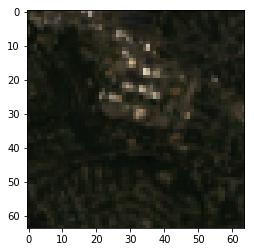

In [222]:
plt.imshow(reshaped_tile[:,:,[3,2,1]])


In [225]:
labellist = []
for (row, col) in coords:
    checkProj2 = Proj(label_dataset.crs)
    sat = landsat_datasets[0]
    checkProj1 = Proj(sat.crs)
    r, c =  row, col
    (x, y) = sat.xy(r, c)

    x,y = transform(checkProj1,checkProj2,x,y)
    row1, col1 = label_dataset.index(x,y)

    # find label
    label = label_image[:, row1, col1]
    labellist.append(label)
print(labellist)

[array([2], dtype=uint8), array([5], dtype=uint8), array([3], dtype=uint8), array([4], dtype=uint8), array([3], dtype=uint8), array([2], dtype=uint8), array([3], dtype=uint8), array([2], dtype=uint8), array([2], dtype=uint8), array([2], dtype=uint8), array([2], dtype=uint8), array([2], dtype=uint8), array([3], dtype=uint8), array([2], dtype=uint8), array([2], dtype=uint8), array([2], dtype=uint8), array([4], dtype=uint8), array([2], dtype=uint8), array([2], dtype=uint8), array([5], dtype=uint8), array([3], dtype=uint8), array([12], dtype=uint8), array([2], dtype=uint8), array([2], dtype=uint8), array([2], dtype=uint8), array([2], dtype=uint8), array([2], dtype=uint8), array([2], dtype=uint8), array([2], dtype=uint8), array([3], dtype=uint8), array([2], dtype=uint8), array([2], dtype=uint8), array([4], dtype=uint8), array([2], dtype=uint8), array([3], dtype=uint8), array([4], dtype=uint8), array([4], dtype=uint8), array([2], dtype=uint8), array([2], dtype=uint8), array([2], dtype=uint8)

In [115]:
def tile_generator(image_datasets, label_dataset, tile_height, tile_width, pixel_locations, batch_size):
    ### this is a keras compatible data generator which generates data and labels on the fly 
    ### from a set of pixel locations, a list of image datasets, and a label dataset
    
    # pixel locations looks like [r, c, dataset_index]

    #print("num unique = " + str(len(np.unique(label_image))))

    c = r = 0
    i = 0
    
    outProj = Proj(label_dataset.crs)

    # assuming all images have the same num of bands
    band_count = image_datasets[0].count
    
    buffer = math.ceil(tile_height / 2)
  
    while True:
        image_batch = np.zeros((batch_size, tile_height, tile_width, 3)) # take one off because we don't want the QA band
        label_batch = np.zeros((batch_size,class_count))
        b = 0
        while b < batch_size:
            # if we're at the end  of the data just restart
            if i >= len(pixel_locations):
                i=0
            c, r = pixel_locations[i][0]
            dataset_index = pixel_locations[i][1]
            i += 1
            tile = image_datasets[dataset_index].read(list(np.arange(1, band_count+1)), window=Window(c-buffer, r-buffer, tile_width, tile_height))
            if np.amax(tile) == 0: # don't include if it is part of the image with no pixels
                pass
            elif np.isnan(tile).any() == True or -9999 in tile: 
                # we don't want tiles containing nan or -999 this comes from edges
                # this also takes a while and is inefficient
                pass
            elif tile.shape != (band_count, tile_width, tile_height):
                print('wrong shape')
                print(tile.shape)
                # somehow we're randomly getting tiles without the correct dimensions
                pass
            elif np.isin(tile[7,:,:], [352, 368, 392, 416, 432, 480, 840, 864, 880, 904, 928, 944, 1352]).any() == True:
                # make sure pixel doesn't contain clouds
                # this is probably pretty inefficient but only checking width x height for each tile
                # read more here: https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/LSDS-1873_US_Landsat_ARD_DFCB_0.pdf
                #print('Found some cloud.')
                #print(tile[7,:,:])
                pass
            else:
                tile = adjust_band(tile[0:7])
                # reshape from raster format to image format
                reshaped_tile = reshape_as_image(tile)
                #print(reshaped_tile.shape)

                # find gps of that pixel within the image
                (x, y) = image_datasets[dataset_index].xy(r, c)

                # convert the point we're sampling from to the same projection as the label dataset if necessary
                inProj = Proj(image_datasets[dataset_index].crs)
                if inProj != outProj:
                    x,y = transform(inProj,outProj,x,y)

                # reference gps in label_image
                row, col = label_dataset.index(x,y)

                # find label
                label = label_image[:, row, col]
                # if this label is part of the unclassified area then ignore
                if label == 0 or np.isnan(label).any() == True:
                    pass
                else:
                    # add label to the batch in a one hot encoding style
                    label_batch[b][label] = 1
                    image_batch[b] = reshaped_tile[:,:,[4,3,2]]
                    b += 1
        yield (image_batch, label_batch)

In [130]:
def gen_pixel_locations(image_datasets, tile_size):
    ### this function pulls out a train_count + val_count number of random pixels from a list of raster datasets
    ### and returns a list of training pixel locations and image indices 
    ### and a list of validation pixel locations and indices
    
    ## future improvements could make this select classes evenly
    train_pixels = []
    val_pixels = []
    
    train_count = 5000*5000
    val_count = 0
    
    buffer = math.ceil(tile_size/2)
    
    train_count_per_dataset = math.ceil(train_count / len(image_datasets))
    val_count_per_dataset = math.ceil(val_count / len(image_datasets))
   
    total_count_per_dataset = train_count_per_dataset + val_count_per_dataset
    for index, image_dataset in enumerate(tqdm(image_datasets)):
        #randomly pick `count` num of pixels from each dataset
        img_height, img_width = image_dataset.shape
        
        rows = range(0+buffer, img_height-buffer)
        columns = range(0+buffer, img_width-buffer)
        #rows_sub, columns_sub = zip(*random.sample(list(zip(rows, columns)), total_count))
        
        points = []
        
        for r in rows:
            for c in columns:
                points.append((r,c))
        
        dataset_index_list = [index] * total_count_per_dataset
        
        dataset_pixels = list(zip(points, dataset_index_list))
        
        train_pixels += dataset_pixels[:train_count_per_dataset]
        val_pixels += dataset_pixels[train_count_per_dataset:]
        
        
    return (train_pixels, val_pixels)

In [193]:
all_px,_ = gen_pixel_locations(landsat_datasets[:1], tile_size=64)

100%|██████████| 1/1 [00:07<00:00,  7.17s/it]


In [140]:
len(all_px)

24880144

In [175]:
def image_tile_generator(image_datasets, label_image, tile_height, tile_width, pixel_locations, batch_size, find_label):
    ### this is a keras compatible data generator which generates data and labels on the fly 
    ### from a set of pixel locations, a list of image datasets, and a label dataset
    
    # pixel locations looks like [r, c, dataset_index]

    #print("num unique = " + str(len(np.unique(label_image))))

    c = r = 0
    i = 0
    
    outProj = Proj(label_dataset.crs)

    # assuming all images have the same num of bands
    band_count = image_datasets[0].count
    
    buffer = math.ceil(tile_height / 2)
  
    pixel_locations = np.random.permutation(pixel_locations)
    image_batch = np.zeros((batch_size, tile_height, tile_width, 3)) # take one off because we don't want the QA band
    label_batch = np.zeros((batch_size,23))
    b = 0

    while b < batch_size:
        # if we're at the end  of the data just restart
        if i >= len(pixel_locations):
            i=0
        c, r = pixel_locations[i][0]
        dataset_index = pixel_locations[i][1]
        i += 1
        #print(c)
        
        # find gps of that pixel within the image
        (x, y) = image_datasets[dataset_index].xy(r, c)
            
        # convert the point we're sampling from to the same projection as the label dataset if necessary
        inProj = Proj(image_datasets[dataset_index].crs)
        if inProj != outProj:
            x,y = transform(inProj,outProj,x,y)
                
            # reference gps in label_image
        row, col = label_dataset.index(x,y)

        # find label
        label = label_image[:, row, col]
        print(label)
        if (label != find_label):
            continue
        
        tile = image_datasets[dataset_index].read(list(np.arange(1, band_count+1)), window=Window(c-buffer, r-buffer, tile_width, tile_height))
        
        if np.amax(tile) == 0: # don't include if it is part of the image with no pixels
            pass
        elif np.isnan(tile).any() == True or -9999 in tile: 
            # we don't want tiles containing nan or -999 this comes from edges
            # this also takes a while and is inefficient
            pass
        elif tile.shape != (band_count, tile_width, tile_height):
            print('wrong shape')
            print(tile.shape)
            # somehow we're randomly getting tiles without the correct dimensions
            pass
        elif np.isin(tile[7,:,:], [352, 368, 392, 416, 432, 480, 840, 864, 880, 904, 928, 944, 1352]).any() == True:
            # make sure pixel doesn't contain clouds
            # this is probably pretty inefficient but only checking width x height for each tile
            # read more here: https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/LSDS-1873_US_Landsat_ARD_DFCB_0.pdf
            #print('Found some cloud.')
            #print(tile[7,:,:])
            pass
        else:
            tile = adjust_band(tile[0:7])
            # reshape from raster format to image format
            reshaped_tile = reshape_as_image(tile)
            #print(reshaped_tile.shape)

#             # find gps of that pixel within the image
#             (x, y) = image_datasets[dataset_index].xy(r, c)
            
#             # convert the point we're sampling from to the same projection as the label dataset if necessary
#             inProj = Proj(image_datasets[dataset_index].crs)
#             if inProj != outProj:
#                 x,y = transform(inProj,outProj,x,y)
                
#             # reference gps in label_image
#             row, col = label_dataset.index(x,y)

            # find label
            label = label_image[:, row, col]
            # if this label is part of the unclassified area then ignore
            if label == 0 or np.isnan(label).any() == True:
                pass
            else:
                # add label to the batch in a one hot encoding style
                label_batch[b][label] = 1
                image_batch[b] = reshaped_tile[:,:,[4,3,2]]
                b += 1
                print(b)
    return (image_batch, label_batch)

In [136]:
label_image = label_dataset.read()

In [176]:
label_2_ims = image_tile_generator(landsat_datasets[:1], label_image, 11, 11, all_px, batch_size=1000, find_label=2)

[13]
[0]
[13]
[3]
[13]
[8]
[13]
[10]
[12]
[13]
[6]
[11]
[13]
[10]
[6]
[14]
[6]
[6]
[6]
[13]
[13]
[13]
[6]
[0]
[10]
[10]
[6]
[6]
[12]
[8]
[6]
[12]
[10]
[13]
[10]
[0]
[0]
[10]
[10]
[14]
[11]
[12]
[6]
[10]
[13]
[6]
[6]
[13]
[12]
[15]
[6]
[0]
[13]
[12]
[4]
[6]
[13]
[6]
[13]
[21]
[8]
[12]
[6]
[3]
[11]
[13]
[12]
[10]
[12]
[14]
[10]
[10]
[9]
[14]
[6]
[5]
[6]
[12]
[6]
[6]
[12]
[11]
[3]
[13]
[4]
[0]
[8]
[14]
[13]
[8]
[6]
[6]
[7]
[8]
[10]
[10]
[13]
[10]
[0]
[6]
[10]
[0]
[20]
[21]
[9]
[11]
[6]
[6]
[10]
[6]
[10]
[6]
[0]
[6]
[5]
[6]
[13]
[8]
[13]
[14]
[13]
[6]
[13]
[0]
[0]
[6]
[6]
[6]
[10]
[6]
[0]
[8]
[13]
[10]
[13]
[14]
[6]
[14]
[13]
[0]
[6]
[13]
[12]
[0]
[10]
[10]
[6]
[6]
[13]
[0]
[10]
[0]
[12]
[12]
[6]
[13]
[6]
[6]
[15]
[0]
[10]
[13]
[6]
[0]
[6]
[8]
[10]
[13]
[0]
[12]
[6]
[13]
[13]
[12]
[14]
[12]
[6]
[12]
[10]
[12]
[0]
[6]
[0]
[6]
[13]
[13]
[12]
[10]
[6]
[0]
[13]
[12]
[12]
[13]
[8]
[14]
[0]
[21]
[14]
[0]
[14]
[10]
[15]
[10]
[6]
[12]
[6]
[12]
[4]
[6]
[10]
[0]
[10]
[10]
[13]
[13]
[13]
[0]
[5]
[5]


[13]
[9]
[6]
[13]
[6]
[6]
[12]
[0]
[10]
[8]
[6]
[13]
[4]
[14]
[6]
[13]
[6]
[10]
[13]
[12]
[10]
[12]
[6]
[6]
[6]
[13]
[13]
[6]
[14]
[10]
[6]
[15]
[6]
[13]
[14]
[13]
[13]
[6]
[13]
[13]
[10]
[12]
[6]
[6]
[6]
[14]
[5]
[13]
[6]
[12]
[7]
[3]
[6]
[10]
[6]
[6]
[13]
[12]
[6]
[6]
[11]
[12]
[12]
[6]
[13]
[6]
[13]
[10]
[8]
[6]
[6]
[6]
[4]
[10]
[8]
[14]
[15]
[4]
[0]
[13]
[0]
[0]
[6]
[12]
[13]
[13]
[0]
[4]
[13]
[12]
[10]
[11]
[15]
[6]
[12]
[6]
[8]
[13]
[14]
[0]
[13]
[6]
[0]
[10]
[7]
[10]
[15]
[10]
[6]
[6]
[8]
[3]
[10]
[0]
[3]
[8]
[0]
[6]
[13]
[14]
[6]
[12]
[12]
[13]
[10]
[6]
[13]
[0]
[10]
[6]
[0]
[6]
[6]
[8]
[6]
[6]
[0]
[7]
[15]
[13]
[0]
[13]
[0]
[12]
[10]
[0]
[12]
[6]
[4]
[13]
[4]
[6]
[10]
[13]
[12]
[4]
[0]
[8]
[6]
[8]
[13]
[12]
[13]
[14]
[14]
[4]
[13]
[14]
[5]
[10]
[6]
[6]
[4]
[6]
[0]
[6]
[6]
[11]
[6]
[8]
[10]
[21]
[6]
[12]
[12]
[13]
[10]
[12]
[0]
[14]
[6]
[13]
[6]
[12]
[10]
[6]
[11]
[10]
[6]
[12]
[0]
[12]
[8]
[10]
[6]
[14]
[10]
[0]
[14]
[6]
[12]
[13]
[12]
[13]
[10]
[12]
[6]
[8]
[12]
[12]
[0]
[13]

[15]
[10]
[8]
[10]
[13]
[13]
[10]
[10]
[6]
[0]
[6]
[14]
[12]
[14]
[10]
[5]
[12]
[13]
[6]
[6]
[6]
[0]
[10]
[13]
[6]
[6]
[6]
[15]
[0]
[12]
[0]
[6]
[12]
[6]
[12]
[6]
[4]
[15]
[10]
[5]
[14]
[4]
[6]
[6]
[6]
[13]
[13]
[4]
[6]
[13]
[13]
[0]
[12]
[14]
[12]
[10]
[10]
[12]
[13]
[10]
[10]
[13]
[6]
[13]
[4]
[13]
[13]
[13]
[6]
[10]
[0]
[8]
[0]
[13]
[6]
[3]
[6]
[0]
[6]
[13]
[12]
[7]
[8]
[12]
[12]
[10]
[6]
[20]
[12]
[10]
[6]
[10]
[10]
[13]
[6]
[13]
[13]
[12]
[0]
[13]
[12]
[6]
[0]
[6]
[6]
[0]
[12]
[0]
[8]
[13]
[13]
[6]
[12]
[10]
[0]
[15]
[0]
[12]
[6]
[13]
[13]
[6]
[6]
[6]
[13]
[10]
[10]
[8]
[14]
[13]
[6]
[13]
[12]
[12]
[8]
[0]
[7]
[10]
[6]
[6]
[9]
[8]
[13]
[6]
[0]
[6]
[8]
[14]
[6]
[6]
[6]
[6]
[0]
[12]
[7]
[13]
[13]
[8]
[5]
[0]
[13]
[10]
[6]
[3]
[13]
[6]
[8]
[13]
[13]
[14]
[10]
[4]
[10]
[0]
[10]
[0]
[7]
[10]
[12]
[6]
[6]
[12]
[0]
[13]
[4]
[6]
[13]
[0]
[10]
[0]
[6]
[0]
[0]
[15]
[14]
[10]
[6]
[8]
[13]
[13]
[0]
[6]
[10]
[6]
[6]
[6]
[14]
[6]
[21]
[10]
[0]
[0]
[13]
[13]
[12]
[6]
[12]
[12]
[6]
[6]
[12]
[12]


[10]
[10]
[6]
[12]
[6]
[10]
[6]
[6]
[12]
[6]
[6]
[12]
[10]
[6]
[10]
[13]
[6]
[14]
[6]
[6]
[14]
[13]
[15]
[14]
[10]
[0]
[4]
[8]
[6]
[6]
[12]
[10]
[4]
[12]
[13]
[13]
[10]
[13]
[12]
[13]
[14]
[0]
[8]
[3]
[14]
[6]
[6]
[11]
[13]
[13]
[12]
[10]
[12]
[6]
[0]
[14]
[13]
[14]
[0]
[10]
[6]
[13]
[6]
[10]
[6]
[8]
[6]
[11]
[10]
[10]
[13]
[14]
[0]
[0]
[6]
[6]
[10]
[12]
[13]
[13]
[12]
[8]
[13]
[10]
[12]
[6]
[12]
[6]
[15]
[10]
[6]
[12]
[10]
[8]
[12]
[10]
[11]
[12]
[13]
[0]
[11]
[6]
[12]
[6]
[12]
[14]
[10]
[13]
[10]
[15]
[5]
[21]
[4]
[0]
[13]
[10]
[5]
[13]
[0]
[8]
[6]
[15]
[8]
[13]
[13]
[13]
[14]
[12]
[0]
[8]
[8]
[13]
[10]
[14]
[12]
[10]
[14]
[13]
[13]
[0]
[10]
[0]
[13]
[6]
[6]
[14]
[15]
[0]
[0]
[0]
[0]
[10]
[13]
[6]
[6]
[12]
[21]
[0]
[13]
[12]
[13]
[13]
[13]
[6]
[13]
[10]
[13]
[6]
[5]
[6]
[6]
[6]
[10]
[6]
[11]
[8]
[20]
[0]
[10]
[10]
[10]
[6]
[10]
[8]
[6]
[4]
[14]
[0]
[12]
[12]
[14]
[10]
[0]
[10]
[13]
[6]
[13]
[4]
[10]
[10]
[6]
[6]
[0]
[21]
[7]
[13]
[13]
[6]
[21]
[5]
[13]
[14]
[20]
[14]
[6]
[0]
[12]
[10

[6]
[6]
[13]
[13]
[12]
[4]
[6]
[6]
[13]
[5]
[10]
[8]
[13]
[10]
[12]
[6]
[12]
[13]
[4]
[12]
[12]
[4]
[10]
[13]
[14]
[14]
[0]
[8]
[6]
[13]
[5]
[12]
[8]
[14]
[13]
[0]
[6]
[0]
[0]
[13]
[12]
[7]
[12]
[9]
[6]
[0]
[7]
[6]
[4]
[8]
[12]
[0]
[14]
[13]
[0]
[0]
[10]
[6]
[6]
[13]
[13]
[13]
[4]
[6]
[13]
[6]
[13]
[6]
[13]
[10]
[6]
[6]
[7]
[10]
[6]
[14]
[13]
[21]
[6]
[0]
[0]
[6]
[0]
[13]
[0]
[13]
[13]
[6]
[15]
[12]
[4]
[12]
[12]
[13]
[0]
[14]
[7]
[12]
[14]
[13]
[21]
[12]
[6]
[0]
[6]
[6]
[10]
[4]
[10]
[15]
[12]
[6]
[14]
[6]
[7]
[12]
[6]
[10]
[6]
[10]
[10]
[6]
[10]
[15]
[10]
[15]
[14]
[8]
[6]
[0]
[0]
[13]
[10]
[6]
[6]
[12]
[6]
[10]
[0]
[12]
[0]
[6]
[12]
[6]
[10]
[13]
[10]
[7]
[13]
[12]
[6]
[7]
[20]
[13]
[21]
[8]
[13]
[8]
[6]
[12]
[14]
[4]
[0]
[13]
[10]
[6]
[12]
[6]
[13]
[12]
[10]
[10]
[6]
[9]
[10]
[12]
[13]
[6]
[4]
[10]
[2]
[3]
[12]
[21]
[6]
[6]
[13]
[13]
[12]
[12]
[0]
[14]
[4]
[13]
[13]
[12]
[6]
[13]
[0]
[14]
[6]
[6]
[0]
[6]
[6]
[12]
[13]
[10]
[4]
[12]
[10]
[12]
[6]
[10]
[10]
[6]
[13]
[6]
[6]
[13]
[0]


[6]
[0]
[12]
[13]
[0]
[13]
[12]
[10]
[6]
[13]
[10]
[10]
[6]
[12]
[13]
[10]
[13]
[4]
[10]
[10]
[6]
[6]
[6]
[3]
[8]
[10]
[6]
[10]
[13]
[6]
[6]
[0]
[10]
[4]
[0]
[4]
[0]
[12]
[15]
[8]
[15]
[13]
[13]
[13]
[4]
[14]
[12]
[10]
[0]
[10]
[13]
[13]
[10]
[6]
[10]
[13]
[6]
[6]
[12]
[4]
[13]
[6]
[15]
[6]
[6]
[10]
[0]
[10]
[6]
[6]
[14]
[13]
[14]
[12]
[13]
[10]
[10]
[10]
[13]
[11]
[6]
[0]
[13]
[13]
[6]
[13]
[8]
[0]
[14]
[6]
[12]
[12]
[13]
[13]
[13]
[9]
[12]
[6]
[5]
[12]
[6]
[10]
[12]
[4]
[6]
[10]
[13]
[5]
[10]
[6]
[12]
[13]
[6]
[14]
[13]
[12]
[20]
[10]
[13]
[13]
[12]
[14]
[10]
[6]
[7]
[11]
[6]
[13]
[12]
[6]
[12]
[0]
[13]
[10]
[13]
[13]
[12]
[8]
[14]
[12]
[8]
[10]
[6]
[6]
[13]
[14]
[21]
[6]
[12]
[13]
[6]
[10]
[0]
[5]
[14]
[6]
[6]
[10]
[12]
[6]
[6]
[0]
[4]
[6]
[13]
[6]
[6]
[8]
[12]
[4]
[20]
[12]
[8]
[6]
[13]
[13]
[10]
[8]
[13]
[11]
[10]
[6]
[0]
[10]
[8]
[10]
[12]
[8]
[0]
[14]
[10]
[4]
[0]
[13]
[6]
[13]
[10]
[6]
[0]
[13]
[6]
[10]
[4]
[6]
[0]
[3]
[12]
[13]
[6]
[6]
[6]
[13]
[4]
[6]
[6]
[6]
[5]
[6]
[10]
[6]

20
[12]
[8]
[9]
[13]
[10]
[0]
[10]
[0]
[21]
[12]
[0]
[12]
[12]
[13]
[10]
[6]
[12]
[12]
[13]
[6]
[15]
[11]
[6]
[11]
[0]
[12]
[12]
[11]
[13]
[13]
[12]
[10]
[5]
[0]
[5]
[10]
[13]
[10]
[13]
[6]
[6]
[6]
[6]
[3]
[13]
[12]
[12]
[15]
[10]
[12]
[13]
[13]
[0]
[13]
[10]
[6]
[10]
[6]
[8]
[6]
[8]
[12]
[6]
[0]
[14]
[12]
[6]
[6]
[10]
[6]
[6]
[12]
[6]
[10]
[8]
[12]
[8]
[6]
[10]
[10]
[6]
[0]
[13]
[12]
[6]
[13]
[6]
[6]
[10]
[15]
[13]
[6]
[10]
[12]
[10]
[21]
[12]
[6]
[12]
[13]
[12]
[12]
[10]
[12]
[10]
[10]
[6]
[10]
[13]
[6]
[6]
[10]
[0]
[6]
[10]
[6]
[13]
[6]
[13]
[13]
[10]
[14]
[12]
[13]
[6]
[14]
[13]
[13]
[6]
[10]
[10]
[14]
[6]
[14]
[5]
[0]
[12]
[0]
[6]
[13]
[13]
[10]
[0]
[8]
[0]
[6]
[6]
[13]
[6]
[12]
[13]
[6]
[10]
[6]
[10]
[0]
[0]
[13]
[6]
[10]
[6]
[10]
[0]
[13]
[8]
[10]
[12]
[0]
[13]
[13]
[12]
[0]
[14]
[15]
[6]
[0]
[6]
[10]
[6]
[6]
[6]
[10]
[0]
[10]
[6]
[6]
[13]
[6]
[0]
[13]
[11]
[6]
[12]
[4]
[6]
[13]
[6]
[13]
[0]
[13]
[13]
[13]
[12]
[10]
[6]
[7]
[14]
[8]
[11]
[12]
[6]
[6]
[6]
[6]
[12]
[3]
[13]
[6]
[1

[0]
[6]
[12]
[10]
[4]
[7]
[14]
[14]
[14]
[21]
[6]
[15]
[6]
[14]
[6]
[12]
[13]
[13]
[12]
[13]
[12]
[6]
[13]
[13]
[13]
[12]
[3]
[12]
[12]
[12]
[0]
[13]
[0]
[8]
[13]
[10]
[0]
[6]
[13]
[4]
[6]
[11]
[6]
[5]
[6]
[10]
[8]
[12]
[13]
[10]
[8]
[8]
[12]
[10]
[13]
[10]
[0]
[13]
[10]
[10]
[6]
[0]
[0]
[6]
[8]
[6]
[0]
[6]
[10]
[0]
[12]
[6]
[13]
[12]
[0]
[10]
[13]
[6]
[12]
[9]
[20]
[4]
[6]
[8]
[0]
[6]
[4]
[6]
[8]
[10]
[6]
[8]
[14]
[8]
[13]
[13]
[13]
[6]
[0]
[6]
[10]
[10]
[0]
[0]
[10]
[14]
[12]
[6]
[0]
[10]
[14]
[14]
[8]
[13]
[0]
[6]
[13]
[12]
[13]
[5]
[10]
[13]
[12]
[13]
[6]
[0]
[8]
[12]
[12]
[12]
[8]
[12]
[6]
[20]
[12]
[9]
[10]
[6]
[10]
[8]
[8]
[0]
[10]
[0]
[10]
[13]
[6]
[13]
[10]
[6]
[10]
[6]
[12]
[0]
[0]
[6]
[10]
[8]
[4]
[0]
[13]
[12]
[10]
[12]
[10]
[6]
[10]
[6]
[6]
[14]
[21]
[11]
[6]
[12]
[15]
[6]
[13]
[6]
[10]
[6]
[6]
[6]
[10]
[6]
[8]
[10]
[15]
[0]
[15]
[12]
[3]
[0]
[13]
[0]
[13]
[6]
[9]
[0]
[13]
[6]
[13]
[12]
[8]
[12]
[8]
[5]
[12]
[4]
[8]
[14]
[2]
24
[4]
[12]
[6]
[0]
[14]
[6]
[6]
[10]
[12]
[12]


[13]
[6]
[8]
[6]
[12]
[5]
[20]
[8]
[13]
[9]
[6]
[10]
[6]
[10]
[4]
[6]
[10]
[8]
[14]
[10]
[10]
[6]
[10]
[4]
[21]
[0]
[13]
[13]
[12]
[12]
[6]
[12]
[6]
[6]
[0]
[14]
[6]
[12]
[8]
[10]
[14]
[12]
[12]
[0]
[6]
[6]
[10]
[13]
[10]
[13]
[6]
[9]
[10]
[12]
[14]
[15]
[13]
[5]
[12]
[12]
[6]
[6]
[12]
[12]
[6]
[13]
[10]
[13]
[0]
[6]
[0]
[0]
[10]
[8]
[6]
[10]
[10]
[10]
[12]
[6]
[15]
[6]
[6]
[10]
[6]
[10]
[4]
[13]
[12]
[13]
[10]
[6]
[15]
[6]
[8]
[0]
[6]
[6]
[6]
[13]
[0]
[13]
[13]
[12]
[10]
[8]
[0]
[10]
[9]
[8]
[10]
[6]
[14]
[0]
[8]
[0]
[12]
[13]
[10]
[0]
[3]
[13]
[8]
[13]
[6]
[7]
[6]
[8]
[13]
[13]
[6]
[10]
[14]
[13]
[13]
[3]
[12]
[10]
[6]
[13]
[13]
[6]
[8]
[10]
[6]
[6]
[6]
[12]
[10]
[8]
[12]
[12]
[10]
[6]
[12]
[10]
[8]
[12]
[6]
[6]
[6]
[13]
[13]
[6]
[0]
[6]
[13]
[13]
[15]
[12]
[12]
[10]
[6]
[13]
[4]
[6]
[11]
[13]
[6]
[10]
[9]
[12]
[10]
[4]
[6]
[10]
[6]
[13]
[6]
[13]
[0]
[12]
[13]
[0]
[6]
[6]
[12]
[12]
[13]
[10]
[13]
[13]
[10]
[12]
[4]
[12]
[6]
[6]
[13]
[9]
[6]
[10]
[12]
[12]
[0]
[11]
[6]
[0]
[13]
[13]
[

[10]
[12]
[12]
[12]
[11]
[12]
[13]
[12]
[6]
[6]
[6]
[6]
[13]
[6]
[11]
[6]
[12]
[0]
[12]
[9]
[10]
[0]
[5]
[10]
[6]
[10]
[6]
[10]
[6]
[8]
[0]
[13]
[6]
[10]
[13]
[0]
[12]
[12]
[10]
[0]
[6]
[12]
[12]
[12]
[7]
[13]
[0]
[10]
[12]
[12]
[10]
[13]
[6]
[0]
[12]
[14]
[8]
[0]
[6]
[10]
[9]
[8]
[4]
[12]
[13]
[13]
[0]
[10]
[13]
[5]
[4]
[6]
[12]
[6]
[12]
[4]
[10]
[9]
[10]
[10]
[6]
[0]
[0]
[0]
[10]
[0]
[10]
[10]
[0]
[13]
[0]
[8]
[21]
[11]
[12]
[0]
[12]
[10]
[8]
[0]
[10]
[13]
[6]
[10]
[13]
[10]
[12]
[10]
[0]
[6]
[6]
[7]
[14]
[6]
[6]
[0]
[6]
[8]
[12]
[0]
[0]
[6]
[10]
[13]
[11]
[6]
[0]
[13]
[6]
[0]
[6]
[13]
[10]
[11]
[6]
[7]
[6]
[4]
[12]
[10]
[6]
[6]
[21]
[5]
[12]
[6]
[12]
[12]
[6]
[12]
[13]
[13]
[10]
[6]
[6]
[10]
[20]
[10]
[14]
[6]
[7]
[6]
[6]
[6]
[4]
[8]
[12]
[14]
[13]
[0]
[13]
[14]
[6]
[13]
[6]
[6]
[6]
[6]
[20]
[6]
[6]
[11]
[12]
[10]
[10]
[4]
[6]
[0]
[12]
[15]
[15]
[12]
[5]
[13]
[12]
[10]
[12]
[4]
[10]
[8]
[0]
[10]
[12]
[0]
[6]
[4]
[6]
[12]
[6]
[9]
[10]
[6]
[4]
[12]
[10]
[12]
[14]
[10]
[11]
[0]
[0]
[14

[10]
[13]
[13]
[4]
[0]
[6]
[0]
[0]
[10]
[4]
[6]
[5]
[0]
[13]
[12]
[12]
[15]
[10]
[10]
[14]
[5]
[14]
[10]
[10]
[8]
[6]
[10]
[10]
[13]
[13]
[13]
[0]
[15]
[9]
[4]
[6]
[13]
[0]
[8]
[10]
[5]
[6]
[3]
[13]
[14]
[8]
[0]
[10]
[8]
[6]
[4]
[13]
[6]
[13]
[13]
[3]
[13]
[0]
[6]
[13]
[15]
[11]
[6]
[12]
[4]
[8]
[21]
[14]
[6]
[14]
[6]
[6]
[13]
[11]
[0]
[12]
[13]
[0]
[10]
[0]
[0]
[6]
[6]
[6]
[6]
[13]
[13]
[12]
[13]
[0]
[10]
[13]
[6]
[6]
[12]
[13]
[5]
[6]
[6]
[0]
[13]
[0]
[0]
[6]
[0]
[0]
[6]
[0]
[8]
[12]
[8]
[6]
[12]
[12]
[10]
[0]
[12]
[11]
[6]
[13]
[0]
[12]
[6]
[13]
[0]
[6]
[12]
[6]
[14]
[10]
[13]
[14]
[6]
[12]
[10]
[6]
[8]
[13]
[7]
[12]
[13]
[0]
[6]
[6]
[6]
[0]
[0]
[13]
[8]
[13]
[10]
[9]
[6]
[4]
[12]
[10]
[10]
[8]
[0]
[12]
[0]
[12]
[6]
[13]
[14]
[8]
[6]
[6]
[6]
[7]
[10]
[9]
[6]
[6]
[12]
[12]
[20]
[9]
[10]
[12]
[13]
[10]
[12]
[13]
[10]
[0]
[6]
[10]
[0]
[6]
[6]
[12]
[12]
[12]
[10]
[13]
[10]
[10]
[13]
[13]
[12]
[7]
[6]
[9]
[14]
[6]
[0]
[0]
[6]
[13]
[6]
[13]
[13]
[5]
[10]
[4]
[10]
[14]
[12]
[13]
[10]
[0]
[

[13]
[0]
[10]
[6]
[12]
[13]
[6]
[13]
[12]
[12]
[12]
[13]
[12]
[6]
[15]
[10]
[6]
[13]
[13]
[4]
[12]
[21]
[4]
[4]
[6]
[6]
[13]
[6]
[10]
[6]
[12]
[12]
[14]
[10]
[4]
[6]
[6]
[12]
[13]
[6]
[0]
[12]
[10]
[10]
[13]
[14]
[12]
[14]
[12]
[14]
[5]
[4]
[10]
[4]
[0]
[13]
[12]
[8]
[6]
[9]
[6]
[0]
[9]
[12]
[6]
[12]
[13]
[10]
[10]
[13]
[10]
[10]
[0]
[6]
[6]
[6]
[9]
[6]
[10]
[6]
[12]
[14]
[6]
[13]
[8]
[0]
[12]
[14]
[13]
[13]
[12]
[0]
[13]
[10]
[0]
[13]
[6]
[21]
[6]
[0]
[6]
[6]
[14]
[12]
[0]
[12]
[12]
[13]
[13]
[13]
[7]
[13]
[6]
[13]
[12]
[6]
[0]
[5]
[8]
[11]
[0]
[0]
[10]
[12]
[13]
[6]
[6]
[12]
[13]
[0]
[10]
[8]
[12]
[12]
[13]
[2]
[12]
[6]
[10]
[8]
[0]
[10]
[13]
[6]
[13]
[6]
[12]
[13]
[13]
[6]
[0]
[13]
[8]
[10]
[13]
[10]
[10]
[12]
[21]
[6]
[13]
[0]
[13]
[6]
[5]
[13]
[14]
[6]
[14]
[12]
[6]
[10]
[8]
[6]
[0]
[15]
[6]
[6]
[8]
[6]
[10]
[13]
[11]
[12]
[6]
[14]
[6]
[12]
[4]
[13]
[13]
[14]
[12]
[0]
[7]
[13]
[10]
[8]
[13]
[13]
[14]
[13]
[12]
[4]
[10]
[6]
[12]
[12]
[4]
[10]
[6]
[13]
[10]
[10]
[6]
[12]
[0]
[10]
[1

[11]
[10]
[0]
[10]
[6]
[14]
[13]
[6]
[14]
[6]
[13]
[13]
[10]
[2]
32
[13]
[6]
[6]
[10]
[13]
[13]
[10]
[6]
[10]
[13]
[14]
[8]
[6]
[10]
[11]
[13]
[10]
[12]
[20]
[14]
[10]
[12]
[12]
[10]
[12]
[10]
[10]
[10]
[12]
[6]
[0]
[13]
[10]
[5]
[3]
[13]
[12]
[6]
[10]
[21]
[7]
[4]
[12]
[8]
[13]
[13]
[11]
[8]
[6]
[6]
[0]
[10]
[12]
[6]
[2]
33
[0]
[15]
[14]
[0]
[6]
[6]
[14]
[14]
[6]
[6]
[7]
[10]
[10]
[15]
[13]
[13]
[6]
[10]
[8]
[6]
[13]
[12]
[15]
[6]
[12]
[10]
[12]
[12]
[13]
[6]
[6]
[12]
[4]
[8]
[4]
[10]
[7]
[6]
[6]
[8]
[12]
[6]
[0]
[12]
[6]
[0]
[12]
[6]
[10]
[10]
[0]
[14]
[14]
[7]
[0]
[13]
[12]
[10]
[20]
[6]
[0]
[10]
[13]
[13]
[13]
[13]
[13]
[12]
[10]
[8]
[6]
[21]
[10]
[0]
[10]
[12]
[15]
[12]
[0]
[6]
[8]
[8]
[6]
[10]
[12]
[8]
[0]
[13]
[11]
[2]
[6]
[10]
[14]
[8]
[12]
[10]
[12]
[0]
[0]
[14]
[14]
[13]
[13]
[13]
[11]
[13]
[6]
[6]
[21]
[8]
[12]
[13]
[10]
[13]
[6]
[0]
[12]
[8]
[13]
[13]
[13]
[20]
[13]
[13]
[6]
[12]
[6]
[0]
[15]
[12]
[13]
[13]
[14]
[6]
[6]
[10]
[14]
[6]
[5]
[0]
[13]
[12]
[13]
[0]
[10]
[4]
[6]


[12]
[10]
[13]
[12]
[10]
[6]
[13]
[6]
[12]
[10]
[0]
[10]
[13]
[10]
[13]
[12]
[0]
[15]
[13]
[6]
[6]
[14]
[10]
[6]
[13]
[13]
[6]
[14]
[13]
[10]
[6]
[6]
[6]
[4]
[10]
[8]
[13]
[12]
[8]
[10]
[20]
[13]
[12]
[11]
[13]
[7]
[13]
[8]
[6]
[10]
[6]
[9]
[6]
[12]
[10]
[6]
[0]
[12]
[8]
[6]
[13]
[6]
[6]
[13]
[8]
[10]
[0]
[14]
[6]
[13]
[13]
[0]
[10]
[6]
[13]
[4]
[10]
[13]
[6]
[10]
[4]
[13]
[10]
[8]
[13]
[12]
[10]
[0]
[12]
[10]
[4]
[13]
[6]
[12]
[12]
[6]
[0]
[10]
[6]
[0]
[4]
[13]
[10]
[13]
[11]
[0]
[11]
[6]
[6]
[6]
[0]
[6]
[13]
[13]
[14]
[10]
[10]
[9]
[10]
[12]
[6]
[12]
[13]
[13]
[0]
[8]
[13]
[12]
[10]
[13]
[13]
[10]
[6]
[14]
[6]
[10]
[0]
[10]
[13]
[10]
[13]
[6]
[6]
[6]
[0]
[13]
[6]
[7]
[10]
[13]
[6]
[7]
[13]
[13]
[12]
[14]
[10]
[14]
[13]
[12]
[0]
[13]
[5]
[14]
[0]
[6]
[13]
[21]
[12]
[10]
[10]
[12]
[14]
[6]
[0]
[0]
[10]
[6]
[10]
[13]
[14]
[10]
[14]
[4]
[10]
[12]
[21]
[6]
[0]
[0]
[11]
[6]
[12]
[10]
[6]
[0]
[6]
[13]
[0]
[10]
[10]
[13]
[6]
[12]
[6]
[0]
[5]
[10]
[10]
[6]
[4]
[6]
[6]
[4]
[13]
[0]
[14]
[14]
[

[10]
[8]
[9]
[12]
[14]
[6]
[12]
[14]
[14]
[14]
[6]
[4]
[10]
[12]
[13]
[13]
[13]
[6]
[13]
[6]
[13]
[6]
[10]
[6]
[6]
[8]
[0]
[13]
[6]
[6]
[11]
[13]
[14]
[11]
[14]
[4]
[6]
[6]
[13]
[8]
[13]
[15]
[21]
[0]
[6]
[6]
[10]
[13]
[6]
[6]
[0]
[6]
[13]
[15]
[6]
[13]
[14]
[13]
[4]
[10]
[6]
[13]
[13]
[12]
[10]
[6]
[6]
[10]
[12]
[4]
[10]
[0]
[8]
[6]
[10]
[13]
[11]
[6]
[10]
[10]
[13]
[13]
[12]
[6]
[10]
[10]
[0]
[13]
[12]
[13]
[10]
[13]
[12]
[10]
[10]
[15]
[12]
[13]
[10]
[6]
[6]
[12]
[13]
[13]
[8]
[12]
[8]
[13]
[14]
[13]
[10]
[10]
[11]
[6]
[13]
[20]
[12]
[13]
[10]
[10]
[6]
[4]
[0]
[10]
[12]
[6]
[6]
[13]
[13]
[10]
[14]
[15]
[6]
[10]
[12]
[11]
[8]
[12]
[0]
[13]
[5]
[10]
[3]
[8]
[8]
[12]
[6]
[0]
[14]
[10]
[6]
[12]
[6]
[15]
[13]
[13]
[10]
[6]
[12]
[10]
[13]
[10]
[13]
[4]
[0]
[0]
[10]
[4]
[13]
[6]
[13]
[13]
[6]
[8]
[21]
[6]
[13]
[8]
[12]
[12]
[8]
[0]
[6]
[6]
[21]
[6]
[10]
[12]
[6]
[10]
[6]
[6]
[6]
[4]
[13]
[6]
[0]
[4]
[12]
[13]
[13]
[6]
[0]
[8]
[12]
[6]
[12]
[12]
[10]
[12]
[6]
[13]
[10]
[0]
[13]
[6]
[3]
[14]

[6]
[10]
[13]
[6]
[13]
[8]
[6]
[8]
[12]
[14]
[11]
[10]
[7]
[13]
[10]
[14]
[10]
[6]
[0]
[12]
[0]
[0]
[6]
[6]
[3]
[6]
[13]
[8]
[6]
[12]
[11]
[6]
[13]
[6]
[0]
[13]
[14]
[5]
[12]
[14]
[13]
[0]
[10]
[6]
[10]
[13]
[10]
[0]
[14]
[14]
[14]
[10]
[10]
[3]
[6]
[14]
[8]
[13]
[0]
[4]
[6]
[12]
[6]
[13]
[13]
[12]
[12]
[10]
[10]
[12]
[6]
[13]
[6]
[6]
[0]
[10]
[14]
[6]
[13]
[10]
[9]
[13]
[6]
[4]
[6]
[12]
[6]
[4]
[12]
[6]
[13]
[13]
[13]
[12]
[12]
[10]
[6]
[12]
[12]
[13]
[10]
[13]
[12]
[10]
[13]
[12]
[12]
[13]
[9]
[13]
[0]
[13]
[6]
[10]
[6]
[6]
[0]
[0]
[10]
[14]
[12]
[6]
[4]
[0]
[12]
[6]
[14]
[6]
[8]
[4]
[10]
[13]
[0]
[11]
[0]
[6]
[21]
[6]
[13]
[6]
[13]
[0]
[6]
[6]
[13]
[13]
[0]
[14]
[10]
[10]
[0]
[0]
[13]
[6]
[11]
[6]
[10]
[10]
[0]
[6]
[21]
[12]
[8]
[11]
[6]
[10]
[5]
[10]
[14]
[13]
[14]
[7]
[14]
[6]
[10]
[6]
[13]
[10]
[10]
[12]
[12]
[13]
[5]
[0]
[10]
[13]
[14]
[4]
[10]
[13]
[12]
[10]
[13]
[11]
[21]
[13]
[7]
[10]
[12]
[6]
[10]
[6]
[7]
[6]
[6]
[6]
[13]
[8]
[0]
[8]
[13]
[12]
[6]
[21]
[14]
[6]
[13]
[13]
[12

49
[6]
[6]
[6]
[0]
[14]
[13]
[0]
[13]
[8]
[6]
[6]
[6]
[10]
[10]
[10]
[12]
[12]
[6]
[10]
[7]
[12]
[0]
[13]
[11]
[10]
[10]
[6]
[13]
[12]
[10]
[6]
[6]
[13]
[13]
[10]
[11]
[13]
[13]
[13]
[0]
[12]
[0]
[13]
[12]
[11]
[10]
[10]
[8]
[8]
[6]
[0]
[12]
[13]
[12]
[2]
[6]
[15]
[14]
[6]
[0]
[6]
[0]
[10]
[5]
[10]
[13]
[0]
[13]
[21]
[15]
[6]
[10]
[6]
[6]
[6]
[8]
[14]
[6]
[12]
[15]
[6]
[10]
[12]
[0]
[11]
[6]
[10]
[10]
[6]
[0]
[6]
[8]
[13]
[6]
[0]
[10]
[6]
[14]
[10]
[7]
[12]
[13]
[6]
[6]
[6]
[4]
[12]
[6]
[10]
[12]
[0]
[14]
[10]
[0]
[5]
[9]
[6]
[6]
[10]
[4]
[10]
[13]
[14]
[10]
[6]
[12]
[12]
[13]
[4]
[10]
[8]
[10]
[9]
[0]
[13]
[0]
[0]
[14]
[5]
[15]
[13]
[6]
[11]
[5]
[6]
[12]
[7]
[12]
[13]
[10]
[13]
[10]
[20]
[5]
[13]
[12]
[6]
[12]
[12]
[13]
[13]
[8]
[6]
[6]
[10]
[6]
[6]
[6]
[21]
[4]
[6]
[10]
[0]
[0]
[6]
[12]
[6]
[10]
[6]
[14]
[6]
[7]
[13]
[6]
[13]
[12]
[12]
[13]
[14]
[8]
[14]
[6]
[10]
[12]
[10]
[10]
[0]
[13]
[8]
[0]
[6]
[13]
[5]
[10]
[15]
[10]
[8]
[10]
[12]
[12]
[13]
[6]
[15]
[12]
[12]
[12]
[6]
[6]
[10]
[

[6]
[6]
[0]
[4]
[12]
[8]
[10]
[15]
[4]
[6]
[15]
[6]
[0]
[0]
[14]
[6]
[12]
[12]
[9]
[14]
[8]
[13]
[0]
[10]
[0]
[13]
[21]
[13]
[6]
[10]
[13]
[13]
[12]
[12]
[12]
[13]
[14]
[0]
[13]
[12]
[6]
[13]
[12]
[6]
[14]
[3]
[6]
[12]
[6]
[10]
[10]
[13]
[13]
[6]
[6]
[13]
[6]
[14]
[11]
[6]
[14]
[10]
[11]
[10]
[13]
[0]
[13]
[5]
[0]
[6]
[13]
[12]
[0]
[11]
[10]
[12]
[10]
[0]
[13]
[6]
[0]
[10]
[10]
[12]
[5]
[10]
[13]
[13]
[9]
[6]
[4]
[0]
[6]
[4]
[6]
[0]
[6]
[10]
[6]
[5]
[13]
[12]
[10]
[6]
[7]
[6]
[15]
[6]
[4]
[12]
[14]
[13]
[6]
[12]
[3]
[10]
[6]
[21]
[10]
[6]
[6]
[6]
[4]
[14]
[10]
[14]
[10]
[13]
[14]
[10]
[6]
[13]
[13]
[13]
[6]
[13]
[11]
[5]
[6]
[8]
[6]
[12]
[13]
[6]
[6]
[5]
[13]
[7]
[10]
[6]
[15]
[6]
[13]
[12]
[6]
[8]
[10]
[6]
[6]
[14]
[13]
[6]
[6]
[10]
[6]
[10]
[10]
[13]
[10]
[14]
[12]
[13]
[9]
[6]
[6]
[15]
[12]
[6]
[8]
[12]
[12]
[6]
[6]
[8]
[12]
[13]
[8]
[13]
[12]
[6]
[12]
[0]
[0]
[4]
[12]
[10]
[12]
[0]
[6]
[10]
[13]
[6]
[0]
[6]
[6]
[8]
[6]
[0]
[13]
[10]
[13]
[13]
[21]
[0]
[0]
[12]
[13]
[12]
[6]
[14]
[1

[10]
[13]
[0]
[6]
[6]
[0]
[13]
[6]
[6]
[13]
[0]
[12]
[7]
[6]
[6]
[5]
[11]
[0]
[4]
[10]
[6]
[0]
[6]
[12]
[12]
[15]
[6]
[13]
[12]
[12]
[12]
[10]
[0]
[13]
[0]
[3]
[6]
[0]
[0]
[10]
[0]
[12]
[12]
[0]
[8]
[14]
[15]
[0]
[6]
[13]
[6]
[13]
[6]
[13]
[0]
[11]
[10]
[6]
[14]
[6]
[13]
[13]
[13]
[13]
[13]
[0]
[6]
[4]
[13]
[10]
[14]
[6]
[5]
[6]
[9]
[4]
[0]
[8]
[12]
[14]
[6]
[14]
[11]
[0]
[4]
[12]
[10]
[13]
[6]
[6]
[13]
[10]
[10]
[13]
[6]
[12]
[13]
[6]
[7]
[13]
[6]
[0]
[6]
[10]
[10]
[12]
[6]
[6]
[4]
[0]
[6]
[14]
[13]
[10]
[13]
[12]
[6]
[11]
[14]
[8]
[8]
[10]
[13]
[13]
[13]
[4]
[13]
[0]
[14]
[8]
[14]
[12]
[4]
[10]
[10]
[6]
[13]
[12]
[12]
[8]
[10]
[10]
[14]
[6]
[5]
[13]
[21]
[5]
[0]
[6]
[0]
[10]
[5]
[10]
[10]
[12]
[15]
[12]
[12]
[13]
[0]
[12]
[6]
[8]
[6]
[13]
[12]
[15]
[6]
[6]
[0]
[5]
[14]
[6]
[13]
[10]
[0]
[8]
[0]
[12]
[13]
[13]
[10]
[10]
[14]
[4]
[14]
[11]
[6]
[6]
[13]
[13]
[3]
[6]
[13]
[13]
[12]
[7]
[12]
[0]
[0]
[14]
[10]
[6]
[10]
[0]
[10]
[0]
[6]
[12]
[0]
[10]
[6]
[6]
[4]
[0]
[13]
[6]
[4]
[0]
[21]
[1

[15]
[14]
[10]
[12]
[13]
[10]
[10]
[21]
[15]
[6]
[0]
[6]
[5]
[12]
[12]
[12]
[6]
[13]
[10]
[13]
[0]
[6]
[6]
[10]
[6]
[13]
[12]
[0]
[0]
[10]
[12]
[0]
[9]
[14]
[6]
[10]
[0]
[13]
[15]
[13]
[14]
[0]
[9]
[12]
[13]
[13]
[10]
[12]
[9]
[13]
[12]
[10]
[13]
[6]
[13]
[12]
[4]
[13]
[0]
[0]
[6]
[8]
[13]
[6]
[10]
[13]
[13]
[11]
[0]
[13]
[6]
[6]
[7]
[13]
[6]
[13]
[14]
[13]
[21]
[15]
[13]
[10]
[12]
[13]
[14]
[13]
[6]
[6]
[8]
[14]
[10]
[6]
[6]
[10]
[6]
[13]
[13]
[5]
[11]
[12]
[5]
[12]
[0]
[6]
[5]
[6]
[12]
[6]
[6]
[14]
[6]
[14]
[12]
[9]
[10]
[10]
[6]
[0]
[4]
[15]
[12]
[0]
[14]
[11]
[4]
[12]
[6]
[12]
[7]
[10]
[4]
[9]
[10]
[15]
[12]
[10]
[0]
[13]
[12]
[6]
[12]
[0]
[12]
[6]
[0]
[13]
[10]
[10]
[9]
[10]
[10]
[6]
[12]
[13]
[12]
[14]
[6]
[10]
[13]
[5]
[10]
[9]
[21]
[6]
[4]
[0]
[12]
[13]
[6]
[8]
[12]
[6]
[12]
[0]
[6]
[10]
[6]
[0]
[13]
[12]
[6]
[13]
[13]
[0]
[8]
[5]
[10]
[12]
[10]
[0]
[6]
[10]
[0]
[13]
[4]
[10]
[6]
[10]
[10]
[10]
[3]
[6]
[0]
[10]
[6]
[10]
[12]
[8]
[12]
[12]
[6]
[12]
[6]
[14]
[0]
[6]
[8]
[6]
[12]


[4]
[13]
[6]
[0]
[6]
[13]
[4]
[6]
[13]
[12]
[6]
[14]
[0]
[6]
[10]
[21]
[10]
[13]
[10]
[12]
[6]
[6]
[10]
[6]
[13]
[8]
[10]
[8]
[6]
[12]
[10]
[6]
[12]
[14]
[6]
[13]
[10]
[11]
[13]
[0]
[10]
[10]
[6]
[21]
[6]
[12]
[10]
[10]
[13]
[4]
[13]
[14]
[13]
[6]
[0]
[13]
[6]
[12]
[6]
[12]
[13]
[0]
[12]
[13]
[4]
[13]
[10]
[12]
[6]
[13]
[11]
[8]
[10]
[13]
[10]
[11]
[0]
[6]
[14]
[8]
[3]
[10]
[6]
[10]
[6]
[15]
[21]
[6]
[4]
[6]
[12]
[6]
[14]
[13]
[6]
[10]
[10]
[3]
[6]
[6]
[12]
[8]
[8]
[11]
[0]
[6]
[10]
[13]
[13]
[0]
[10]
[13]
[7]
[13]
[13]
[0]
[7]
[12]
[21]
[10]
[13]
[13]
[13]
[10]
[13]
[13]
[6]
[14]
[6]
[13]
[6]
[0]
[6]
[6]
[6]
[8]
[13]
[8]
[10]
[6]
[21]
[6]
[12]
[6]
[8]
[14]
[10]
[11]
[12]
[4]
[14]
[0]
[6]
[12]
[9]
[13]
[6]
[12]
[13]
[6]
[14]
[12]
[6]
[6]
[0]
[14]
[6]
[4]
[14]
[11]
[10]
[10]
[13]
[6]
[0]
[10]
[6]
[3]
[10]
[14]
[13]
[12]
[4]
[0]
[12]
[0]
[0]
[14]
[10]
[6]
[6]
[6]
[10]
[6]
[12]
[6]
[6]
[13]
[14]
[6]
[10]
[0]
[6]
[9]
[13]
[0]
[0]
[12]
[0]
[10]
[0]
[10]
[14]
[10]
[8]
[6]
[13]
[10]
[6]
[11]


[12]
[11]
[6]
[6]
[6]
[15]
[13]
[0]
[5]
[0]
[4]
[13]
[6]
[13]
[12]
[0]
[15]
[10]
[12]
[0]
[0]
[6]
[6]
[5]
[13]
[13]
[13]
[4]
[12]
[13]
[13]
[0]
[12]
[6]
[6]
[0]
[10]
[8]
[14]
[13]
[13]
[6]
[21]
[0]
[6]
[10]
[13]
[21]
[6]
[8]
[6]
[10]
[3]
[13]
[0]
[6]
[6]
[12]
[13]
[10]
[6]
[6]
[6]
[6]
[0]
[6]
[13]
[10]
[14]
[12]
[10]
[12]
[10]
[10]
[0]
[9]
[6]
[13]
[10]
[5]
[12]
[0]
[12]
[6]
[13]
[6]
[0]
[10]
[14]
[13]
[6]
[6]
[0]
[5]
[10]
[10]
[14]
[10]
[13]
[21]
[12]
[6]
[13]
[12]
[4]
[14]
[6]
[6]
[14]
[8]
[13]
[13]
[13]
[13]
[20]
[12]
[13]
[6]
[12]
[0]
[11]
[13]
[8]
[13]
[7]
[6]
[0]
[15]
[13]
[0]
[6]
[13]
[12]
[6]
[13]
[12]
[10]
[0]
[10]
[6]
[10]
[6]
[8]
[6]
[0]
[12]
[0]
[14]
[13]
[4]
[6]
[12]
[10]
[10]
[9]
[6]
[0]
[15]
[6]
[6]
[13]
[14]
[10]
[13]
[13]
[6]
[6]
[7]
[12]
[4]
[10]
[13]
[7]
[13]
[6]
[0]
[13]
[13]
[8]
[10]
[13]
[10]
[10]
[0]
[8]
[12]
[6]
[13]
[6]
[13]
[10]
[0]
[6]
[13]
[0]
[9]
[6]
[6]
[12]
[15]
[10]
[6]
[8]
[12]
[13]
[0]
[6]
[9]
[8]
[14]
[0]
[13]
[13]
[0]
[14]
[0]
[8]
[12]
[10]
[6]
[6]
[

[4]
[12]
[13]
[6]
[13]
[13]
[0]
[6]
[6]
[0]
[6]
[13]
[12]
[0]
[12]
[0]
[8]
[14]
[13]
[13]
[13]
[12]
[6]
[8]
[12]
[13]
[5]
[10]
[6]
[21]
[6]
[14]
[10]
[12]
[6]
[6]
[4]
[6]
[11]
[6]
[10]
[0]
[5]
[11]
[13]
[0]
[6]
[10]
[13]
[10]
[0]
[6]
[10]
[6]
[8]
[0]
[4]
[5]
[4]
[9]
[10]
[6]
[12]
[12]
[11]
[6]
[13]
[10]
[0]
[12]
[13]
[20]
[0]
[15]
[12]
[0]
[14]
[0]
[10]
[12]
[11]
[6]
[6]
[6]
[12]
[10]
[21]
[6]
[14]
[11]
[4]
[6]
[6]
[12]
[13]
[6]
[11]
[0]
[13]
[10]
[13]
[0]
[0]
[14]
[13]
[0]
[10]
[13]
[13]
[12]
[13]
[4]
[0]
[0]
[6]
[4]
[13]
[13]
[0]
[10]
[13]
[6]
[6]
[11]
[13]
[13]
[6]
[0]
[13]
[12]
[0]
[0]
[14]
[13]
[12]
[12]
[13]
[6]
[6]
[12]
[4]
[6]
[12]
[6]
[0]
[6]
[6]
[13]
[0]
[13]
[8]
[6]
[14]
[4]
[13]
[5]
[9]
[14]
[12]
[12]
[0]
[10]
[8]
[12]
[5]
[6]
[6]
[6]
[4]
[10]
[14]
[6]
[4]
[12]
[4]
[14]
[6]
[10]
[0]
[10]
[6]
[6]
[6]
[10]
[5]
[10]
[6]
[6]
[6]
[6]
[10]
[14]
[13]
[6]
[10]
[12]
[5]
[10]
[13]
[9]
[6]
[12]
[12]
[6]
[10]
[20]
[6]
[13]
[6]
[0]
[10]
[12]
[6]
[10]
[6]
[14]
[12]
[12]
[10]
[8]
[13]
[8]

[5]
[0]
[6]
[13]
[6]
[12]
[4]
[14]
[4]
[0]
[0]
[13]
[10]
[0]
[10]
[4]
[14]
[6]
[8]
[13]
[0]
[10]
[6]
[13]
[8]
[12]
[14]
[6]
[10]
[12]
[12]
[10]
[13]
[12]
[13]
[0]
[14]
[12]
[10]
[5]
[8]
[6]
[12]
[7]
[0]
[0]
[4]
[14]
[14]
[12]
[6]
[7]
[13]
[6]
[12]
[6]
[6]
[13]
[0]
[0]
[10]
[6]
[10]
[10]
[6]
[13]
[15]
[12]
[21]
[12]
[13]
[0]
[8]
[6]
[13]
[13]
[10]
[10]
[13]
[12]
[10]
[10]
[0]
[6]
[12]
[15]
[13]
[6]
[13]
[0]
[12]
[12]
[0]
[10]
[11]
[13]
[6]
[10]
[12]
[0]
[8]
[6]
[10]
[5]
[14]
[14]
[6]
[0]
[6]
[14]
[13]
[6]
[12]
[0]
[2]
65
[12]
[11]
[13]
[0]
[6]
[13]
[12]
[10]
[12]
[10]
[10]
[13]
[8]
[10]
[14]
[0]
[6]
[11]
[20]
[13]
[6]
[6]
[0]
[0]
[8]
[0]
[0]
[6]
[6]
[0]
[13]
[6]
[14]
[0]
[4]
[10]
[13]
[12]
[13]
[12]
[13]
[15]
[12]
[9]
[15]
[6]
[11]
[12]
[10]
[12]
[14]
[10]
[5]
[6]
[13]
[13]
[20]
[10]
[0]
[10]
[6]
[0]
[13]
[15]
[6]
[13]
[6]
[8]
[10]
[0]
[6]
[14]
[0]
[10]
[11]
[0]
[0]
[12]
[10]
[12]
[13]
[4]
[14]
[10]
[13]
[15]
[0]
[10]
[10]
[0]
[11]
[6]
[6]
[8]
[6]
[13]
[12]
[10]
[6]
[12]
[10]
[13]
[0]
[

[15]
[13]
[6]
[13]
[6]
[6]
[12]
[13]
[0]
[0]
[6]
[12]
[6]
[6]
[4]
[6]
[10]
[10]
[12]
[0]
[10]
[12]
[12]
[12]
[14]
[12]
[15]
[13]
[13]
[12]
[7]
[6]
[5]
[6]
[4]
[13]
[6]
[5]
[6]
[15]
[14]
[6]
[11]
[6]
[14]
[10]
[0]
[10]
[12]
[15]
[6]
[6]
[6]
[12]
[10]
[10]
[14]
[9]
[13]
[10]
[6]
[12]
[14]
[12]
[12]
[12]
[12]
[8]
[6]
[0]
[6]
[7]
[12]
[13]
[14]
[12]
[3]
[6]
[0]
[11]
[5]
[14]
[10]
[15]
[0]
[4]
[0]
[6]
[5]
[13]
[13]
[13]
[6]
[10]
[6]
[13]
[6]
[10]
[6]
[14]
[13]
[10]
[2]
69
[7]
[13]
[12]
[6]
[6]
[8]
[14]
[6]
[10]
[14]
[13]
[14]
[12]
[6]
[0]
[6]
[13]
[6]
[6]
[12]
[14]
[13]
[13]
[12]
[13]
[10]
[0]
[13]
[0]
[12]
[10]
[6]
[13]
[6]
[6]
[0]
[6]
[8]
[0]
[13]
[12]
[0]
[12]
[6]
[0]
[13]
[6]
[10]
[10]
[12]
[13]
[0]
[6]
[12]
[6]
[15]
[13]
[10]
[13]
[12]
[6]
[6]
[6]
[6]
[12]
[12]
[14]
[15]
[9]
[6]
[11]
[10]
[0]
[14]
[6]
[0]
[9]
[14]
[13]
[10]
[8]
[14]
[0]
[13]
[6]
[0]
[10]
[6]
[10]
[10]
[10]
[15]
[12]
[6]
[6]
[0]
[13]
[13]
[0]
[14]
[12]
[13]
[8]
[6]
[3]
[13]
[8]
[10]
[6]
[6]
[10]
[0]
[15]
[13]
[10]
[7]
[

[10]
[6]
[6]
[6]
[10]
[10]
[6]
[10]
[8]
[6]
[10]
[13]
[6]
[6]
[10]
[10]
[14]
[6]
[13]
[13]
[14]
[10]
[14]
[0]
[4]
[0]
[6]
[6]
[6]
[4]
[6]
[13]
[6]
[8]
[6]
[4]
[10]
[14]
[12]
[10]
[6]
[10]
[13]
[8]
[0]
[12]
[6]
[6]
[6]
[9]
[14]
[6]
[6]
[0]
[6]
[10]
[0]
[12]
[6]
[12]
[14]
[15]
[10]
[6]
[7]
[12]
[8]
[6]
[10]
[6]
[12]
[10]
[0]
[12]
[9]
[0]
[0]
[10]
[6]
[10]
[20]
[12]
[0]
[5]
[6]
[14]
[10]
[12]
[14]
[6]
[10]
[13]
[6]
[13]
[14]
[10]
[13]
[6]
[13]
[12]
[15]
[6]
[0]
[13]
[13]
[10]
[12]
[6]
[6]
[13]
[0]
[12]
[6]
[10]
[12]
[13]
[10]
[10]
[13]
[13]
[0]
[6]
[6]
[6]
[13]
[11]
[6]
[12]
[6]
[8]
[12]
[10]
[6]
[13]
[6]
[12]
[13]
[10]
[12]
[12]
[13]
[6]
[4]
[13]
[4]
[13]
[12]
[0]
[11]
[13]
[9]
[6]
[11]
[9]
[8]
[6]
[10]
[10]
[10]
[10]
[10]
[12]
[0]
[10]
[4]
[10]
[8]
[10]
[0]
[0]
[6]
[13]
[7]
[0]
[0]
[5]
[6]
[13]
[6]
[10]
[13]
[8]
[13]
[13]
[6]
[10]
[13]
[10]
[4]
[12]
[8]
[10]
[9]
[8]
[7]
[10]
[12]
[0]
[13]
[10]
[6]
[0]
[0]
[13]
[0]
[13]
[13]
[15]
[13]
[14]
[0]
[5]
[10]
[9]
[13]
[14]
[10]
[4]
[10]
[12]
[0

[10]
[0]
[15]
[14]
[10]
[0]
[6]
[12]
[6]
[10]
[0]
[13]
[10]
[10]
[8]
[12]
[13]
[6]
[0]
[6]
[4]
[13]
[13]
[14]
[10]
[6]
[13]
[8]
[0]
[13]
[6]
[6]
[6]
[0]
[13]
[13]
[6]
[14]
[13]
[13]
[6]
[14]
[6]
[6]
[13]
[6]
[0]
[10]
[13]
[13]
[6]
[6]
[6]
[4]
[10]
[12]
[10]
[0]
[10]
[12]
[12]
[6]
[13]
[6]
[6]
[6]
[13]
[0]
[8]
[10]
[13]
[6]
[0]
[13]
[10]
[15]
[9]
[6]
[6]
[10]
[10]
[10]
[12]
[12]
[10]
[6]
[6]
[6]
[10]
[20]
[8]
[0]
[12]
[6]
[0]
[0]
[13]
[8]
[14]
[13]
[6]
[15]
[10]
[5]
[13]
[6]
[13]
[4]
[10]
[10]
[15]
[6]
[10]
[12]
[0]
[6]
[12]
[6]
[10]
[5]
[6]
[10]
[14]
[12]
[6]
[12]
[6]
[10]
[13]
[5]
[6]
[6]
[6]
[9]
[12]
[13]
[12]
[10]
[13]
[12]
[12]
[6]
[0]
[15]
[13]
[10]
[10]
[12]
[0]
[9]
[13]
[0]
[6]
[6]
[10]
[0]
[6]
[0]
[6]
[6]
[13]
[10]
[8]
[0]
[10]
[0]
[10]
[13]
[13]
[8]
[12]
[8]
[10]
[10]
[6]
[10]
[21]
[10]
[0]
[10]
[11]
[6]
[6]
[12]
[0]
[8]
[6]
[14]
[6]
[10]
[13]
[6]
[10]
[9]
[12]
[14]
[4]
[12]
[15]
[15]
[14]
[0]
[6]
[10]
[8]
[8]
[12]
[13]
[6]
[13]
[6]
[10]
[6]
[6]
[0]
[6]
[12]
[8]
[6]
[0]
[6]
[6

[12]
[13]
[13]
[13]
[6]
[6]
[10]
[0]
[10]
[12]
[12]
[10]
[15]
[13]
[13]
[6]
[0]
[6]
[13]
[6]
[13]
[0]
[10]
[10]
[6]
[15]
[6]
[12]
[6]
[6]
[6]
[6]
[10]
[6]
[6]
[6]
[10]
[10]
[10]
[13]
[6]
[10]
[4]
[4]
[13]
[12]
[4]
[13]
[13]
[0]
[12]
[14]
[6]
[5]
[8]
[14]
[13]
[20]
[11]
[6]
[14]
[0]
[12]
[10]
[10]
[6]
[6]
[15]
[6]
[6]
[5]
[6]
[4]
[6]
[14]
[12]
[14]
[10]
[21]
[11]
[14]
[15]
[12]
[10]
[12]
[10]
[5]
[13]
[10]
[13]
[8]
[10]
[6]
[7]
[12]
[13]
[13]
[12]
[15]
[0]
[13]
[12]
[10]
[8]
[0]
[12]
[12]
[6]
[12]
[6]
[14]
[6]
[14]
[6]
[21]
[10]
[13]
[9]
[8]
[8]
[0]
[0]
[7]
[12]
[13]
[10]
[6]
[13]
[10]
[6]
[14]
[8]
[13]
[13]
[10]
[6]
[13]
[8]
[0]
[6]
[6]
[5]
[10]
[6]
[10]
[13]
[13]
[0]
[6]
[12]
[10]
[10]
[6]
[6]
[10]
[13]
[0]
[6]
[8]
[6]
[12]
[13]
[0]
[6]
[12]
[0]
[13]
[13]
[13]
[0]
[10]
[4]
[8]
[0]
[6]
[0]
[12]
[0]
[13]
[12]
[12]
[13]
[12]
[6]
[10]
[0]
[13]
[13]
[11]
[13]
[0]
[4]
[12]
[13]
[6]
[8]
[10]
[0]
[0]
[10]
[13]
[12]
[13]
[12]
[14]
[0]
[10]
[13]
[13]
[6]
[6]
[10]
[10]
[13]
[0]
[8]
[13]
[6]
[14]

[3]
[13]
[6]
[5]
[14]
[6]
[6]
[12]
[10]
[10]
[6]
[12]
[10]
[6]
[14]
[12]
[6]
[15]
[0]
[13]
[13]
[6]
[10]
[0]
[13]
[8]
[0]
[12]
[0]
[13]
[13]
[6]
[14]
[9]
[9]
[6]
[0]
[10]
[0]
[13]
[12]
[10]
[12]
[6]
[6]
[14]
[6]
[12]
[6]
[12]
[6]
[14]
[12]
[13]
[12]
[6]
[12]
[13]
[8]
[0]
[12]
[6]
[13]
[14]
[6]
[13]
[8]
[12]
[4]
[10]
[6]
[12]
[6]
[5]
[12]
[0]
[10]
[6]
[13]
[6]
[6]
[0]
[11]
[10]
[0]
[6]
[0]
[7]
[11]
[5]
[10]
[10]
[0]
[11]
[13]
[11]
[20]
[0]
[15]
[0]
[10]
[13]
[0]
[10]
[6]
[10]
[8]
[12]
[10]
[0]
[6]
[13]
[10]
[12]
[6]
[0]
[6]
[15]
[10]
[12]
[14]
[13]
[10]
[12]
[13]
[7]
[6]
[13]
[5]
[4]
[6]
[13]
[14]
[10]
[11]
[10]
[13]
[6]
[14]
[6]
[11]
[12]
[6]
[11]
[0]
[4]
[13]
[6]
[6]
[0]
[8]
[6]
[13]
[13]
[6]
[6]
[6]
[6]
[13]
[21]
[0]
[6]
[8]
[20]
[13]
[6]
[12]
[12]
[13]
[13]
[6]
[4]
[6]
[0]
[10]
[13]
[8]
[0]
[13]
[20]
[13]
[13]
[13]
[8]
[6]
[21]
[6]
[13]
[0]
[12]
[6]
[7]
[13]
[10]
[6]
[6]
[0]
[6]
[4]
[4]
[6]
[10]
[13]
[12]
[12]
[10]
[6]
[13]
[12]
[6]
[12]
[7]
[14]
[12]
[12]
[5]
[6]
[6]
[12]
[14]
[13]

[13]
[6]
[11]
[10]
[13]
[6]
[6]
[0]
[12]
[6]
[7]
[10]
[0]
[5]
[0]
[0]
[13]
[13]
[10]
[6]
[6]
[10]
[13]
[13]
[10]
[6]
[6]
[6]
[6]
[14]
[8]
[10]
[20]
[8]
[15]
[7]
[0]
[13]
[6]
[13]
[0]
[13]
[10]
[13]
[0]
[6]
[6]
[0]
[6]
[6]
[12]
[14]
[10]
[5]
[10]
[12]
[13]
[6]
[6]
[4]
[13]
[0]
[6]
[21]
[13]
[6]
[6]
[9]
[13]
[14]
[13]
[13]
[13]
[14]
[5]
[13]
[10]
[10]
[12]
[12]
[4]
[6]
[14]
[10]
[10]
[13]
[10]
[10]
[14]
[4]
[0]
[6]
[0]
[4]
[10]
[10]
[8]
[10]
[12]
[14]
[13]
[6]
[14]
[10]
[6]
[4]
[8]
[13]
[0]
[13]
[10]
[13]
[8]
[0]
[13]
[10]
[6]
[6]
[21]
[10]
[9]
[13]
[6]
[6]
[11]
[0]
[0]
[14]
[13]
[6]
[4]
[10]
[13]
[13]
[10]
[0]
[8]
[6]
[13]
[10]
[12]
[6]
[6]
[14]
[10]
[6]
[5]
[10]
[6]
[12]
[14]
[6]
[10]
[6]
[13]
[12]
[13]
[7]
[13]
[6]
[10]
[12]
[10]
[13]
[12]
[0]
[10]
[10]
[13]
[4]
[12]
[13]
[10]
[0]
[6]
[6]
[10]
[8]
[6]
[10]
[13]
[5]
[14]
[14]
[6]
[10]
[14]
[6]
[13]
[5]
[21]
[9]
[13]
[10]
[6]
[10]
[6]
[0]
[10]
[12]
[6]
[10]
[12]
[2]
81
[12]
[11]
[10]
[11]
[13]
[0]
[10]
[10]
[7]
[13]
[13]
[12]
[8]
[13]
[

[8]
[20]
[6]
[8]
[13]
[6]
[10]
[12]
[0]
[6]
[12]
[15]
[6]
[0]
[14]
[6]
[6]
[14]
[10]
[10]
[6]
[13]
[10]
[8]
[10]
[6]
[4]
[6]
[10]
[6]
[6]
[6]
[6]
[8]
[12]
[6]
[6]
[14]
[4]
[13]
[20]
[13]
[13]
[13]
[10]
[0]
[4]
[10]
[10]
[0]
[14]
[6]
[11]
[4]
[13]
[6]
[13]
[10]
[13]
[6]
[10]
[4]
[4]
[4]
[4]
[6]
[13]
[9]
[10]
[14]
[15]
[13]
[8]
[0]
[6]
[13]
[14]
[6]
[10]
[6]
[12]
[6]
[10]
[10]
[10]
[13]
[10]
[12]
[8]
[6]
[12]
[13]
[10]
[10]
[10]
[6]
[5]
[10]
[21]
[6]
[8]
[13]
[10]
[2]
84
[12]
[13]
[10]
[14]
[8]
[0]
[12]
[11]
[13]
[6]
[12]
[6]
[20]
[5]
[6]
[12]
[6]
[13]
[11]
[12]
[0]
[6]
[12]
[6]
[8]
[6]
[0]
[13]
[13]
[12]
[6]
[6]
[12]
[8]
[6]
[4]
[10]
[10]
[6]
[13]
[4]
[10]
[6]
[6]
[7]
[12]
[6]
[6]
[15]
[6]
[0]
[13]
[10]
[8]
[13]
[6]
[12]
[10]
[10]
[10]
[13]
[10]
[14]
[4]
[6]
[12]
[13]
[6]
[11]
[0]
[0]
[6]
[6]
[10]
[11]
[14]
[0]
[6]
[13]
[12]
[12]
[8]
[11]
[6]
[8]
[12]
[6]
[13]
[10]
[0]
[10]
[8]
[6]
[6]
[6]
[11]
[14]
[13]
[6]
[11]
[4]
[8]
[7]
[14]
[10]
[10]
[10]
[6]
[0]
[0]
[6]
[14]
[0]
[14]
[6]
[6]
[10]

[5]
[10]
[7]
[6]
[13]
[0]
[6]
[14]
[6]
[14]
[0]
[15]
[11]
[10]
[14]
[13]
[6]
[13]
[13]
[0]
[0]
[10]
[12]
[11]
[5]
[6]
[11]
[13]
[10]
[10]
[6]
[13]
[6]
[6]
[12]
[0]
[6]
[12]
[0]
[0]
[12]
[10]
[0]
[10]
[13]
[10]
[13]
[10]
[6]
[9]
[5]
[12]
[13]
[13]
[10]
[14]
[14]
[13]
[12]
[11]
[0]
[20]
[8]
[13]
[0]
[10]
[13]
[13]
[6]
[0]
[0]
[13]
[6]
[12]
[0]
[13]
[10]
[12]
[13]
[13]
[6]
[9]
[6]
[10]
[10]
[12]
[13]
[13]
[10]
[12]
[5]
[10]
[11]
[14]
[6]
[14]
[10]
[13]
[0]
[12]
[13]
[10]
[13]
[10]
[7]
[0]
[0]
[10]
[14]
[13]
[10]
[12]
[13]
[0]
[14]
[13]
[13]
[10]
[10]
[10]
[0]
[6]
[8]
[6]
[10]
[0]
[0]
[14]
[6]
[5]
[13]
[14]
[12]
[15]
[11]
[10]
[12]
[12]
[13]
[0]
[12]
[14]
[15]
[13]
[10]
[6]
[13]
[8]
[10]
[0]
[8]
[4]
[6]
[6]
[13]
[15]
[12]
[12]
[6]
[13]
[8]
[9]
[14]
[10]
[6]
[13]
[6]
[13]
[10]
[12]
[10]
[4]
[10]
[12]
[6]
[12]
[12]
[6]
[0]
[8]
[6]
[14]
[12]
[13]
[6]
[6]
[13]
[10]
[0]
[12]
[0]
[12]
[12]
[6]
[12]
[12]
[14]
[10]
[6]
[13]
[14]
[4]
[11]
[10]
[12]
[13]
[6]
[15]
[10]
[8]
[9]
[12]
[13]
[8]
[10]
[14]

[10]
[10]
[0]
[0]
[10]
[10]
[6]
[13]
[10]
[13]
[12]
[13]
[14]
[6]
[12]
[6]
[6]
[0]
[6]
[10]
[0]
[6]
[6]
[6]
[14]
[10]
[15]
[12]
[6]
[6]
[9]
[14]
[9]
[13]
[6]
[13]
[14]
[6]
[13]
[14]
[6]
[6]
[0]
[6]
[10]
[8]
[12]
[6]
[10]
[12]
[2]
[0]
[10]
[10]
[6]
[10]
[10]
[6]
[10]
[0]
[13]
[10]
[13]
[6]
[6]
[10]
[10]
[6]
[6]
[13]
[11]
[6]
[0]
[12]
[13]
[0]
[6]
[6]
[13]
[6]
[13]
[6]
[10]
[0]
[13]
[9]
[10]
[6]
[8]
[6]
[6]
[11]
[8]
[11]
[6]
[13]
[6]
[15]
[4]
[10]
[12]
[10]
[6]
[20]
[6]
[8]
[5]
[13]
[13]
[0]
[0]
[12]
[13]
[10]
[6]
[14]
[12]
[4]
[7]
[10]
[13]
[0]
[14]
[6]
[13]
[13]
[10]
[13]
[6]
[6]
[14]
[0]
[10]
[10]
[9]
[12]
[6]
[12]
[11]
[10]
[10]
[6]
[0]
[6]
[11]
[13]
[10]
[6]
[8]
[13]
[14]
[6]
[10]
[6]
[12]
[6]
[3]
[10]
[0]
[6]
[6]
[0]
[13]
[12]
[12]
[12]
[6]
[12]
[9]
[13]
[10]
[13]
[12]
[6]
[5]
[15]
[11]
[13]
[2]
87
[5]
[10]
[13]
[10]
[14]
[6]
[6]
[8]
[12]
[12]
[10]
[12]
[12]
[13]
[10]
[13]
[6]
[3]
[12]
[9]
[12]
[0]
[7]
[6]
[10]
[0]
[0]
[0]
[10]
[6]
[10]
[13]
[0]
[10]
[12]
[13]
[12]
[0]
[8]
[12]
[6]

[6]
[14]
[12]
[10]
[6]
[13]
[12]
[12]
[7]
[9]
[13]
[8]
[6]
[10]
[10]
[0]
[7]
[14]
[13]
[13]
[5]
[6]
[10]
[0]
[12]
[11]
[0]
[13]
[8]
[10]
[6]
[12]
[14]
[4]
[13]
[14]
[5]
[0]
[0]
[12]
[0]
[13]
[10]
[10]
[6]
[12]
[12]
[0]
[13]
[6]
[10]
[12]
[0]
[4]
[10]
[10]
[6]
[14]
[9]
[6]
[14]
[13]
[10]
[13]
[9]
[6]
[13]
[20]
[10]
[0]
[14]
[13]
[10]
[0]
[0]
[6]
[6]
[13]
[8]
[6]
[12]
[8]
[0]
[13]
[12]
[12]
[12]
[12]
[10]
[0]
[13]
[13]
[12]
[6]
[10]
[12]
[9]
[6]
[13]
[13]
[6]
[10]
[10]
[12]
[6]
[13]
[13]
[6]
[10]
[5]
[5]
[13]
[14]
[6]
[14]
[6]
[10]
[6]
[6]
[5]
[15]
[10]
[11]
[8]
[13]
[10]
[6]
[10]
[13]
[12]
[13]
[12]
[12]
[13]
[6]
[10]
[9]
[6]
[13]
[12]
[11]
[12]
[10]
[6]
[6]
[10]
[7]
[11]
[3]
[6]
[10]
[6]
[13]
[6]
[0]
[10]
[13]
[6]
[12]
[15]
[6]
[0]
[13]
[12]
[12]
[10]
[6]
[6]
[6]
[13]
[13]
[6]
[13]
[6]
[13]
[5]
[13]
[10]
[13]
[20]
[10]
[13]
[6]
[6]
[10]
[6]
[13]
[4]
[13]
[6]
[6]
[9]
[6]
[6]
[12]
[10]
[13]
[6]
[12]
[6]
[14]
[14]
[10]
[12]
[5]
[10]
[13]
[13]
[13]
[13]
[14]
[13]
[6]
[13]
[13]
[6]
[0]
[12]

[14]
[13]
[10]
[6]
[6]
[12]
[21]
[14]
[14]
[6]
[14]
[12]
[10]
[14]
[13]
[10]
[0]
[21]
[6]
[8]
[13]
[10]
[6]
[6]
[21]
[12]
[5]
[13]
[6]
[6]
[14]
[6]
[10]
[10]
[6]
[7]
[6]
[12]
[6]
[21]
[12]
[12]
[9]
[7]
[4]
[12]
[6]
[0]
[13]
[13]
[6]
[0]
[8]
[14]
[6]
[10]
[8]
[11]
[6]
[12]
[8]
[6]
[13]
[5]
[12]
[13]
[0]
[4]
[6]
[10]
[13]
[15]
[6]
[0]
[12]
[6]
[6]
[13]
[13]
[13]
[0]
[6]
[13]
[13]
[6]
[15]
[6]
[13]
[0]
[12]
[12]
[0]
[14]
[10]
[12]
[12]
[8]
[13]
[13]
[6]
[12]
[6]
[8]
[6]
[13]
[6]
[14]
[0]
[6]
[6]
[13]
[5]
[13]
[10]
[6]
[0]
[10]
[12]
[12]
[6]
[8]
[14]
[10]
[6]
[10]
[0]
[0]
[10]
[12]
[7]
[12]
[13]
[10]
[8]
[6]
[6]
[8]
[14]
[14]
[6]
[13]
[6]
[13]
[6]
[5]
[6]
[13]
[13]
[6]
[10]
[6]
[12]
[6]
[12]
[7]
[12]
[13]
[12]
[6]
[6]
[6]
[6]
[8]
[14]
[13]
[10]
[8]
[6]
[10]
[14]
[14]
[13]
[10]
[12]
[12]
[14]
[10]
[8]
[6]
[0]
[10]
[13]
[12]
[13]
[6]
[6]
[14]
[0]
[13]
[12]
[6]
[13]
[6]
[12]
[13]
[10]
[8]
[0]
[10]
[10]
[0]
[10]
[13]
[6]
[6]
[21]
[6]
[8]
[6]
[10]
[3]
[0]
[6]
[6]
[0]
[15]
[6]
[7]
[6]
[3]
[6]
[1

94
[0]
[6]
[13]
[12]
[6]
[12]
[14]
[10]
[13]
[6]
[6]
[6]
[11]
[0]
[6]
[10]
[10]
[8]
[6]
[14]
[12]
[0]
[10]
[6]
[13]
[12]
[0]
[6]
[4]
[13]
[13]
[10]
[6]
[12]
[10]
[12]
[13]
[20]
[8]
[13]
[6]
[6]
[0]
[10]
[6]
[13]
[15]
[8]
[6]
[10]
[0]
[8]
[4]
[13]
[13]
[6]
[13]
[12]
[8]
[13]
[13]
[12]
[10]
[12]
[12]
[10]
[14]
[6]
[13]
[10]
[15]
[13]
[13]
[13]
[21]
[7]
[14]
[12]
[6]
[10]
[13]
[6]
[6]
[10]
[13]
[13]
[13]
[4]
[6]
[6]
[11]
[0]
[14]
[13]
[13]
[8]
[6]
[8]
[6]
[12]
[6]
[13]
[12]
[6]
[15]
[6]
[13]
[15]
[6]
[12]
[6]
[10]
[6]
[10]
[8]
[12]
[0]
[11]
[13]
[6]
[15]
[6]
[13]
[12]
[13]
[6]
[10]
[20]
[8]
[12]
[12]
[12]
[7]
[6]
[0]
[6]
[12]
[14]
[10]
[12]
[13]
[13]
[12]
[10]
[8]
[12]
[13]
[6]
[10]
[10]
[13]
[6]
[6]
[5]
[10]
[10]
[12]
[21]
[13]
[21]
[5]
[14]
[10]
[12]
[13]
[12]
[12]
[12]
[12]
[12]
[8]
[13]
[6]
[13]
[4]
[13]
[10]
[12]
[4]
[10]
[13]
[6]
[13]
[4]
[6]
[6]
[10]
[12]
[13]
[6]
[8]
[14]
[10]
[11]
[0]
[6]
[12]
[14]
[0]
[6]
[0]
[13]
[11]
[8]
[6]
[6]
[13]
[0]
[6]
[12]
[13]
[13]
[6]
[12]
[12]
[6]
[1

[14]
[13]
[13]
[12]
[0]
[6]
[6]
[12]
[8]
[6]
[8]
[13]
[10]
[6]
[10]
[10]
[6]
[13]
[8]
[13]
[13]
[6]
[6]
[6]
[12]
[0]
[6]
[10]
[0]
[12]
[7]
[6]
[10]
[8]
[12]
[10]
[14]
[8]
[10]
[0]
[12]
[12]
[10]
[0]
[6]
[12]
[10]
[10]
[0]
[12]
[6]
[12]
[0]
[6]
[0]
[6]
[12]
[8]
[10]
[0]
[13]
[10]
[10]
[12]
[0]
[4]
[6]
[6]
[0]
[7]
[6]
[8]
[6]
[6]
[6]
[13]
[6]
[10]
[13]
[0]
[13]
[6]
[6]
[13]
[11]
[6]
[6]
[0]
[11]
[5]
[6]
[13]
[7]
[10]
[6]
[11]
[10]
[6]
[13]
[6]
[12]
[12]
[6]
[6]
[11]
[12]
[6]
[13]
[13]
[10]
[6]
[10]
[14]
[6]
[13]
[11]
[12]
[12]
[6]
[11]
[10]
[13]
[13]
[13]
[6]
[12]
[10]
[10]
[13]
[7]
[7]
[6]
[6]
[6]
[13]
[13]
[0]
[6]
[0]
[13]
[6]
[10]
[0]
[6]
[10]
[10]
[8]
[0]
[0]
[10]
[10]
[0]
[6]
[21]
[13]
[13]
[13]
[0]
[10]
[6]
[12]
[6]
[13]
[6]
[4]
[9]
[6]
[10]
[10]
[13]
[12]
[6]
[13]
[6]
[13]
[5]
[12]
[10]
[4]
[12]
[13]
[6]
[6]
[0]
[14]
[6]
[13]
[10]
[10]
[13]
[6]
[13]
[14]
[0]
[13]
[6]
[10]
[10]
[13]
[6]
[10]
[14]
[12]
[9]
[9]
[4]
[6]
[10]
[10]
[6]
[6]
[12]
[10]
[12]
[10]
[0]
[13]
[4]
[14]
[6]
[0]
[

[6]
[6]
[8]
[6]
[6]
[12]
[12]
[10]
[10]
[0]
[6]
[12]
[8]
[12]
[13]
[10]
[14]
[8]
[12]
[9]
[6]
[6]
[15]
[11]
[6]
[12]
[14]
[13]
[12]
[6]
[12]
[6]
[6]
[12]
[12]
[10]
[12]
[13]
[6]
[13]
[13]
[14]
[0]
[12]
[4]
[10]
[6]
[15]
[14]
[4]
[13]
[14]
[6]
[6]
[21]
[10]
[6]
[10]
[20]
[4]
[10]
[21]
[13]
[13]
[0]
[13]
[12]
[9]
[6]
[5]
[6]
[6]
[0]
[13]
[10]
[13]
[12]
[12]
[14]
[12]
[13]
[14]
[12]
[7]
[0]
[12]
[8]
[14]
[15]
[15]
[7]
[12]
[14]
[10]
[13]
[6]
[6]
[13]
[15]
[10]
[10]
[6]
[10]
[12]
[13]
[0]
[12]
[12]
[13]
[13]
[6]
[14]
[12]
[6]
[6]
[10]
[0]
[13]
[0]
[6]
[12]
[10]
[13]
[6]
[12]
[10]
[6]
[14]
[6]
[10]
[13]
[10]
[10]
[6]
[12]
[13]
[7]
[13]
[6]
[13]
[6]
[13]
[6]
[6]
[21]
[6]
[10]
[10]
[8]
[6]
[15]
[10]
[4]
[10]
[6]
[12]
[14]
[0]
[13]
[10]
[21]
[0]
[13]
[11]
[21]
[13]
[13]
[6]
[15]
[0]
[0]
[14]
[14]
[7]
[13]
[13]
[13]
[8]
[6]
[13]
[13]
[12]
[14]
[13]
[12]
[13]
[12]
[13]
[6]
[6]
[12]
[0]
[10]
[13]
[21]
[14]
[6]
[13]
[14]
[8]
[0]
[10]
[12]
[13]
[13]
[6]
[10]
[10]
[10]
[14]
[13]
[0]
[14]
[13]
[6]
[1

[7]
[0]
[13]
[20]
[0]
[12]
[12]
[12]
[0]
[10]
[12]
[10]
[10]
[6]
[12]
[10]
[10]
[12]
[4]
[14]
[10]
[13]
[6]
[13]
[10]
[6]
[9]
[0]
[6]
[10]
[10]
[6]
[6]
[6]
[0]
[8]
[6]
[12]
[8]
[6]
[13]
[0]
[10]
[13]
[10]
[12]
[10]
[10]
[10]
[0]
[10]
[15]
[10]
[12]
[6]
[12]
[12]
[13]
[0]
[0]
[12]
[14]
[7]
[13]
[6]
[14]
[15]
[6]
[8]
[12]
[13]
[6]
[13]
[0]
[10]
[9]
[6]
[6]
[10]
[15]
[10]
[10]
[10]
[6]
[11]
[0]
[0]
[0]
[13]
[14]
[10]
[15]
[10]
[12]
[8]
[0]
[10]
[8]
[10]
[6]
[13]
[13]
[13]
[10]
[13]
[12]
[12]
[13]
[8]
[13]
[10]
[8]
[21]
[13]
[13]
[6]
[10]
[8]
[6]
[13]
[6]
[10]
[6]
[13]
[8]
[12]
[6]
[10]
[10]
[6]
[0]
[8]
[6]
[6]
[14]
[13]
[10]
[12]
[10]
[6]
[10]
[12]
[5]
[13]
[13]
[10]
[12]
[6]
[6]
[8]
[10]
[5]
[10]
[13]
[11]
[0]
[11]
[0]
[13]
[6]
[13]
[10]
[10]
[6]
[0]
[8]
[12]
[13]
[12]
[13]
[6]
[12]
[12]
[6]
[13]
[8]
[13]
[13]
[13]
[6]
[12]
[6]
[6]
[14]
[12]
[10]
[13]
[12]
[8]
[13]
[13]
[6]
[0]
[0]
[14]
[6]
[13]
[8]
[8]
[4]
[5]
[12]
[13]
[6]
[6]
[6]
[11]
[10]
[6]
[8]
[6]
[0]
[13]
[13]
[6]
[9]
[0]
[6]
[10

[21]
[14]
[6]
[14]
[12]
[6]
[13]
[13]
[21]
[13]
[0]
[6]
[0]
[10]
[10]
[4]
[6]
[0]
[6]
[11]
[6]
[6]
[6]
[10]
[6]
[8]
[6]
[12]
[13]
[12]
[13]
[13]
[3]
[0]
[6]
[6]
[6]
[12]
[6]
[6]
[0]
[6]
[14]
[7]
[0]
[6]
[6]
[6]
[6]
[0]
[5]
[0]
[13]
[5]
[14]
[6]
[10]
[11]
[6]
[4]
[6]
[3]
[6]
[6]
[12]
[0]
[12]
[13]
[0]
[14]
[10]
[6]
[13]
[0]
[10]
[10]
[6]
[0]
[6]
[12]
[10]
[6]
[10]
[21]
[13]
[10]
[14]
[6]
[5]
[6]
[12]
[11]
[6]
[6]
[12]
[6]
[0]
[14]
[6]
[12]
[13]
[6]
[14]
[8]
[11]
[7]
[6]
[0]
[6]
[6]
[13]
[8]
[12]
[0]
[12]
[13]
[13]
[5]
[13]
[6]
[12]
[13]
[6]
[13]
[6]
[0]
[6]
[6]
[5]
[13]
[6]
[10]
[10]
[13]
[0]
[6]
[6]
[12]
[12]
[0]
[6]
[6]
[0]
[13]
[7]
[6]
[8]
[6]
[6]
[6]
[12]
[6]
[12]
[2]
110
[6]
[0]
[20]
[10]
[15]
[6]
[4]
[21]
[6]
[12]
[20]
[10]
[6]
[6]
[8]
[5]
[21]
[7]
[13]
[13]
[10]
[13]
[13]
[13]
[10]
[7]
[9]
[14]
[10]
[6]
[0]
[6]
[10]
[10]
[6]
[6]
[4]
[12]
[0]
[0]
[10]
[4]
[10]
[6]
[10]
[12]
[14]
[12]
[0]
[6]
[10]
[10]
[13]
[15]
[10]
[12]
[13]
[5]
[4]
[0]
[4]
[6]
[10]
[7]
[6]
[13]
[13]
[8]
[8]
[13]

[13]
[13]
[13]
[15]
[6]
[0]
[12]
[8]
[13]
[0]
[12]
[14]
[12]
[6]
[6]
[0]
[14]
[6]
[6]
[13]
[0]
[10]
[15]
[10]
[0]
[13]
[14]
[13]
[6]
[6]
[11]
[13]
[13]
[6]
[13]
[12]
[15]
[12]
[6]
[13]
[6]
[8]
[13]
[13]
[13]
[11]
[12]
[12]
[10]
[13]
[10]
[13]
[8]
[6]
[13]
[13]
[11]
[0]
[12]
[6]
[10]
[4]
[6]
[14]
[10]
[13]
[6]
[6]
[6]
[21]
[6]
[13]
[6]
[6]
[11]
[0]
[6]
[6]
[12]
[6]
[12]
[13]
[10]
[12]
[10]
[13]
[0]
[13]
[10]
[12]
[6]
[10]
[13]
[14]
[15]
[10]
[10]
[8]
[5]
[5]
[15]
[13]
[13]
[6]
[6]
[7]
[6]
[6]
[6]
[13]
[0]
[6]
[10]
[13]
[14]
[13]
[0]
[21]
[13]
[6]
[12]
[10]
[12]
[0]
[10]
[0]
[12]
[13]
[14]
[10]
[8]
[6]
[13]
[12]
[12]
[14]
[10]
[21]
[6]
[0]
[0]
[10]
[6]
[13]
[6]
[6]
[21]
[6]
[6]
[11]
[0]
[13]
[8]
[5]
[13]
[13]
[12]
[9]
[6]
[6]
[12]
[12]
[6]
[21]
[10]
[14]
[6]
[10]
[6]
[6]
[8]
[11]
[8]
[14]
[13]
[6]
[12]
[7]
[12]
[6]
[5]
[12]
[6]
[14]
[6]
[10]
[6]
[13]
[13]
[6]
[12]
[0]
[6]
[8]
[6]
[10]
[5]
[7]
[8]
[13]
[6]
[13]
[6]
[12]
[6]
[3]
[13]
[0]
[12]
[10]
[9]
[10]
[6]
[14]
[12]
[2]
[6]
[6]
[0]
[6]

[7]
[13]
[21]
[7]
[13]
[14]
[12]
[13]
[13]
[6]
[0]
[14]
[0]
[0]
[0]
[13]
[13]
[12]
[12]
[0]
[12]
[6]
[6]
[8]
[10]
[13]
[13]
[6]
[10]
[6]
[13]
[14]
[13]
[6]
[12]
[4]
[12]
[6]
[13]
[13]
[4]
[10]
[6]
[10]
[6]
[10]
[6]
[6]
[11]
[6]
[10]
[11]
[13]
[21]
[6]
[10]
[15]
[0]
[8]
[10]
[0]
[14]
[12]
[13]
[13]
[5]
[13]
[14]
[13]
[13]
[6]
[6]
[6]
[8]
[6]
[3]
[13]
[0]
[13]
[5]
[6]
[8]
[13]
[4]
[6]
[13]
[4]
[12]
[4]
[13]
[12]
[9]
[10]
[13]
[14]
[11]
[6]
[4]
[8]
[13]
[6]
[6]
[13]
[0]
[10]
[6]
[10]
[6]
[13]
[6]
[14]
[13]
[12]
[13]
[6]
[13]
[7]
[4]
[6]
[12]
[13]
[0]
[4]
[7]
[0]
[6]
[13]
[6]
[13]
[13]
[0]
[6]
[13]
[14]
[12]
[10]
[0]
[21]
[7]
[14]
[21]
[6]
[14]
[10]
[12]
[15]
[6]
[6]
[7]
[13]
[6]
[12]
[8]
[6]
[10]
[6]
[15]
[10]
[8]
[12]
[8]
[12]
[0]
[13]
[10]
[0]
[15]
[13]
[6]
[13]
[12]
[14]
[13]
[7]
[12]
[11]
[10]
[0]
[21]
[6]
[14]
[13]
[6]
[0]
[6]
[12]
[6]
[9]
[13]
[7]
[6]
[10]
[0]
[6]
[6]
[14]
[14]
[10]
[10]
[0]
[10]
[13]
[12]
[6]
[15]
[6]
[6]
[21]
[13]
[6]
[8]
[6]
[10]
[10]
[10]
[6]
[13]
[10]
[8]
[0]
[

[8]
[13]
[14]
[14]
[14]
[6]
[4]
[6]
[6]
[0]
[0]
[10]
[8]
[10]
[0]
[0]
[13]
[10]
[12]
[10]
[12]
[13]
[12]
[6]
[6]
[21]
[6]
[12]
[6]
[6]
[13]
[5]
[13]
[0]
[11]
[14]
[10]
[10]
[6]
[10]
[6]
[0]
[6]
[6]
[12]
[10]
[13]
[10]
[10]
[10]
[6]
[13]
[12]
[15]
[12]
[10]
[12]
[6]
[6]
[7]
[3]
[13]
[6]
[0]
[13]
[14]
[13]
[10]
[0]
[14]
[12]
[10]
[13]
[0]
[0]
[12]
[6]
[13]
[12]
[4]
[13]
[0]
[6]
[0]
[13]
[10]
[0]
[14]
[0]
[6]
[12]
[14]
[0]
[0]
[8]
[12]
[12]
[10]
[13]
[13]
[6]
[12]
[10]
[6]
[0]
[12]
[14]
[12]
[0]
[12]
[13]
[14]
[8]
[0]
[10]
[10]
[13]
[10]
[6]
[4]
[14]
[4]
[6]
[6]
[6]
[13]
[13]
[10]
[6]
[6]
[10]
[13]
[13]
[13]
[6]
[0]
[2]
118
[13]
[0]
[10]
[6]
[4]
[12]
[6]
[10]
[6]
[9]
[0]
[13]
[10]
[13]
[6]
[6]
[6]
[8]
[6]
[12]
[13]
[20]
[12]
[13]
[14]
[7]
[6]
[20]
[6]
[6]
[6]
[10]
[8]
[12]
[6]
[12]
[6]
[6]
[13]
[21]
[14]
[10]
[21]
[10]
[10]
[6]
[6]
[5]
[13]
[13]
[13]
[6]
[6]
[13]
[11]
[15]
[13]
[7]
[10]
[8]
[6]
[12]
[11]
[5]
[6]
[10]
[13]
[6]
[6]
[6]
[14]
[6]
[12]
[6]
[6]
[11]
[12]
[13]
[13]
[10]
[6]
[6]


[6]
[12]
[13]
[6]
[0]
[12]
[6]
[6]
[11]
[15]
[0]
[6]
[6]
[6]
[13]
[8]
[6]
[6]
[6]
[6]
[0]
[10]
[12]
[6]
[0]
[12]
[6]
[10]
[5]
[6]
[12]
[5]
[10]
[10]
[10]
[12]
[8]
[10]
[6]
[13]
[12]
[10]
[10]
[13]
[14]
[0]
[0]
[12]
[0]
[10]
[6]
[6]
[14]
[12]
[13]
[6]
[6]
[13]
[21]
[5]
[13]
[6]
[0]
[5]
[6]
[5]
[10]
[13]
[6]
[13]
[13]
[0]
[10]
[6]
[6]
[0]
[6]
[12]
[6]
[13]
[13]
[0]
[6]
[13]
[13]
[5]
[12]
[6]
[12]
[5]
[10]
[6]
[4]
[10]
[10]
[0]
[0]
[12]
[6]
[0]
[13]
[6]
[6]
[6]
[8]
[12]
[13]
[6]
[12]
[10]
[6]
[6]
[9]
[6]
[6]
[10]
[12]
[6]
[6]
[10]
[6]
[13]
[12]
[14]
[12]
[4]
[13]
[12]
[4]
[0]
[21]
[12]
[6]
[8]
[12]
[6]
[10]
[6]
[13]
[13]
[13]
[6]
[10]
[6]
[12]
[0]
[6]
[0]
[6]
[5]
[21]
[12]
[13]
[10]
[10]
[6]
[13]
[14]
[6]
[0]
[10]
[13]
[6]
[10]
[0]
[10]
[10]
[6]
[13]
[6]
[0]
[4]
[10]
[7]
[13]
[13]
[8]
[14]
[0]
[6]
[12]
[12]
[12]
[0]
[13]
[10]
[5]
[10]
[13]
[6]
[12]
[10]
[12]
[4]
[4]
[10]
[10]
[6]
[10]
[10]
[10]
[12]
[12]
[14]
[10]
[0]
[6]
[6]
[0]
[12]
[13]
[6]
[6]
[6]
[13]
[0]
[6]
[0]
[12]
[12]
[6]
[0]
[1

[12]
[10]
[12]
[8]
[13]
[10]
[6]
[12]
[13]
[15]
[12]
[13]
[6]
[12]
[13]
[6]
[6]
[12]
[7]
[13]
[9]
[15]
[13]
[0]
[2]
122
[13]
[12]
[6]
[13]
[13]
[6]
[9]
[10]
[0]
[0]
[12]
[0]
[6]
[4]
[12]
[10]
[6]
[11]
[6]
[6]
[12]
[6]
[10]
[0]
[4]
[12]
[10]
[0]
[11]
[10]
[13]
[15]
[0]
[10]
[13]
[10]
[12]
[14]
[12]
[12]
[0]
[0]
[6]
[10]
[12]
[14]
[21]
[5]
[14]
[10]
[10]
[5]
[12]
[13]
[11]
[10]
[15]
[10]
[6]
[13]
[8]
[7]
[13]
[10]
[12]
[13]
[6]
[0]
[12]
[10]
[6]
[14]
[6]
[13]
[6]
[0]
[6]
[13]
[10]
[6]
[12]
[6]
[10]
[10]
[6]
[12]
[10]
[10]
[11]
[13]
[10]
[0]
[6]
[12]
[10]
[0]
[6]
[6]
[0]
[6]
[6]
[6]
[0]
[10]
[13]
[14]
[6]
[6]
[6]
[15]
[10]
[8]
[12]
[13]
[14]
[12]
[6]
[0]
[0]
[12]
[13]
[7]
[13]
[14]
[8]
[15]
[14]
[13]
[10]
[10]
[6]
[10]
[10]
[10]
[8]
[13]
[14]
[8]
[4]
[12]
[0]
[13]
[10]
[6]
[12]
[6]
[6]
[12]
[14]
[15]
[13]
[13]
[14]
[10]
[15]
[15]
[10]
[7]
[13]
[10]
[14]
[6]
[14]
[20]
[10]
[14]
[9]
[12]
[6]
[11]
[12]
[12]
[9]
[10]
[6]
[0]
[6]
[6]
[14]
[10]
[10]
[4]
[12]
[0]
[20]
[0]
[11]
[10]
[4]
[13]
[13]

[10]
[10]
[12]
[2]
123
[6]
[10]
[14]
[9]
[11]
[12]
[12]
[0]
[6]
[11]
[6]
[13]
[10]
[0]
[14]
[6]
[6]
[12]
[14]
[7]
[10]
[10]
[10]
[13]
[13]
[12]
[13]
[13]
[10]
[6]
[13]
[5]
[10]
[10]
[10]
[8]
[6]
[6]
[15]
[20]
[14]
[10]
[0]
[10]
[6]
[13]
[10]
[6]
[13]
[10]
[15]
[6]
[12]
[6]
[14]
[6]
[20]
[4]
[13]
[8]
[5]
[6]
[12]
[0]
[21]
[10]
[21]
[15]
[6]
[3]
[8]
[11]
[6]
[13]
[0]
[6]
[14]
[6]
[13]
[8]
[5]
[0]
[10]
[10]
[5]
[10]
[13]
[12]
[13]
[8]
[14]
[9]
[10]
[6]
[14]
[6]
[6]
[6]
[13]
[10]
[6]
[10]
[6]
[13]
[0]
[10]
[6]
[6]
[13]
[15]
[14]
[14]
[13]
[14]
[12]
[21]
[6]
[12]
[6]
[9]
[12]
[6]
[12]
[10]
[0]
[14]
[0]
[0]
[12]
[12]
[14]
[8]
[21]
[6]
[10]
[10]
[0]
[13]
[12]
[0]
[15]
[12]
[6]
[3]
[0]
[4]
[12]
[6]
[0]
[10]
[0]
[12]
[21]
[13]
[14]
[10]
[10]
[13]
[13]
[8]
[14]
[8]
[10]
[14]
[6]
[0]
[6]
[13]
[12]
[5]
[6]
[0]
[10]
[9]
[8]
[4]
[5]
[0]
[10]
[0]
[14]
[0]
[13]
[6]
[6]
[6]
[14]
[0]
[13]
[6]
[14]
[6]
[5]
[10]
[8]
[6]
[6]
[13]
[0]
[6]
[12]
[8]
[6]
[8]
[4]
[0]
[0]
[6]
[13]
[12]
[6]
[13]
[6]
[12]
[8]
[7]


[3]
[13]
[4]
[0]
[12]
[13]
[10]
[12]
[21]
[10]
[10]
[0]
[6]
[6]
[6]
[12]
[6]
[12]
[0]
[10]
[14]
[10]
[12]
[0]
[14]
[8]
[6]
[6]
[10]
[10]
[14]
[6]
[5]
[10]
[8]
[10]
[6]
[9]
[0]
[8]
[0]
[6]
[13]
[13]
[6]
[0]
[6]
[13]
[6]
[13]
[10]
[10]
[4]
[10]
[6]
[6]
[10]
[6]
[14]
[6]
[4]
[8]
[6]
[0]
[10]
[10]
[12]
[14]
[0]
[6]
[10]
[15]
[13]
[12]
[8]
[13]
[13]
[8]
[14]
[12]
[12]
[5]
[8]
[14]
[6]
[10]
[12]
[0]
[6]
[13]
[8]
[10]
[6]
[3]
[11]
[14]
[6]
[6]
[6]
[0]
[5]
[13]
[2]
124
[0]
[12]
[12]
[14]
[6]
[6]
[6]
[0]
[6]
[6]
[6]
[6]
[0]
[6]
[0]
[4]
[10]
[0]
[13]
[13]
[8]
[6]
[0]
[11]
[13]
[13]
[14]
[12]
[0]
[13]
[13]
[14]
[6]
[4]
[13]
[5]
[6]
[14]
[10]
[14]
[6]
[6]
[8]
[0]
[0]
[6]
[21]
[12]
[12]
[10]
[0]
[10]
[6]
[11]
[6]
[12]
[12]
[0]
[12]
[14]
[13]
[12]
[6]
[6]
[6]
[6]
[15]
[6]
[6]
[0]
[6]
[10]
[6]
[10]
[10]
[13]
[0]
[6]
[13]
[6]
[10]
[13]
[14]
[10]
[13]
[12]
[13]
[15]
[0]
[13]
[6]
[12]
[13]
[13]
[12]
[10]
[13]
[6]
[14]
[0]
[6]
[6]
[13]
[13]
[13]
[10]
[6]
[8]
[12]
[6]
[9]
[4]
[6]
[10]
[11]
[12]
[10]
[6]
[

[6]
[6]
[0]
[15]
[13]
[13]
[13]
[6]
[14]
[6]
[10]
[13]
[13]
[10]
[12]
[0]
[6]
[6]
[12]
[8]
[6]
[10]
[6]
[0]
[15]
[6]
[10]
[6]
[13]
[6]
[12]
[6]
[13]
[12]
[12]
[6]
[13]
[8]
[10]
[4]
[13]
[12]
[12]
[0]
[6]
[13]
[10]
[13]
[6]
[5]
[7]
[6]
[14]
[0]
[13]
[10]
[12]
[13]
[12]
[8]
[12]
[14]
[10]
[6]
[6]
[12]
[10]
[14]
[12]
[12]
[13]
[8]
[6]
[10]
[13]
[10]
[14]
[10]
[8]
[10]
[9]
[21]
[8]
[0]
[10]
[12]
[6]
[12]
[14]
[13]
[13]
[8]
[13]
[5]
[13]
[12]
[13]
[6]
[6]
[6]
[6]
[12]
[0]
[21]
[10]
[10]
[14]
[6]
[0]
[13]
[10]
[6]
[13]
[4]
[10]
[6]
[15]
[6]
[12]
[0]
[12]
[6]
[0]
[6]
[2]
[6]
[6]
[12]
[12]
[12]
[0]
[5]
[7]
[10]
[0]
[12]
[6]
[10]
[10]
[0]
[12]
[10]
[6]
[6]
[10]
[10]
[6]
[11]
[0]
[15]
[13]
[21]
[12]
[0]
[13]
[14]
[0]
[12]
[10]
[2]
128
[10]
[6]
[13]
[10]
[11]
[6]
[12]
[8]
[6]
[6]
[10]
[13]
[13]
[12]
[13]
[10]
[3]
[13]
[14]
[12]
[14]
[0]
[14]
[21]
[21]
[10]
[6]
[10]
[6]
[10]
[6]
[6]
[12]
[6]
[11]
[6]
[6]
[15]
[12]
[10]
[13]
[10]
[14]
[6]
[13]
[10]
[12]
[12]
[0]
[13]
[6]
[10]
[6]
[0]
[10]
[6]
[13]


131
[6]
[10]
[12]
[9]
[6]
[12]
[6]
[12]
[13]
[13]
[0]
[14]
[10]
[12]
[14]
[12]
[10]
[6]
[13]
[3]
[6]
[10]
[13]
[0]
[5]
[13]
[12]
[10]
[6]
[0]
[10]
[12]
[6]
[6]
[10]
[0]
[10]
[21]
[13]
[8]
[0]
[6]
[10]
[0]
[0]
[12]
[6]
[13]
[12]
[13]
[11]
[12]
[13]
[9]
[13]
[6]
[14]
[8]
[8]
[14]
[14]
[21]
[10]
[8]
[6]
[6]
[12]
[13]
[10]
[6]
[13]
[13]
[13]
[6]
[14]
[13]
[6]
[13]
[13]
[10]
[12]
[12]
[6]
[12]
[9]
[13]
[0]
[6]
[12]
[13]
[13]
[6]
[13]
[10]
[7]
[13]
[11]
[4]
[10]
[0]
[15]
[10]
[13]
[8]
[12]
[6]
[10]
[13]
[13]
[13]
[10]
[12]
[21]
[10]
[0]
[14]
[6]
[6]
[7]
[0]
[10]
[12]
[10]
[6]
[13]
[13]
[6]
[6]
[10]
[10]
[6]
[13]
[12]
[6]
[6]
[10]
[13]
[13]
[6]
[15]
[4]
[12]
[13]
[13]
[12]
[14]
[10]
[10]
[13]
[14]
[11]
[12]
[12]
[6]
[13]
[10]
[13]
[6]
[6]
[6]
[12]
[6]
[13]
[5]
[10]
[5]
[6]
[13]
[6]
[6]
[14]
[8]
[6]
[10]
[4]
[13]
[13]
[0]
[13]
[10]
[8]
[14]
[0]
[0]
[13]
[21]
[12]
[12]
[6]
[0]
[9]
[0]
[5]
[6]
[6]
[6]
[14]
[5]
[14]
[13]
[4]
[6]
[13]
[4]
[12]
[6]
[13]
[0]
[10]
[0]
[12]
[10]
[6]
[6]
[6]
[6]
[12]
[

[12]
[12]
[10]
[0]
[6]
[13]
[7]
[6]
[6]
[6]
[12]
[14]
[6]
[13]
[12]
[8]
[10]
[10]
[0]
[12]
[10]
[15]
[6]
[10]
[15]
[6]
[6]
[0]
[6]
[13]
[21]
[10]
[6]
[0]
[6]
[0]
[10]
[10]
[14]
[10]
[12]
[12]
[12]
[13]
[0]
[6]
[10]
[15]
[12]
[0]
[6]
[10]
[6]
[0]
[13]
[11]
[15]
[8]
[4]
[13]
[13]
[6]
[14]
[5]
[20]
[10]
[15]
[6]
[6]
[10]
[6]
[13]
[13]
[6]
[12]
[6]
[12]
[6]
[13]
[6]
[13]
[12]
[0]
[14]
[5]
[6]
[12]
[13]
[6]
[6]
[14]
[6]
[6]
[12]
[0]
[0]
[6]
[10]
[10]
[14]
[0]
[14]
[5]
[14]
[4]
[0]
[6]
[13]
[13]
[13]
[12]
[13]
[6]
[6]
[14]
[6]
[6]
[13]
[11]
[6]
[15]
[12]
[12]
[14]
[15]
[15]
[12]
[14]
[10]
[4]
[6]
[6]
[4]
[13]
[0]
[14]
[6]
[12]
[13]
[13]
[10]
[13]
[6]
[9]
[4]
[12]
[10]
[10]
[13]
[0]
[14]
[12]
[11]
[0]
[12]
[6]
[10]
[8]
[14]
[10]
[0]
[13]
[0]
[13]
[6]
[6]
[12]
[0]
[10]
[0]
[10]
[5]
[14]
[11]
[14]
[13]
[11]
[0]
[21]
[12]
[12]
[6]
[12]
[6]
[0]
[6]
[13]
[0]
[12]
[0]
[10]
[13]
[6]
[11]
[21]
[13]
[10]
[0]
[14]
[12]
[0]
[10]
[6]
[10]
[6]
[6]
[0]
[14]
[6]
[0]
[10]
[0]
[12]
[12]
[10]
[6]
[13]
[10]
[13

[13]
[13]
[10]
[12]
[13]
[13]
[12]
[6]
[13]
[12]
[12]
[14]
[9]
[0]
[6]
[4]
[8]
[6]
[12]
[6]
[13]
[12]
[21]
[15]
[6]
[15]
[10]
[6]
[6]
[13]
[13]
[11]
[4]
[4]
[0]
[13]
[12]
[0]
[10]
[13]
[15]
[8]
[12]
[10]
[20]
[6]
[10]
[10]
[6]
[14]
[8]
[21]
[10]
[6]
[0]
[6]
[0]
[13]
[6]
[10]
[6]
[14]
[6]
[4]
[6]
[7]
[13]
[0]
[13]
[4]
[2]
[0]
[13]
[12]
[13]
[10]
[12]
[13]
[9]
[6]
[6]
[13]
[21]
[12]
[6]
[6]
[14]
[0]
[0]
[12]
[13]
[13]
[12]
[6]
[6]
[6]
[12]
[13]
[0]
[12]
[6]
[14]
[13]
[8]
[6]
[6]
[14]
[13]
[12]
[13]
[13]
[0]
[10]
[12]
[8]
[3]
[6]
[11]
[10]
[6]
[12]
[6]
[7]
[6]
[10]
[9]
[12]
[6]
[13]
[12]
[12]
[0]
[6]
[5]
[12]
[6]
[13]
[13]
[12]
[10]
[8]
[6]
[6]
[13]
[13]
[13]
[4]
[12]
[10]
[13]
[6]
[6]
[12]
[12]
[7]
[6]
[13]
[6]
[0]
[6]
[13]
[12]
[6]
[8]
[6]
[6]
[6]
[12]
[0]
[6]
[0]
[11]
[9]
[13]
[13]
[3]
[0]
[6]
[8]
[6]
[10]
[12]
[13]
[12]
[10]
[0]
[4]
[13]
[13]
[13]
[6]
[0]
[0]
[15]
[0]
[5]
[6]
[12]
[12]
[13]
[10]
[13]
[12]
[12]
[0]
[6]
[6]
[14]
[6]
[6]
[6]
[13]
[6]
[6]
[13]
[7]
[0]
[12]
[12]
[0]
[12]
[

[6]
[2]
140
[5]
[10]
[8]
[13]
[13]
[0]
[6]
[8]
[0]
[0]
[14]
[12]
[7]
[20]
[6]
[11]
[12]
[21]
[13]
[12]
[13]
[6]
[8]
[10]
[6]
[10]
[0]
[0]
[4]
[8]
[11]
[6]
[6]
[6]
[13]
[6]
[6]
[9]
[13]
[6]
[6]
[10]
[10]
[10]
[13]
[6]
[13]
[13]
[6]
[8]
[6]
[15]
[0]
[0]
[8]
[6]
[6]
[13]
[13]
[0]
[10]
[6]
[0]
[0]
[6]
[14]
[9]
[0]
[6]
[12]
[12]
[6]
[14]
[12]
[8]
[13]
[14]
[6]
[10]
[8]
[13]
[14]
[7]
[6]
[6]
[14]
[12]
[10]
[13]
[13]
[13]
[5]
[13]
[7]
[5]
[10]
[13]
[10]
[13]
[10]
[6]
[4]
[10]
[13]
[5]
[6]
[10]
[14]
[13]
[13]
[0]
[8]
[21]
[12]
[0]
[10]
[8]
[6]
[9]
[12]
[14]
[10]
[6]
[12]
[4]
[13]
[4]
[6]
[10]
[6]
[6]
[10]
[5]
[10]
[13]
[10]
[13]
[0]
[6]
[12]
[12]
[0]
[10]
[13]
[10]
[13]
[12]
[6]
[12]
[12]
[13]
[9]
[4]
[0]
[13]
[12]
[0]
[12]
[13]
[13]
[13]
[13]
[13]
[9]
[12]
[10]
[6]
[0]
[4]
[10]
[10]
[12]
[15]
[13]
[13]
[12]
[8]
[0]
[6]
[12]
[10]
[13]
[12]
[13]
[0]
[10]
[4]
[8]
[12]
[13]
[11]
[14]
[6]
[13]
[10]
[0]
[6]
[21]
[14]
[10]
[10]
[6]
[5]
[14]
[10]
[0]
[12]
[20]
[8]
[6]
[12]
[6]
[12]
[0]
[10]
[13]
[6]


[20]
[10]
[6]
[13]
[10]
[10]
[13]
[10]
[6]
[12]
[10]
[6]
[12]
[12]
[6]
[14]
[6]
[12]
[6]
[6]
[0]
[10]
[12]
[13]
[12]
[11]
[6]
[6]
[0]
[6]
[14]
[6]
[10]
[12]
[6]
[6]
[12]
[6]
[12]
[12]
[0]
[0]
[6]
[10]
[4]
[12]
[13]
[10]
[0]
[6]
[12]
[12]
[15]
[8]
[12]
[10]
[6]
[8]
[12]
[10]
[12]
[5]
[13]
[13]
[6]
[12]
[12]
[14]
[0]
[6]
[12]
[6]
[6]
[6]
[13]
[8]
[0]
[13]
[0]
[13]
[7]
[0]
[10]
[0]
[0]
[6]
[21]
[6]
[0]
[6]
[6]
[10]
[10]
[8]
[14]
[6]
[10]
[10]
[5]
[2]
[6]
[10]
[12]
[12]
[13]
[14]
[13]
[6]
[10]
[0]
[10]
[0]
[21]
[11]
[10]
[11]
[15]
[6]
[5]
[10]
[13]
[12]
[13]
[14]
[0]
[8]
[6]
[0]
[13]
[12]
[13]
[13]
[0]
[6]
[10]
[10]
[6]
[10]
[13]
[13]
[13]
[13]
[13]
[6]
[10]
[12]
[11]
[6]
[13]
[0]
[6]
[13]
[6]
[13]
[6]
[13]
[10]
[6]
[6]
[12]
[4]
[11]
[13]
[0]
[13]
[10]
[5]
[8]
[13]
[6]
[6]
[13]
[21]
[4]
[6]
[13]
[10]
[14]
[10]
[15]
[8]
[15]
[0]
[0]
[12]
[6]
[6]
[8]
[21]
[9]
[12]
[12]
[12]
[10]
[6]
[6]
[0]
[10]
[4]
[10]
[5]
[0]
[13]
[6]
[3]
[6]
[6]
[14]
[13]
[6]
[0]
[10]
[10]
[14]
[12]
[10]
[7]
[12]
[14]
[6

[10]
[12]
[10]
[6]
[6]
[14]
[10]
[6]
[13]
[12]
[15]
[0]
[0]
[10]
[6]
[11]
[10]
[13]
[6]
[10]
[0]
[6]
[6]
[14]
[12]
[10]
[6]
[6]
[13]
[6]
[14]
[10]
[21]
[0]
[6]
[6]
[0]
[12]
[12]
[12]
[13]
[0]
[13]
[6]
[12]
[10]
[8]
[8]
[10]
[13]
[12]
[0]
[12]
[13]
[14]
[6]
[14]
[0]
[0]
[13]
[13]
[11]
[5]
[14]
[13]
[13]
[6]
[10]
[10]
[10]
[6]
[10]
[6]
[13]
[13]
[12]
[12]
[6]
[0]
[11]
[14]
[0]
[5]
[4]
[0]
[5]
[10]
[13]
[13]
[0]
[13]
[9]
[0]
[12]
[0]
[10]
[12]
[6]
[12]
[8]
[3]
[14]
[10]
[6]
[9]
[6]
[13]
[6]
[0]
[12]
[11]
[10]
[10]
[9]
[0]
[6]
[13]
[6]
[6]
[13]
[0]
[10]
[10]
[8]
[13]
[13]
[14]
[6]
[6]
[0]
[5]
[7]
[14]
[6]
[6]
[14]
[10]
[10]
[6]
[13]
[13]
[0]
[6]
[10]
[6]
[13]
[10]
[0]
[10]
[6]
[13]
[6]
[10]
[7]
[10]
[6]
[8]
[13]
[0]
[6]
[6]
[6]
[10]
[6]
[0]
[14]
[10]
[12]
[6]
[6]
[6]
[0]
[14]
[12]
[6]
[13]
[6]
[5]
[8]
[7]
[8]
[10]
[6]
[0]
[13]
[13]
[0]
[6]
[10]
[14]
[13]
[12]
[12]
[9]
[21]
[8]
[0]
[13]
[11]
[12]
[14]
[10]
[6]
[2]
148
[10]
[6]
[12]
[0]
[4]
[6]
[8]
[0]
[0]
[12]
[14]
[0]
[0]
[13]
[13]
[6]
[8]

[6]
[13]
[12]
[6]
[6]
[10]
[10]
[7]
[6]
[3]
[6]
[14]
[13]
[12]
[13]
[10]
[14]
[7]
[8]
[10]
[13]
[10]
[6]
[10]
[0]
[8]
[10]
[0]
[6]
[14]
[13]
[6]
[6]
[10]
[6]
[4]
[10]
[14]
[10]
[9]
[6]
[3]
[10]
[10]
[14]
[6]
[0]
[14]
[6]
[13]
[13]
[13]
[6]
[6]
[6]
[8]
[12]
[6]
[6]
[6]
[12]
[10]
[10]
[14]
[13]
[10]
[6]
[10]
[0]
[6]
[13]
[12]
[7]
[10]
[13]
[6]
[0]
[0]
[13]
[21]
[6]
[12]
[13]
[0]
[10]
[13]
[13]
[6]
[12]
[14]
[12]
[11]
[13]
[10]
[5]
[12]
[12]
[12]
[6]
[8]
[14]
[10]
[13]
[6]
[8]
[6]
[6]
[6]
[6]
[0]
[4]
[13]
[6]
[0]
[10]
[11]
[0]
[10]
[13]
[6]
[14]
[6]
[3]
[5]
[6]
[13]
[6]
[12]
[10]
[6]
[6]
[14]
[13]
[13]
[12]
[10]
[10]
[6]
[0]
[13]
[4]
[6]
[0]
[6]
[10]
[8]
[6]
[6]
[12]
[6]
[13]
[0]
[13]
[4]
[11]
[12]
[0]
[13]
[10]
[10]
[5]
[11]
[14]
[8]
[11]
[11]
[14]
[13]
[6]
[13]
[10]
[12]
[12]
[0]
[0]
[13]
[6]
[12]
[10]
[10]
[0]
[12]
[10]
[10]
[0]
[6]
[11]
[0]
[10]
[12]
[10]
[10]
[6]
[12]
[13]
[13]
[8]
[15]
[0]
[5]
[10]
[6]
[12]
[6]
[6]
[0]
[12]
[10]
[13]
[9]
[7]
[12]
[6]
[12]
[14]
[13]
[9]
[9]
[10]
[6]


[14]
[5]
[8]
[10]
[11]
[8]
[8]
[0]
[13]
[6]
[6]
[13]
[13]
[6]
[13]
[4]
[3]
[0]
[6]
[6]
[10]
[12]
[15]
[6]
[12]
[12]
[20]
[11]
[10]
[6]
[13]
[13]
[10]
[0]
[13]
[6]
[10]
[6]
[10]
[10]
[13]
[6]
[10]
[6]
[12]
[12]
[12]
[12]
[14]
[6]
[5]
[12]
[8]
[13]
[13]
[10]
[6]
[6]
[8]
[0]
[13]
[6]
[10]
[13]
[13]
[12]
[0]
[13]
[6]
[5]
[14]
[10]
[0]
[0]
[15]
[14]
[14]
[10]
[8]
[0]
[0]
[6]
[14]
[13]
[13]
[0]
[10]
[13]
[6]
[6]
[6]
[6]
[6]
[8]
[3]
[12]
[6]
[6]
[8]
[6]
[14]
[13]
[10]
[10]
[12]
[6]
[12]
[0]
[5]
[10]
[13]
[10]
[6]
[5]
[10]
[14]
[0]
[13]
[10]
[10]
[10]
[6]
[8]
[6]
[6]
[12]
[12]
[6]
[10]
[6]
[6]
[6]
[14]
[10]
[15]
[13]
[21]
[21]
[6]
[10]
[10]
[13]
[10]
[11]
[10]
[6]
[11]
[7]
[6]
[12]
[6]
[14]
[21]
[10]
[10]
[8]
[13]
[10]
[10]
[13]
[10]
[10]
[6]
[11]
[12]
[10]
[0]
[12]
[10]
[8]
[14]
[8]
[14]
[0]
[6]
[12]
[10]
[0]
[13]
[14]
[7]
[6]
[12]
[10]
[6]
[0]
[5]
[6]
[0]
[6]
[10]
[13]
[10]
[10]
[6]
[0]
[21]
[13]
[11]
[13]
[10]
[9]
[10]
[13]
[6]
[8]
[10]
[15]
[13]
[6]
[10]
[7]
[6]
[10]
[0]
[12]
[10]
[12]
[12

[14]
[12]
[10]
[10]
[12]
[14]
[0]
[0]
[3]
[0]
[21]
[6]
[8]
[6]
[6]
[10]
[10]
[14]
[13]
[11]
[0]
[10]
[5]
[10]
[0]
[13]
[0]
[6]
[12]
[13]
[9]
[21]
[13]
[14]
[13]
[12]
[13]
[15]
[13]
[11]
[10]
[6]
[6]
[6]
[6]
[13]
[12]
[11]
[14]
[6]
[12]
[10]
[21]
[13]
[6]
[12]
[13]
[6]
[14]
[14]
[8]
[13]
[11]
[13]
[6]
[13]
[10]
[10]
[10]
[6]
[14]
[6]
[6]
[6]
[6]
[14]
[6]
[6]
[14]
[21]
[12]
[14]
[9]
[6]
[6]
[6]
[14]
[7]
[8]
[4]
[6]
[13]
[13]
[13]
[6]
[0]
[6]
[6]
[13]
[0]
[13]
[6]
[10]
[15]
[11]
[12]
[6]
[10]
[6]
[12]
[10]
[13]
[13]
[13]
[14]
[0]
[12]
[12]
[12]
[0]
[6]
[6]
[13]
[0]
[4]
[6]
[13]
[0]
[6]
[9]
[12]
[14]
[10]
[11]
[6]
[10]
[11]
[12]
[6]
[6]
[6]
[3]
[0]
[6]
[14]
[0]
[10]
[13]
[12]
[13]
[0]
[13]
[8]
[13]
[5]
[13]
[6]
[15]
[6]
[21]
[6]
[13]
[10]
[10]
[0]
[10]
[6]
[14]
[8]
[12]
[10]
[6]
[0]
[12]
[0]
[0]
[6]
[14]
[10]
[12]
[14]
[12]
[12]
[10]
[13]
[10]
[10]
[12]
[10]
[6]
[12]
[10]
[7]
[5]
[2]
155
[14]
[0]
[8]
[13]
[10]
[12]
[11]
[10]
[15]
[11]
[13]
[0]
[12]
[12]
[3]
[13]
[10]
[10]
[12]
[15]
[12]
[7

[6]
[6]
[10]
[4]
[6]
[0]
[6]
[10]
[10]
[11]
[13]
[14]
[14]
[4]
[9]
[10]
[8]
[10]
[12]
[12]
[7]
[11]
[7]
[6]
[6]
[12]
[0]
[10]
[12]
[4]
[10]
[13]
[21]
[12]
[13]
[6]
[12]
[0]
[6]
[0]
[8]
[21]
[15]
[10]
[12]
[10]
[0]
[12]
[14]
[10]
[0]
[13]
[12]
[12]
[6]
[10]
[6]
[6]
[13]
[13]
[10]
[6]
[6]
[14]
[0]
[8]
[0]
[12]
[3]
[13]
[0]
[10]
[6]
[13]
[12]
[14]
[13]
[13]
[6]
[6]
[12]
[13]
[10]
[13]
[8]
[12]
[6]
[6]
[14]
[13]
[10]
[12]
[6]
[12]
[0]
[14]
[0]
[6]
[0]
[12]
[15]
[13]
[8]
[10]
[13]
[0]
[10]
[13]
[6]
[13]
[7]
[6]
[8]
[10]
[10]
[6]
[12]
[12]
[13]
[10]
[10]
[6]
[10]
[13]
[13]
[10]
[0]
[10]
[10]
[14]
[9]
[10]
[12]
[15]
[12]
[6]
[12]
[6]
[0]
[0]
[13]
[12]
[10]
[0]
[0]
[6]
[8]
[7]
[15]
[8]
[6]
[11]
[6]
[13]
[6]
[6]
[10]
[10]
[12]
[5]
[10]
[6]
[6]
[6]
[12]
[6]
[11]
[5]
[12]
[12]
[20]
[12]
[14]
[0]
[10]
[6]
[6]
[12]
[6]
[10]
[14]
[13]
[6]
[12]
[12]
[6]
[4]
[13]
[5]
[6]
[10]
[6]
[15]
[6]
[12]
[6]
[12]
[6]
[13]
[3]
[10]
[13]
[6]
[12]
[8]
[7]
[12]
[13]
[13]
[6]
[9]
[14]
[10]
[13]
[6]
[13]
[12]
[10]
[6]

[6]
[0]
[0]
[13]
[6]
[6]
[10]
[13]
[12]
[6]
[6]
[10]
[13]
[5]
[12]
[12]
[12]
[13]
[10]
[6]
[13]
[6]
[13]
[12]
[6]
[6]
[13]
[12]
[6]
[12]
[13]
[6]
[10]
[6]
[10]
[8]
[13]
[13]
[14]
[6]
[10]
[10]
[12]
[13]
[6]
[13]
[5]
[12]
[6]
[6]
[13]
[0]
[8]
[5]
[14]
[0]
[12]
[14]
[13]
[14]
[13]
[10]
[13]
[13]
[6]
[0]
[14]
[12]
[6]
[10]
[13]
[8]
[0]
[10]
[6]
[15]
[6]
[13]
[15]
[12]
[14]
[14]
[10]
[13]
[6]
[10]
[13]
[0]
[10]
[10]
[6]
[14]
[12]
[0]
[8]
[12]
[8]
[6]
[6]
[6]
[12]
[6]
[10]
[15]
[10]
[6]
[12]
[0]
[0]
[13]
[13]
[11]
[10]
[4]
[10]
[0]
[13]
[13]
[12]
[20]
[12]
[13]
[6]
[12]
[10]
[13]
[13]
[12]
[6]
[13]
[13]
[12]
[0]
[13]
[5]
[0]
[10]
[12]
[12]
[0]
[6]
[11]
[0]
[0]
[13]
[6]
[6]
[5]
[10]
[8]
[6]
[6]
[11]
[13]
[6]
[21]
[13]
[12]
[6]
[13]
[12]
[8]
[10]
[6]
[8]
[10]
[13]
[6]
[13]
[20]
[0]
[6]
[21]
[0]
[15]
[0]
[15]
[13]
[13]
[10]
[8]
[4]
[14]
[13]
[4]
[6]
[13]
[6]
[14]
[13]
[13]
[0]
[13]
[6]
[11]
[12]
[6]
[13]
[12]
[12]
[6]
[6]
[6]
[6]
[6]
[0]
[12]
[10]
[8]
[7]
[6]
[6]
[10]
[13]
[13]
[0]
[12]
[10]
[

164
[10]
[10]
[10]
[6]
[10]
[5]
[14]
[6]
[4]
[10]
[10]
[6]
[10]
[13]
[14]
[6]
[10]
[6]
[11]
[13]
[10]
[0]
[6]
[6]
[12]
[0]
[0]
[6]
[12]
[6]
[14]
[0]
[6]
[0]
[10]
[8]
[13]
[10]
[13]
[13]
[13]
[14]
[12]
[10]
[13]
[0]
[10]
[13]
[8]
[10]
[13]
[8]
[6]
[6]
[13]
[4]
[6]
[10]
[12]
[6]
[13]
[13]
[13]
[13]
[6]
[13]
[6]
[12]
[13]
[12]
[8]
[6]
[6]
[6]
[14]
[12]
[6]
[6]
[13]
[0]
[4]
[5]
[10]
[5]
[12]
[10]
[11]
[4]
[9]
[8]
[10]
[12]
[21]
[10]
[8]
[10]
[10]
[13]
[6]
[10]
[6]
[8]
[0]
[14]
[11]
[13]
[12]
[6]
[13]
[9]
[14]
[10]
[6]
[14]
[10]
[6]
[0]
[13]
[12]
[0]
[0]
[0]
[11]
[6]
[0]
[0]
[10]
[13]
[6]
[13]
[13]
[12]
[6]
[13]
[6]
[0]
[10]
[10]
[6]
[5]
[0]
[5]
[6]
[10]
[13]
[13]
[0]
[20]
[6]
[14]
[6]
[10]
[0]
[13]
[6]
[13]
[0]
[10]
[10]
[0]
[14]
[12]
[12]
[10]
[6]
[15]
[8]
[6]
[14]
[13]
[6]
[21]
[6]
[0]
[13]
[0]
[6]
[14]
[5]
[4]
[4]
[12]
[15]
[6]
[12]
[6]
[5]
[13]
[12]
[10]
[6]
[13]
[12]
[4]
[21]
[13]
[6]
[10]
[6]
[6]
[10]
[14]
[0]
[12]
[13]
[6]
[9]
[0]
[13]
[0]
[13]
[0]
[4]
[6]
[13]
[10]
[6]
[0]
[0]
[13]

[6]
[6]
[6]
[5]
[10]
[10]
[12]
[6]
[13]
[6]
[10]
[12]
[12]
[12]
[13]
[0]
[0]
[11]
[12]
[4]
[6]
[6]
[13]
[12]
[10]
[10]
[15]
[12]
[13]
[10]
[9]
[0]
[6]
[6]
[13]
[6]
[13]
[10]
[14]
[12]
[10]
[11]
[6]
[8]
[6]
[6]
[10]
[15]
[10]
[0]
[0]
[6]
[11]
[13]
[10]
[13]
[0]
[6]
[13]
[10]
[6]
[0]
[13]
[20]
[8]
[10]
[6]
[0]
[5]
[6]
[0]
[10]
[12]
[13]
[10]
[13]
[13]
[13]
[0]
[12]
[6]
[12]
[13]
[8]
[13]
[6]
[13]
[8]
[10]
[12]
[4]
[12]
[10]
[0]
[3]
[13]
[13]
[0]
[10]
[13]
[6]
[12]
[6]
[13]
[10]
[7]
[12]
[13]
[14]
[10]
[10]
[6]
[0]
[12]
[6]
[6]
[13]
[10]
[14]
[20]
[3]
[6]
[6]
[10]
[13]
[12]
[12]
[0]
[0]
[5]
[10]
[6]
[10]
[8]
[13]
[6]
[4]
[12]
[0]
[10]
[6]
[6]
[13]
[11]
[8]
[6]
[21]
[13]
[10]
[12]
[0]
[10]
[6]
[13]
[8]
[10]
[15]
[13]
[13]
[2]
170
[10]
[21]
[10]
[0]
[0]
[10]
[6]
[11]
[6]
[6]
[10]
[10]
[6]
[0]
[14]
[4]
[10]
[14]
[15]
[12]
[6]
[6]
[12]
[10]
[12]
[10]
[12]
[0]
[6]
[14]
[6]
[0]
[21]
[15]
[0]
[6]
[13]
[6]
[12]
[9]
[10]
[0]
[13]
[8]
[6]
[6]
[13]
[6]
[11]
[13]
[6]
[12]
[11]
[13]
[8]
[21]
[0]
[0]
[

[6]
[6]
[10]
[13]
[13]
[13]
[6]
[0]
[10]
[13]
[6]
[10]
[8]
[20]
[13]
[6]
[13]
[11]
[6]
[0]
[6]
[12]
[6]
[13]
[6]
[6]
[12]
[10]
[0]
[13]
[6]
[15]
[12]
[0]
[10]
[10]
[0]
[6]
[12]
[20]
[13]
[12]
[13]
[8]
[9]
[4]
[8]
[6]
[12]
[6]
[5]
[0]
[6]
[12]
[13]
[8]
[0]
[0]
[6]
[0]
[13]
[13]
[7]
[12]
[6]
[10]
[13]
[13]
[14]
[6]
[6]
[6]
[13]
[12]
[0]
[0]
[6]
[6]
[8]
[6]
[10]
[12]
[12]
[6]
[12]
[6]
[10]
[10]
[9]
[10]
[12]
[13]
[10]
[6]
[6]
[6]
[13]
[6]
[8]
[13]
[13]
[0]
[10]
[10]
[12]
[4]
[0]
[6]
[10]
[6]
[6]
[10]
[6]
[0]
[6]
[10]
[14]
[10]
[13]
[0]
[13]
[4]
[10]
[14]
[13]
[10]
[20]
[6]
[12]
[6]
[14]
[13]
[10]
[12]
[8]
[0]
[0]
[13]
[6]
[5]
[14]
[10]
[11]
[0]
[10]
[6]
[13]
[6]
[12]
[6]
[13]
[7]
[6]
[10]
[10]
[10]
[9]
[12]
[14]
[6]
[13]
[12]
[14]
[14]
[10]
[6]
[12]
[9]
[10]
[10]
[10]
[12]
[6]
[6]
[8]
[13]
[12]
[12]
[12]
[4]
[14]
[13]
[0]
[0]
[10]
[8]
[13]
[12]
[13]
[6]
[13]
[0]
[6]
[10]
[12]
[6]
[14]
[12]
[7]
[6]
[13]
[13]
[0]
[5]
[12]
[0]
[10]
[6]
[6]
[6]
[10]
[13]
[10]
[20]
[0]
[12]
[12]
[13]
[6]
[10]


[6]
[4]
[0]
[4]
[13]
[6]
[0]
[11]
[12]
[6]
[13]
[8]
[20]
[13]
[5]
[6]
[0]
[14]
[4]
[13]
[6]
[0]
[6]
[12]
[10]
[20]
[10]
[0]
[0]
[0]
[10]
[13]
[6]
[10]
[8]
[12]
[12]
[5]
[10]
[0]
[5]
[0]
[11]
[13]
[12]
[10]
[10]
[10]
[13]
[12]
[11]
[0]
[3]
[8]
[10]
[0]
[4]
[12]
[0]
[6]
[0]
[12]
[6]
[15]
[6]
[0]
[12]
[6]
[13]
[15]
[10]
[6]
[0]
[13]
[12]
[10]
[0]
[10]
[9]
[6]
[12]
[6]
[10]
[4]
[14]
[8]
[6]
[6]
[8]
[13]
[13]
[0]
[12]
[5]
[0]
[13]
[12]
[20]
[21]
[10]
[13]
[14]
[12]
[12]
[12]
[6]
[12]
[10]
[13]
[8]
[10]
[0]
[21]
[10]
[10]
[10]
[0]
[11]
[0]
[11]
[13]
[14]
[10]
[6]
[8]
[12]
[13]
[0]
[21]
[13]
[13]
[0]
[12]
[4]
[6]
[13]
[6]
[10]
[14]
[12]
[13]
[10]
[0]
[10]
[10]
[6]
[12]
[6]
[5]
[12]
[12]
[6]
[6]
[0]
[20]
[0]
[6]
[14]
[6]
[10]
[13]
[14]
[10]
[13]
[13]
[11]
[14]
[0]
[15]
[10]
[10]
[12]
[12]
[14]
[13]
[13]
[13]
[0]
[6]
[14]
[14]
[12]
[12]
[6]
[0]
[11]
[9]
[6]
[10]
[6]
[13]
[12]
[10]
[8]
[6]
[6]
[9]
[6]
[6]
[13]
[0]
[12]
[6]
[0]
[6]
[12]
[10]
[13]
[10]
[10]
[8]
[13]
[13]
[6]
[12]
[10]
[10]
[13]
[1

[12]
[13]
[12]
[0]
[6]
[10]
[10]
[13]
[10]
[0]
[13]
[6]
[12]
[10]
[13]
[9]
[12]
[10]
[10]
[10]
[12]
[13]
[10]
[6]
[10]
[6]
[13]
[10]
[11]
[6]
[13]
[10]
[13]
[11]
[14]
[6]
[6]
[6]
[8]
[13]
[0]
[13]
[6]
[0]
[15]
[10]
[6]
[6]
[6]
[13]
[13]
[21]
[10]
[10]
[12]
[6]
[6]
[10]
[6]
[13]
[12]
[6]
[6]
[13]
[6]
[0]
[7]
[21]
[10]
[0]
[8]
[6]
[6]
[6]
[14]
[10]
[6]
[13]
[12]
[6]
[6]
[6]
[14]
[6]
[6]
[0]
[13]
[14]
[12]
[10]
[10]
[12]
[10]
[6]
[10]
[6]
[10]
[13]
[0]
[8]
[11]
[10]
[0]
[0]
[13]
[4]
[9]
[6]
[0]
[6]
[13]
[6]
[6]
[0]
[0]
[14]
[12]
[4]
[10]
[10]
[0]
[11]
[12]
[6]
[13]
[6]
[7]
[13]
[0]
[6]
[6]
[13]
[14]
[13]
[8]
[13]
[10]
[3]
[0]
[0]
[6]
[12]
[8]
[10]
[10]
[14]
[8]
[8]
[6]
[0]
[6]
[14]
[6]
[14]
[6]
[10]
[12]
[6]
[12]
[10]
[13]
[10]
[6]
[14]
[6]
[6]
[6]
[6]
[12]
[10]
[4]
[0]
[12]
[13]
[11]
[10]
[0]
[13]
[12]
[15]
[8]
[13]
[15]
[6]
[6]
[0]
[13]
[10]
[12]
[13]
[0]
[10]
[12]
[0]
[10]
[6]
[10]
[0]
[10]
[13]
[10]
[13]
[6]
[21]
[13]
[14]
[12]
[9]
[13]
[6]
[10]
[13]
[12]
[10]
[12]
[6]
[13]
[13]
[6]
[

[13]
[12]
[6]
[0]
[0]
[10]
[0]
[0]
[14]
[0]
[13]
[12]
[10]
[10]
[12]
[12]
[13]
[14]
[6]
[10]
[10]
[12]
[0]
[12]
[12]
[10]
[10]
[8]
[12]
[13]
[13]
[10]
[10]
[6]
[14]
[13]
[13]
[14]
[5]
[14]
[8]
[6]
[10]
[13]
[12]
[8]
[11]
[15]
[0]
[14]
[6]
[10]
[8]
[10]
[13]
[12]
[4]
[13]
[12]
[4]
[0]
[12]
[11]
[13]
[6]
[12]
[8]
[7]
[13]
[11]
[13]
[6]
[6]
[13]
[10]
[6]
[14]
[13]
[0]
[0]
[10]
[0]
[13]
[13]
[10]
[6]
[5]
[6]
[10]
[13]
[5]
[0]
[6]
[13]
[13]
[12]
[7]
[6]
[6]
[0]
[6]
[0]
[12]
[8]
[14]
[14]
[13]
[13]
[6]
[3]
[14]
[13]
[10]
[3]
[10]
[6]
[21]
[12]
[10]
[10]
[10]
[0]
[8]
[6]
[0]
[6]
[12]
[6]
[12]
[6]
[14]
[14]
[10]
[6]
[12]
[8]
[12]
[10]
[10]
[0]
[12]
[10]
[6]
[13]
[6]
[6]
[13]
[6]
[12]
[6]
[10]
[10]
[0]
[13]
[6]
[13]
[6]
[6]
[0]
[10]
[6]
[8]
[6]
[0]
[6]
[7]
[13]
[7]
[13]
[20]
[10]
[6]
[13]
[12]
[12]
[8]
[6]
[11]
[14]
[9]
[6]
[10]
[13]
[6]
[6]
[4]
[6]
[4]
[6]
[6]
[0]
[12]
[9]
[6]
[13]
[6]
[13]
[13]
[8]
[12]
[10]
[8]
[13]
[6]
[0]
[6]
[6]
[13]
[8]
[0]
[6]
[10]
[4]
[13]
[8]
[13]
[13]
[13]
[15]
[13]


[12]
[0]
[13]
[6]
[10]
[13]
[13]
[13]
[14]
[13]
[10]
[13]
[4]
[10]
[10]
[6]
[6]
[13]
[8]
[10]
[10]
[0]
[12]
[13]
[3]
[13]
[12]
[6]
[9]
[10]
[13]
[10]
[12]
[6]
[6]
[6]
[6]
[6]
[6]
[12]
[10]
[13]
[6]
[11]
[12]
[10]
[13]
[13]
[10]
[6]
[10]
[10]
[6]
[6]
[13]
[0]
[0]
[6]
[20]
[6]
[5]
[12]
[12]
[0]
[12]
[12]
[10]
[6]
[12]
[0]
[13]
[6]
[14]
[14]
[6]
[6]
[10]
[10]
[5]
[0]
[0]
[6]
[12]
[6]
[13]
[11]
[12]
[14]
[4]
[6]
[14]
[10]
[12]
[6]
[3]
[4]
[4]
[6]
[11]
[0]
[13]
[5]
[7]
[10]
[0]
[0]
[12]
[4]
[0]
[6]
[0]
[13]
[6]
[11]
[0]
[6]
[8]
[11]
[6]
[12]
[12]
[6]
[13]
[12]
[8]
[13]
[10]
[0]
[10]
[6]
[8]
[6]
[12]
[0]
[11]
[10]
[6]
[6]
[13]
[6]
[6]
[21]
[4]
[0]
[13]
[10]
[12]
[6]
[13]
[14]
[10]
[13]
[14]
[13]
[6]
[14]
[0]
[0]
[12]
[13]
[0]
[13]
[12]
[14]
[6]
[13]
[12]
[12]
[12]
[6]
[12]
[0]
[5]
[10]
[6]
[12]
[14]
[6]
[0]
[0]
[8]
[10]
[6]
[21]
[14]
[12]
[13]
[10]
[6]
[6]
[12]
[6]
[0]
[4]
[6]
[10]
[12]
[10]
[13]
[12]
[15]
[6]
[14]
[21]
[0]
[10]
[13]
[6]
[0]
[14]
[13]
[13]
[6]
[13]
[14]
[10]
[14]
[0]
[7]
[6]

[0]
[4]
[4]
[6]
[11]
[6]
[13]
[6]
[6]
[13]
[13]
[10]
[0]
[0]
[13]
[10]
[13]
[0]
[14]
[8]
[13]
[6]
[6]
[9]
[13]
[0]
[6]
[10]
[10]
[6]
[13]
[6]
[6]
[6]
[12]
[6]
[2]
[13]
[6]
[13]
[6]
[6]
[6]
[10]
[6]
[6]
[10]
[13]
[13]
[6]
[11]
[10]
[6]
[6]
[21]
[6]
[13]
[6]
[6]
[6]
[10]
[10]
[12]
[6]
[0]
[6]
[13]
[13]
[10]
[21]
[13]
[6]
[10]
[10]
[0]
[6]
[5]
[8]
[9]
[6]
[12]
[6]
[10]
[5]
[6]
[6]
[6]
[10]
[10]
[0]
[6]
[13]
[6]
[6]
[13]
[6]
[6]
[0]
[10]
[6]
[0]
[8]
[4]
[12]
[12]
[6]
[8]
[6]
[0]
[0]
[13]
[7]
[10]
[8]
[3]
[14]
[13]
[6]
[13]
[10]
[8]
[12]
[6]
[13]
[0]
[6]
[6]
[13]
[14]
[12]
[8]
[12]
[4]
[15]
[10]
[12]
[6]
[6]
[14]
[0]
[4]
[6]
[13]
[10]
[6]
[0]
[10]
[0]
[13]
[12]
[13]
[6]
[0]
[6]
[11]
[13]
[0]
[12]
[12]
[10]
[6]
[0]
[12]
[10]
[10]
[10]
[13]
[0]
[10]
[0]
[13]
[5]
[0]
[12]
[6]
[13]
[6]
[0]
[13]
[6]
[0]
[12]
[14]
[10]
[6]
[5]
[6]
[6]
[11]
[10]
[11]
[10]
[5]
[6]
[6]
[6]
[14]
[6]
[0]
[14]
[0]
[6]
[13]
[13]
[12]
[0]
[0]
[13]
[11]
[10]
[0]
[10]
[14]
[10]
[12]
[0]
[12]
[4]
[8]
[14]
[6]
[7]
[0]
[13]
[

[0]
[0]
[13]
[13]
[6]
[12]
[13]
[10]
[6]
[0]
[10]
[10]
[13]
[10]
[10]
[6]
[14]
[12]
[10]
[6]
[6]
[8]
[14]
[10]
[12]
[6]
[6]
[13]
[6]
[0]
[13]
[0]
[15]
[21]
[10]
[13]
[10]
[14]
[7]
[8]
[12]
[13]
[13]
[13]
[6]
[6]
[10]
[14]
[13]
[4]
[6]
[13]
[12]
[6]
[10]
[6]
[11]
[11]
[6]
[12]
[3]
[8]
[13]
[8]
[4]
[0]
[14]
[13]
[12]
[6]
[13]
[9]
[12]
[10]
[13]
[4]
[12]
[12]
[6]
[12]
[13]
[12]
[12]
[10]
[21]
[13]
[10]
[14]
[12]
[0]
[14]
[9]
[6]
[14]
[3]
[6]
[13]
[9]
[10]
[6]
[13]
[6]
[13]
[10]
[2]
186
[13]
[13]
[0]
[6]
[13]
[12]
[15]
[10]
[6]
[8]
[6]
[10]
[13]
[13]
[4]
[13]
[13]
[10]
[10]
[13]
[10]
[12]
[10]
[10]
[12]
[5]
[11]
[6]
[7]
[15]
[8]
[11]
[9]
[6]
[13]
[6]
[10]
[6]
[6]
[0]
[10]
[13]
[13]
[13]
[6]
[6]
[0]
[14]
[0]
[12]
[13]
[4]
[13]
[13]
[5]
[10]
[12]
[6]
[8]
[10]
[0]
[5]
[13]
[6]
[13]
[8]
[6]
[6]
[6]
[13]
[10]
[10]
[13]
[0]
[6]
[11]
[10]
[0]
[6]
[6]
[8]
[12]
[11]
[10]
[10]
[12]
[12]
[6]
[13]
[7]
[0]
[8]
[13]
[6]
[10]
[6]
[6]
[4]
[6]
[6]
[6]
[13]
[14]
[10]
[6]
[13]
[6]
[14]
[0]
[12]
[10]
[6]
[13]

[0]
[7]
[15]
[6]
[14]
[6]
[6]
[6]
[10]
[6]
[13]
[6]
[20]
[6]
[5]
[12]
[6]
[13]
[9]
[6]
[13]
[10]
[14]
[15]
[13]
[10]
[13]
[12]
[0]
[14]
[12]
[6]
[13]
[13]
[6]
[13]
[13]
[6]
[6]
[13]
[6]
[0]
[14]
[8]
[15]
[0]
[8]
[12]
[10]
[0]
[0]
[6]
[11]
[6]
[14]
[13]
[13]
[10]
[0]
[6]
[6]
[12]
[6]
[13]
[10]
[7]
[5]
[13]
[14]
[12]
[12]
[13]
[13]
[6]
[12]
[15]
[6]
[13]
[12]
[12]
[15]
[9]
[12]
[10]
[10]
[13]
[15]
[13]
[6]
[6]
[10]
[14]
[13]
[13]
[13]
[13]
[7]
[6]
[6]
[14]
[6]
[6]
[6]
[14]
[13]
[12]
[6]
[0]
[6]
[6]
[10]
[0]
[4]
[3]
[5]
[6]
[10]
[12]
[0]
[6]
[8]
[11]
[6]
[13]
[6]
[13]
[10]
[12]
[6]
[6]
[6]
[12]
[10]
[6]
[12]
[0]
[6]
[13]
[6]
[0]
[6]
[13]
[0]
[6]
[12]
[6]
[13]
[10]
[12]
[10]
[6]
[0]
[10]
[15]
[12]
[13]
[6]
[13]
[6]
[9]
[6]
[5]
[12]
[15]
[10]
[15]
[6]
[12]
[8]
[10]
[10]
[13]
[10]
[0]
[10]
[14]
[6]
[10]
[15]
[13]
[10]
[10]
[0]
[5]
[12]
[4]
[6]
[4]
[12]
[14]
[6]
[9]
[6]
[8]
[13]
[13]
[0]
[8]
[0]
[6]
[11]
[10]
[10]
[13]
[13]
[6]
[6]
[6]
[14]
[13]
[6]
[0]
[6]
[8]
[8]
[6]
[15]
[10]
[6]
[6]
[0]
[

[6]
[6]
[10]
[13]
[14]
[15]
[6]
[13]
[14]
[14]
[0]
[6]
[10]
[6]
[6]
[13]
[10]
[14]
[12]
[10]
[6]
[0]
[10]
[10]
[6]
[13]
[6]
[10]
[13]
[10]
[0]
[12]
[10]
[6]
[7]
[6]
[0]
[14]
[10]
[6]
[11]
[14]
[21]
[21]
[13]
[10]
[6]
[14]
[14]
[6]
[12]
[6]
[6]
[6]
[11]
[6]
[8]
[12]
[6]
[12]
[5]
[12]
[13]
[13]
[6]
[12]
[8]
[8]
[14]
[3]
[8]
[6]
[3]
[7]
[14]
[6]
[4]
[14]
[4]
[6]
[6]
[0]
[0]
[10]
[6]
[10]
[6]
[8]
[6]
[10]
[10]
[12]
[15]
[12]
[13]
[10]
[6]
[0]
[14]
[10]
[0]
[10]
[14]
[10]
[6]
[12]
[0]
[6]
[0]
[13]
[11]
[12]
[4]
[11]
[14]
[6]
[0]
[4]
[6]
[10]
[10]
[21]
[4]
[10]
[5]
[0]
[9]
[4]
[6]
[13]
[13]
[15]
[12]
[8]
[5]
[0]
[14]
[12]
[11]
[12]
[7]
[6]
[0]
[12]
[6]
[0]
[0]
[10]
[6]
[6]
[13]
[0]
[13]
[7]
[12]
[10]
[12]
[13]
[11]
[12]
[13]
[13]
[10]
[13]
[13]
[6]
[0]
[6]
[6]
[0]
[10]
[12]
[0]
[12]
[10]
[10]
[0]
[14]
[0]
[6]
[12]
[13]
[6]
[0]
[13]
[6]
[13]
[13]
[6]
[6]
[0]
[20]
[21]
[13]
[10]
[13]
[13]
[6]
[10]
[3]
[0]
[0]
[6]
[6]
[12]
[10]
[21]
[15]
[11]
[13]
[0]
[6]
[13]
[0]
[6]
[12]
[6]
[2]
[6]
[13]
[0]


[10]
[13]
[6]
[12]
[13]
[13]
[21]
[13]
[10]
[8]
[10]
[6]
[6]
[0]
[5]
[10]
[6]
[8]
[5]
[6]
[6]
[6]
[6]
[10]
[13]
[13]
[8]
[6]
[12]
[6]
[8]
[6]
[0]
[10]
[10]
[10]
[5]
[6]
[12]
[12]
[13]
[7]
[8]
[4]
[13]
[12]
[12]
[12]
[11]
[6]
[11]
[0]
[12]
[6]
[8]
[6]
[7]
[0]
[0]
[12]
[0]
[10]
[12]
[6]
[0]
[10]
[6]
[6]
[20]
[0]
[6]
[10]
[4]
[13]
[10]
[13]
[0]
[13]
[10]
[6]
[0]
[10]
[6]
[15]
[0]
[13]
[20]
[13]
[14]
[14]
[12]
[6]
[13]
[14]
[6]
[6]
[8]
[6]
[10]
[6]
[10]
[14]
[4]
[12]
[12]
[0]
[0]
[0]
[0]
[0]
[13]
[8]
[13]
[0]
[13]
[6]
[20]
[0]
[12]
[14]
[6]
[5]
[12]
[12]
[0]
[11]
[6]
[6]
[20]
[7]
[13]
[13]
[13]
[10]
[8]
[4]
[6]
[14]
[8]
[6]
[6]
[6]
[15]
[6]
[13]
[6]
[10]
[0]
[10]
[8]
[5]
[3]
[6]
[10]
[13]
[8]
[10]
[10]
[12]
[6]
[10]
[0]
[13]
[6]
[12]
[11]
[14]
[12]
[13]
[10]
[20]
[10]
[12]
[13]
[13]
[8]
[6]
[12]
[6]
[6]
[6]
[14]
[14]
[13]
[6]
[12]
[6]
[15]
[10]
[12]
[10]
[12]
[21]
[7]
[7]
[13]
[13]
[6]
[6]
[13]
[6]
[14]
[10]
[4]
[6]
[0]
[6]
[2]
[4]
[6]
[13]
[6]
[0]
[13]
[8]
[14]
[13]
[5]
[0]
[6]
[6]
[10]
[

[6]
[21]
[6]
[0]
[14]
[10]
[3]
[4]
[6]
[13]
[10]
[0]
[14]
[9]
[13]
[10]
[3]
[6]
[6]
[12]
[6]
[13]
[7]
[12]
[6]
[13]
[3]
[13]
[13]
[10]
[12]
[12]
[6]
[14]
[6]
[13]
[10]
[6]
[14]
[10]
[0]
[12]
[6]
[6]
[15]
[7]
[12]
[9]
[10]
[21]
[12]
[13]
[6]
[10]
[6]
[6]
[10]
[0]
[0]
[4]
[6]
[0]
[12]
[10]
[6]
[0]
[10]
[13]
[6]
[13]
[8]
[14]
[6]
[4]
[10]
[12]
[13]
[13]
[6]
[10]
[14]
[13]
[10]
[10]
[8]
[13]
[12]
[0]
[6]
[13]
[10]
[13]
[13]
[12]
[13]
[12]
[0]
[6]
[12]
[13]
[20]
[6]
[6]
[10]
[6]
[12]
[12]
[12]
[6]
[6]
[13]
[12]
[0]
[6]
[13]
[10]
[9]
[15]
[0]
[10]
[12]
[4]
[6]
[13]
[10]
[7]
[13]
[10]
[10]
[0]
[13]
[7]
[13]
[13]
[12]
[13]
[5]
[10]
[10]
[12]
[6]
[10]
[0]
[21]
[13]
[0]
[4]
[10]
[13]
[13]
[4]
[13]
[12]
[13]
[6]
[6]
[7]
[12]
[6]
[0]
[5]
[11]
[4]
[13]
[8]
[7]
[10]
[0]
[12]
[12]
[0]
[4]
[10]
[10]
[14]
[10]
[0]
[6]
[15]
[20]
[12]
[12]
[10]
[13]
[12]
[13]
[6]
[13]
[10]
[13]
[13]
[12]
[6]
[0]
[6]
[6]
[10]
[12]
[0]
[10]
[6]
[4]
[12]
[6]
[0]
[6]
[8]
[13]
[0]
[6]
[12]
[10]
[20]
[6]
[0]
[14]
[6]
[12]
[13]

[6]
[0]
[13]
[6]
[13]
[0]
[15]
[13]
[10]
[0]
[6]
[6]
[10]
[10]
[10]
[12]
[6]
[13]
[0]
[10]
[0]
[10]
[13]
[12]
[6]
[13]
[21]
[12]
[13]
[6]
[13]
[10]
[8]
[7]
[4]
[6]
[10]
[10]
[6]
[10]
[13]
[12]
[14]
[12]
[13]
[9]
[13]
[14]
[13]
[5]
[0]
[6]
[13]
[6]
[0]
[13]
[13]
[13]
[13]
[10]
[14]
[6]
[13]
[13]
[0]
[10]
[13]
[12]
[13]
[6]
[13]
[6]
[20]
[0]
[11]
[0]
[12]
[8]
[12]
[13]
[15]
[12]
[8]
[12]
[14]
[13]
[13]
[12]
[10]
[6]
[12]
[0]
[14]
[13]
[4]
[0]
[12]
[21]
[12]
[6]
[8]
[6]
[8]
[12]
[13]
[10]
[12]
[8]
[13]
[12]
[10]
[11]
[6]
[11]
[13]
[12]
[12]
[13]
[6]
[14]
[6]
[13]
[10]
[10]
[13]
[14]
[10]
[14]
[12]
[14]
[13]
[11]
[12]
[0]
[13]
[12]
[13]
[12]
[0]
[11]
[13]
[0]
[10]
[10]
[12]
[4]
[6]
[6]
[12]
[6]
[13]
[0]
[14]
[6]
[10]
[6]
[13]
[6]
[10]
[14]
[13]
[13]
[10]
[13]
[13]
[13]
[6]
[10]
[5]
[6]
[21]
[10]
[6]
[12]
[6]
[13]
[10]
[6]
[10]
[10]
[10]
[13]
[12]
[14]
[0]
[6]
[10]
[4]
[10]
[8]
[10]
[11]
[14]
[0]
[6]
[14]
[13]
[10]
[10]
[6]
[3]
[20]
[5]
[20]
[13]
[6]
[12]
[10]
[6]
[6]
[0]
[4]
[10]
[15]
[8]


[6]
[13]
[6]
[12]
[10]
[6]
[10]
[20]
[0]
[13]
[6]
[0]
[21]
[10]
[6]
[3]
[6]
[12]
[14]
[8]
[0]
[12]
[6]
[0]
[6]
[8]
[12]
[12]
[6]
[13]
[10]
[7]
[6]
[14]
[13]
[10]
[13]
[12]
[13]
[13]
[13]
[10]
[5]
[10]
[7]
[13]
[13]
[6]
[6]
[6]
[13]
[6]
[13]
[6]
[14]
[6]
[12]
[0]
[13]
[13]
[0]
[13]
[5]
[0]
[10]
[6]
[6]
[10]
[6]
[12]
[3]
[12]
[12]
[13]
[12]
[0]
[6]
[6]
[3]
[13]
[14]
[10]
[0]
[6]
[6]
[8]
[6]
[6]
[6]
[10]
[12]
[6]
[6]
[0]
[0]
[10]
[10]
[0]
[0]
[8]
[13]
[6]
[14]
[14]
[13]
[13]
[12]
[10]
[4]
[14]
[7]
[6]
[13]
[0]
[0]
[6]
[0]
[13]
[8]
[6]
[14]
[10]
[10]
[10]
[12]
[6]
[6]
[10]
[0]
[8]
[14]
[6]
[13]
[8]
[10]
[6]
[6]
[6]
[9]
[10]
[10]
[8]
[0]
[6]
[8]
[6]
[14]
[13]
[0]
[14]
[12]
[14]
[6]
[6]
[6]
[6]
[10]
[8]
[10]
[10]
[6]
[14]
[8]
[12]
[6]
[6]
[10]
[21]
[0]
[10]
[13]
[13]
[5]
[0]
[5]
[6]
[12]
[21]
[0]
[11]
[6]
[6]
[4]
[0]
[6]
[6]
[13]
[13]
[10]
[13]
[0]
[5]
[7]
[14]
[6]
[6]
[12]
[12]
[13]
[13]
[0]
[10]
[13]
[2]
201
[13]
[6]
[6]
[6]
[6]
[0]
[6]
[13]
[12]
[6]
[7]
[6]
[6]
[10]
[6]
[0]
[12]
[6]
[6]
[

[5]
[10]
[12]
[13]
[11]
[6]
[4]
[13]
[6]
[12]
[10]
[13]
[6]
[13]
[13]
[13]
[12]
[11]
[10]
[6]
[13]
[6]
[14]
[9]
[13]
[3]
[6]
[10]
[0]
[6]
[12]
[12]
[10]
[6]
[5]
[12]
[8]
[10]
[6]
[0]
[13]
[12]
[12]
[6]
[0]
[12]
[5]
[10]
[6]
[6]
[0]
[13]
[6]
[13]
[7]
[6]
[6]
[3]
[10]
[12]
[12]
[10]
[12]
[5]
[0]
[13]
[4]
[13]
[10]
[0]
[0]
[0]
[6]
[10]
[6]
[0]
[8]
[12]
[21]
[13]
[0]
[10]
[6]
[13]
[10]
[12]
[10]
[10]
[12]
[12]
[0]
[0]
[6]
[13]
[14]
[13]
[13]
[10]
[10]
[12]
[13]
[13]
[3]
[10]
[13]
[8]
[6]
[10]
[6]
[14]
[12]
[5]
[6]
[14]
[12]
[10]
[12]
[0]
[20]
[10]
[12]
[13]
[6]
[6]
[13]
[14]
[13]
[12]
[12]
[13]
[15]
[13]
[12]
[8]
[6]
[14]
[14]
[13]
[8]
[10]
[6]
[6]
[13]
[13]
[6]
[12]
[0]
[10]
[0]
[6]
[8]
[12]
[10]
[6]
[6]
[6]
[6]
[6]
[14]
[6]
[10]
[5]
[14]
[13]
[12]
[21]
[12]
[8]
[20]
[7]
[13]
[2]
[0]
[6]
[10]
[6]
[6]
[13]
[6]
[3]
[6]
[0]
[12]
[6]
[6]
[10]
[4]
[11]
[13]
[12]
[10]
[12]
[0]
[13]
[6]
[13]
[14]
[6]
[10]
[12]
[14]
[6]
[6]
[9]
[14]
[6]
[6]
[6]
[6]
[6]
[11]
[13]
[13]
[8]
[10]
[13]
[10]
[6]
[4]
[0

204
[13]
[4]
[6]
[6]
[12]
[14]
[14]
[4]
[13]
[0]
[6]
[12]
[13]
[10]
[12]
[21]
[12]
[13]
[12]
[0]
[10]
[12]
[6]
[6]
[12]
[6]
[9]
[13]
[6]
[6]
[12]
[10]
[10]
[0]
[12]
[14]
[14]
[10]
[0]
[0]
[10]
[6]
[8]
[6]
[10]
[13]
[13]
[13]
[12]
[13]
[5]
[13]
[13]
[12]
[0]
[8]
[21]
[6]
[11]
[12]
[13]
[0]
[5]
[10]
[6]
[10]
[0]
[6]
[13]
[12]
[9]
[12]
[12]
[4]
[10]
[13]
[13]
[14]
[0]
[8]
[0]
[12]
[10]
[3]
[6]
[13]
[10]
[8]
[11]
[6]
[4]
[10]
[12]
[0]
[11]
[8]
[12]
[8]
[6]
[13]
[0]
[0]
[13]
[12]
[6]
[10]
[10]
[9]
[13]
[10]
[8]
[10]
[14]
[0]
[6]
[6]
[10]
[6]
[13]
[10]
[9]
[6]
[10]
[11]
[12]
[14]
[10]
[0]
[0]
[10]
[12]
[13]
[0]
[10]
[13]
[6]
[11]
[6]
[12]
[0]
[10]
[11]
[21]
[15]
[10]
[12]
[6]
[10]
[10]
[15]
[14]
[12]
[10]
[8]
[6]
[10]
[10]
[13]
[7]
[8]
[12]
[4]
[14]
[11]
[12]
[6]
[13]
[12]
[0]
[10]
[13]
[12]
[6]
[6]
[14]
[12]
[0]
[13]
[15]
[6]
[0]
[6]
[13]
[7]
[6]
[6]
[6]
[0]
[9]
[14]
[5]
[13]
[10]
[12]
[12]
[10]
[10]
[6]
[12]
[11]
[6]
[10]
[12]
[6]
[7]
[12]
[10]
[6]
[10]
[6]
[13]
[15]
[6]
[10]
[12]
[6]
[10]

210
[6]
[13]
[6]
[10]
[12]
[0]
[10]
[6]
[0]
[10]
[12]
[6]
[6]
[12]
[8]
[14]
[0]
[10]
[12]
[13]
[12]
[0]
[13]
[13]
[6]
[13]
[6]
[14]
[6]
[10]
[6]
[10]
[6]
[12]
[13]
[0]
[6]
[12]
[12]
[10]
[8]
[12]
[10]
[6]
[12]
[15]
[10]
[6]
[11]
[0]
[14]
[0]
[6]
[13]
[10]
[6]
[6]
[10]
[6]
[0]
[6]
[13]
[10]
[10]
[13]
[21]
[12]
[0]
[10]
[12]
[5]
[13]
[21]
[13]
[0]
[8]
[0]
[10]
[14]
[6]
[6]
[6]
[14]
[13]
[4]
[6]
[6]
[6]
[13]
[14]
[10]
[6]
[6]
[10]
[14]
[11]
[6]
[10]
[13]
[10]
[12]
[13]
[15]
[6]
[0]
[0]
[0]
[8]
[0]
[0]
[14]
[12]
[13]
[0]
[6]
[6]
[10]
[10]
[0]
[8]
[14]
[6]
[5]
[10]
[10]
[12]
[11]
[13]
[12]
[15]
[0]
[0]
[6]
[0]
[8]
[0]
[14]
[13]
[6]
[6]
[13]
[12]
[14]
[12]
[0]
[13]
[12]
[6]
[6]
[10]
[7]
[4]
[13]
[10]
[6]
[13]
[6]
[10]
[5]
[10]
[6]
[10]
[6]
[10]
[21]
[15]
[13]
[4]
[12]
[12]
[12]
[10]
[12]
[4]
[13]
[6]
[6]
[12]
[10]
[21]
[6]
[14]
[13]
[13]
[6]
[10]
[13]
[21]
[14]
[13]
[10]
[13]
[12]
[0]
[10]
[13]
[10]
[10]
[5]
[12]
[12]
[13]
[10]
[6]
[13]
[12]
[10]
[12]
[8]
[13]
[8]
[12]
[6]
[6]
[6]
[12]
[6]
[

[6]
[6]
[5]
[10]
[6]
[10]
[6]
[14]
[6]
[13]
[12]
[6]
[6]
[0]
[6]
[15]
[10]
[6]
[6]
[13]
[6]
[10]
[9]
[8]
[0]
[11]
[10]
[6]
[10]
[0]
[12]
[13]
[5]
[12]
[10]
[13]
[4]
[10]
[13]
[6]
[8]
[13]
[10]
[5]
[10]
[6]
[0]
[6]
[0]
[6]
[6]
[0]
[12]
[0]
[6]
[13]
[12]
[13]
[6]
[0]
[6]
[15]
[6]
[13]
[0]
[6]
[6]
[13]
[10]
[6]
[13]
[10]
[0]
[0]
[10]
[8]
[6]
[10]
[12]
[6]
[10]
[12]
[13]
[14]
[12]
[6]
[10]
[10]
[0]
[13]
[0]
[10]
[0]
[4]
[10]
[13]
[11]
[10]
[6]
[0]
[6]
[13]
[12]
[6]
[6]
[3]
[12]
[6]
[3]
[13]
[7]
[8]
[12]
[8]
[12]
[9]
[10]
[14]
[11]
[4]
[6]
[6]
[10]
[11]
[6]
[0]
[6]
[0]
[13]
[11]
[6]
[0]
[21]
[8]
[10]
[13]
[0]
[13]
[13]
[10]
[0]
[14]
[6]
[10]
[0]
[10]
[0]
[0]
[6]
[12]
[6]
[4]
[0]
[10]
[6]
[15]
[10]
[12]
[13]
[10]
[8]
[8]
[10]
[13]
[13]
[0]
[13]
[6]
[6]
[13]
[20]
[5]
[0]
[14]
[0]
[10]
[13]
[10]
[6]
[6]
[14]
[13]
[10]
[13]
[10]
[8]
[6]
[6]
[0]
[13]
[5]
[10]
[4]
[6]
[14]
[4]
[9]
[10]
[15]
[3]
[12]
[10]
[12]
[12]
[10]
[13]
[13]
[9]
[0]
[8]
[13]
[12]
[6]
[10]
[7]
[0]
[10]
[12]
[6]
[0]
[11]
[11]
[

[10]
[12]
[12]
[13]
[6]
[11]
[13]
[10]
[0]
[12]
[8]
[0]
[12]
[12]
[13]
[13]
[6]
[13]
[13]
[13]
[8]
[14]
[11]
[13]
[6]
[6]
[0]
[13]
[12]
[13]
[4]
[6]
[0]
[10]
[21]
[13]
[6]
[13]
[13]
[13]
[6]
[12]
[4]
[14]
[0]
[10]
[6]
[6]
[6]
[8]
[13]
[0]
[12]
[5]
[10]
[4]
[10]
[6]
[14]
[13]
[10]
[6]
[6]
[10]
[4]
[12]
[6]
[6]
[6]
[15]
[6]
[10]
[6]
[0]
[0]
[4]
[0]
[10]
[13]
[0]
[12]
[10]
[6]
[0]
[3]
[12]
[6]
[6]
[12]
[6]
[13]
[12]
[12]
[13]
[6]
[13]
[6]
[9]
[10]
[9]
[4]
[6]
[6]
[13]
[0]
[0]
[10]
[13]
[13]
[6]
[13]
[13]
[0]
[6]
[10]
[6]
[13]
[0]
[6]
[13]
[6]
[6]
[0]
[13]
[0]
[14]
[4]
[12]
[13]
[10]
[13]
[6]
[6]
[5]
[0]
[13]
[13]
[10]
[13]
[6]
[10]
[13]
[12]
[6]
[0]
[13]
[6]
[6]
[13]
[15]
[21]
[13]
[10]
[12]
[13]
[11]
[12]
[0]
[6]
[10]
[14]
[6]
[13]
[0]
[13]
[10]
[10]
[10]
[6]
[14]
[6]
[12]
[12]
[13]
[6]
[4]
[0]
[13]
[12]
[13]
[9]
[13]
[12]
[12]
[12]
[6]
[13]
[6]
[6]
[12]
[0]
[6]
[13]
[10]
[6]
[4]
[8]
[12]
[6]
[10]
[13]
[21]
[12]
[6]
[0]
[6]
[0]
[0]
[8]
[6]
[6]
[13]
[12]
[6]
[0]
[13]
[12]
[10]
[6]
[0]
[10

219
[10]
[6]
[4]
[10]
[12]
[13]
[10]
[12]
[12]
[6]
[13]
[12]
[6]
[6]
[0]
[6]
[0]
[11]
[12]
[15]
[12]
[6]
[10]
[0]
[10]
[6]
[13]
[10]
[6]
[13]
[12]
[10]
[10]
[6]
[6]
[13]
[9]
[13]
[14]
[0]
[15]
[13]
[6]
[14]
[5]
[8]
[6]
[6]
[6]
[13]
[6]
[14]
[13]
[6]
[14]
[14]
[13]
[8]
[12]
[11]
[6]
[10]
[15]
[6]
[13]
[6]
[21]
[6]
[14]
[6]
[11]
[6]
[10]
[10]
[6]
[6]
[13]
[13]
[6]
[0]
[10]
[10]
[8]
[13]
[13]
[14]
[12]
[15]
[10]
[10]
[12]
[12]
[12]
[15]
[6]
[9]
[10]
[6]
[12]
[3]
[0]
[5]
[10]
[6]
[0]
[7]
[13]
[6]
[13]
[13]
[0]
[13]
[13]
[14]
[13]
[8]
[11]
[13]
[10]
[12]
[0]
[6]
[13]
[5]
[6]
[11]
[6]
[8]
[13]
[8]
[6]
[6]
[10]
[0]
[6]
[10]
[20]
[13]
[5]
[6]
[0]
[10]
[6]
[11]
[14]
[6]
[21]
[4]
[10]
[13]
[0]
[12]
[7]
[6]
[13]
[13]
[14]
[0]
[13]
[0]
[6]
[10]
[3]
[0]
[7]
[4]
[5]
[6]
[10]
[4]
[0]
[7]
[12]
[10]
[6]
[6]
[6]
[6]
[0]
[4]
[14]
[13]
[6]
[12]
[13]
[6]
[13]
[0]
[14]
[20]
[4]
[0]
[12]
[10]
[12]
[11]
[5]
[10]
[12]
[10]
[6]
[12]
[5]
[13]
[6]
[13]
[6]
[6]
[12]
[20]
[15]
[3]
[6]
[6]
[9]
[12]
[10]
[12]
[13]
[1

[13]
[14]
[12]
[13]
[0]
[13]
[10]
[12]
[8]
[12]
[0]
[13]
[10]
[14]
[6]
[6]
[9]
[14]
[12]
[12]
[12]
[6]
[13]
[13]
[13]
[4]
[12]
[12]
[12]
[10]
[10]
[6]
[13]
[0]
[6]
[4]
[14]
[8]
[13]
[0]
[0]
[12]
[5]
[7]
[0]
[10]
[8]
[12]
[12]
[0]
[12]
[6]
[10]
[4]
[11]
[13]
[5]
[6]
[10]
[6]
[4]
[8]
[6]
[10]
[10]
[14]
[6]
[13]
[3]
[13]
[6]
[6]
[13]
[6]
[10]
[12]
[21]
[9]
[14]
[6]
[10]
[11]
[8]
[20]
[7]
[7]
[12]
[13]
[13]
[13]
[10]
[12]
[13]
[12]
[12]
[12]
[12]
[6]
[10]
[12]
[13]
[6]
[12]
[13]
[6]
[13]
[15]
[4]
[11]
[12]
[6]
[9]
[0]
[13]
[6]
[8]
[14]
[10]
[12]
[13]
[4]
[12]
[6]
[6]
[7]
[10]
[6]
[8]
[13]
[8]
[12]
[6]
[6]
[6]
[9]
[6]
[0]
[8]
[6]
[6]
[12]
[10]
[6]
[13]
[0]
[13]
[10]
[10]
[13]
[12]
[0]
[13]
[0]
[12]
[6]
[13]
[8]
[13]
[10]
[12]
[6]
[20]
[10]
[12]
[0]
[9]
[0]
[10]
[10]
[6]
[12]
[13]
[11]
[0]
[10]
[14]
[13]
[21]
[0]
[10]
[12]
[14]
[10]
[13]
[0]
[0]
[10]
[6]
[13]
[13]
[10]
[6]
[10]
[6]
[12]
[13]
[10]
[13]
[14]
[13]
[6]
[10]
[10]
[2]
[6]
[15]
[8]
[6]
[0]
[6]
[4]
[6]
[12]
[14]
[13]
[13]
[13]
[13]


[0]
[8]
[0]
[6]
[0]
[6]
[6]
[8]
[6]
[12]
[14]
[6]
[14]
[13]
[13]
[13]
[6]
[10]
[12]
[10]
[5]
[10]
[6]
[6]
[8]
[10]
[12]
[5]
[12]
[6]
[14]
[12]
[10]
[13]
[12]
[14]
[6]
[13]
[10]
[14]
[14]
[13]
[6]
[6]
[0]
[21]
[13]
[6]
[10]
[6]
[8]
[6]
[11]
[10]
[7]
[6]
[4]
[10]
[4]
[6]
[6]
[10]
[10]
[13]
[5]
[21]
[0]
[6]
[6]
[7]
[0]
[6]
[12]
[6]
[14]
[6]
[6]
[6]
[5]
[13]
[10]
[6]
[13]
[0]
[0]
[6]
[13]
[13]
[14]
[6]
[10]
[6]
[6]
[6]
[12]
[13]
[0]
[14]
[6]
[15]
[13]
[0]
[13]
[13]
[5]
[10]
[2]
224
[0]
[4]
[13]
[13]
[10]
[0]
[13]
[14]
[10]
[13]
[6]
[6]
[11]
[14]
[0]
[20]
[13]
[10]
[13]
[2]
225
[13]
[8]
[3]
[12]
[6]
[6]
[13]
[6]
[13]
[13]
[10]
[0]
[6]
[10]
[6]
[12]
[14]
[6]
[5]
[6]
[7]
[13]
[6]
[13]
[14]
[14]
[7]
[12]
[6]
[0]
[10]
[6]
[6]
[0]
[0]
[13]
[6]
[10]
[14]
[5]
[6]
[6]
[12]
[0]
[12]
[12]
[6]
[6]
[12]
[12]
[10]
[10]
[12]
[15]
[6]
[6]
[13]
[13]
[6]
[21]
[14]
[12]
[14]
[10]
[0]
[10]
[10]
[8]
[14]
[20]
[6]
[6]
[15]
[10]
[14]
[14]
[6]
[14]
[13]
[14]
[6]
[0]
[12]
[6]
[6]
[6]
[8]
[13]
[6]
[13]
[0]
[6]
[14]

[12]
[3]
[9]
[6]
[0]
[12]
[13]
[13]
[12]
[10]
[4]
[10]
[6]
[10]
[6]
[6]
[10]
[8]
[6]
[6]
[6]
[9]
[13]
[6]
[8]
[8]
[0]
[13]
[15]
[10]
[15]
[15]
[10]
[13]
[13]
[4]
[6]
[13]
[12]
[14]
[10]
[6]
[6]
[0]
[15]
[6]
[12]
[6]
[14]
[10]
[14]
[13]
[13]
[0]
[13]
[6]
[13]
[10]
[6]
[8]
[6]
[14]
[0]
[11]
[10]
[12]
[13]
[10]
[12]
[10]
[10]
[12]
[12]
[13]
[10]
[6]
[0]
[8]
[6]
[0]
[6]
[6]
[6]
[10]
[8]
[13]
[14]
[12]
[12]
[0]
[4]
[6]
[21]
[10]
[6]
[10]
[10]
[10]
[13]
[13]
[6]
[12]
[13]
[10]
[6]
[10]
[13]
[0]
[13]
[14]
[12]
[10]
[6]
[6]
[10]
[0]
[10]
[8]
[13]
[4]
[12]
[9]
[10]
[6]
[12]
[13]
[13]
[5]
[8]
[13]
[8]
[6]
[6]
[12]
[14]
[0]
[6]
[13]
[12]
[12]
[5]
[13]
[14]
[0]
[11]
[4]
[13]
[15]
[13]
[6]
[13]
[0]
[6]
[12]
[6]
[9]
[13]
[12]
[10]
[8]
[6]
[7]
[10]
[0]
[10]
[6]
[0]
[6]
[10]
[0]
[12]
[0]
[5]
[6]
[4]
[6]
[13]
[6]
[13]
[15]
[4]
[10]
[10]
[13]
[14]
[10]
[6]
[13]
[6]
[6]
[6]
[13]
[14]
[10]
[6]
[6]
[0]
[6]
[0]
[10]
[0]
[6]
[13]
[12]
[10]
[6]
[6]
[13]
[6]
[10]
[14]
[9]
[6]
[6]
[10]
[6]
[12]
[13]
[6]
[8]
[10

[6]
[12]
[13]
[12]
[4]
[10]
[6]
[10]
[6]
[10]
[4]
[13]
[8]
[9]
[6]
[6]
[13]
[6]
[4]
[12]
[13]
[14]
[12]
[12]
[6]
[12]
[13]
[12]
[10]
[8]
[10]
[14]
[10]
[12]
[6]
[10]
[13]
[6]
[10]
[10]
[7]
[13]
[8]
[10]
[6]
[13]
[12]
[12]
[6]
[6]
[6]
[6]
[20]
[8]
[6]
[12]
[10]
[12]
[13]
[8]
[10]
[10]
[12]
[11]
[5]
[4]
[10]
[0]
[10]
[12]
[13]
[10]
[0]
[12]
[12]
[4]
[10]
[5]
[6]
[12]
[12]
[6]
[9]
[12]
[10]
[6]
[14]
[0]
[13]
[0]
[14]
[0]
[6]
[13]
[4]
[13]
[12]
[13]
[10]
[0]
[8]
[6]
[13]
[10]
[6]
[10]
[8]
[14]
[12]
[10]
[0]
[6]
[13]
[13]
[13]
[0]
[8]
[10]
[0]
[14]
[12]
[15]
[13]
[12]
[0]
[8]
[10]
[13]
[6]
[6]
[12]
[4]
[4]
[13]
[6]
[10]
[6]
[0]
[13]
[10]
[6]
[6]
[0]
[10]
[0]
[6]
[13]
[6]
[10]
[10]
[10]
[0]
[12]
[4]
[6]
[13]
[5]
[6]
[0]
[6]
[8]
[9]
[6]
[12]
[6]
[6]
[4]
[13]
[6]
[12]
[6]
[10]
[8]
[10]
[0]
[6]
[13]
[0]
[6]
[21]
[0]
[12]
[6]
[10]
[15]
[15]
[12]
[13]
[12]
[12]
[14]
[14]
[6]
[0]
[13]
[12]
[6]
[10]
[6]
[13]
[12]
[6]
[6]
[0]
[10]
[14]
[4]
[13]
[0]
[0]
[6]
[10]
[12]
[12]
[6]
[8]
[15]
[0]
[9]
[15]
[6

[6]
[6]
[13]
[0]
[13]
[12]
[4]
[6]
[15]
[6]
[12]
[12]
[10]
[8]
[6]
[11]
[6]
[13]
[0]
[10]
[21]
[12]
[10]
[10]
[13]
[13]
[8]
[13]
[13]
[6]
[10]
[10]
[13]
[11]
[13]
[12]
[0]
[0]
[7]
[8]
[8]
[7]
[6]
[10]
[6]
[10]
[7]
[6]
[0]
[12]
[13]
[13]
[14]
[13]
[10]
[12]
[5]
[0]
[20]
[6]
[13]
[13]
[6]
[10]
[10]
[0]
[0]
[15]
[12]
[6]
[4]
[11]
[0]
[12]
[14]
[6]
[13]
[10]
[8]
[14]
[10]
[10]
[12]
[0]
[6]
[0]
[8]
[6]
[13]
[13]
[6]
[6]
[15]
[3]
[4]
[13]
[0]
[4]
[6]
[12]
[12]
[6]
[10]
[5]
[12]
[6]
[7]
[6]
[11]
[14]
[11]
[6]
[13]
[10]
[14]
[12]
[6]
[6]
[8]
[6]
[12]
[6]
[12]
[7]
[6]
[12]
[20]
[6]
[10]
[6]
[0]
[6]
[7]
[12]
[13]
[10]
[0]
[6]
[4]
[6]
[10]
[6]
[12]
[13]
[12]
[6]
[10]
[11]
[6]
[0]
[10]
[10]
[6]
[6]
[10]
[13]
[6]
[13]
[6]
[10]
[6]
[6]
[6]
[10]
[12]
[10]
[6]
[0]
[6]
[0]
[13]
[6]
[14]
[12]
[14]
[6]
[3]
[13]
[0]
[13]
[0]
[3]
[12]
[6]
[10]
[6]
[0]
[0]
[13]
[6]
[15]
[6]
[6]
[0]
[6]
[6]
[0]
[10]
[13]
[3]
[12]
[8]
[10]
[8]
[12]
[10]
[10]
[12]
[0]
[4]
[12]
[6]
[6]
[10]
[13]
[12]
[0]
[21]
[4]
[10]
[6]
[5]
[

[0]
[6]
[0]
[20]
[13]
[13]
[10]
[6]
[13]
[13]
[8]
[14]
[10]
[12]
[0]
[12]
[12]
[13]
[13]
[13]
[6]
[10]
[11]
[13]
[10]
[12]
[15]
[10]
[8]
[6]
[6]
[13]
[0]
[13]
[6]
[13]
[13]
[12]
[6]
[12]
[4]
[0]
[10]
[12]
[6]
[12]
[20]
[13]
[8]
[11]
[14]
[13]
[10]
[10]
[0]
[10]
[10]
[6]
[13]
[13]
[0]
[13]
[13]
[10]
[13]
[13]
[10]
[0]
[12]
[10]
[6]
[6]
[13]
[10]
[8]
[12]
[14]
[6]
[0]
[14]
[0]
[6]
[13]
[20]
[0]
[12]
[10]
[0]
[13]
[0]
[6]
[6]
[6]
[12]
[14]
[10]
[6]
[0]
[13]
[13]
[6]
[8]
[10]
[12]
[0]
[14]
[10]
[13]
[13]
[10]
[6]
[14]
[4]
[7]
[13]
[13]
[10]
[13]
[0]
[12]
[13]
[10]
[8]
[8]
[13]
[6]
[0]
[13]
[13]
[0]
[11]
[8]
[0]
[14]
[12]
[3]
[14]
[10]
[6]
[6]
[14]
[6]
[10]
[6]
[13]
[14]
[0]
[7]
[0]
[13]
[12]
[10]
[13]
[15]
[13]
[12]
[10]
[2]
234
[6]
[10]
[0]
[14]
[0]
[12]
[6]
[10]
[0]
[6]
[6]
[7]
[10]
[10]
[13]
[13]
[10]
[6]
[12]
[0]
[6]
[10]
[15]
[13]
[6]
[15]
[12]
[9]
[13]
[13]
[4]
[13]
[10]
[13]
[6]
[6]
[12]
[6]
[10]
[13]
[14]
[6]
[10]
[6]
[2]
235
[14]
[13]
[15]
[12]
[6]
[7]
[14]
[13]
[6]
[6]
[12]
[20]


[13]
[15]
[13]
[12]
[13]
[6]
[14]
[13]
[13]
[0]
[12]
[10]
[6]
[6]
[14]
[6]
[8]
[0]
[0]
[14]
[13]
[13]
[14]
[6]
[13]
[8]
[12]
[13]
[10]
[10]
[13]
[13]
[10]
[6]
[13]
[13]
[0]
[14]
[13]
[13]
[13]
[14]
[12]
[0]
[0]
[0]
[6]
[13]
[12]
[6]
[13]
[10]
[0]
[21]
[10]
[12]
[13]
[21]
[13]
[13]
[12]
[13]
[4]
[0]
[10]
[13]
[13]
[10]
[13]
[6]
[0]
[6]
[6]
[12]
[13]
[10]
[15]
[15]
[4]
[10]
[6]
[10]
[10]
[13]
[13]
[8]
[6]
[0]
[0]
[13]
[12]
[0]
[12]
[13]
[11]
[13]
[10]
[6]
[10]
[6]
[6]
[0]
[13]
[6]
[14]
[12]
[6]
[4]
[0]
[12]
[13]
[0]
[12]
[12]
[10]
[13]
[13]
[0]
[8]
[8]
[12]
[6]
[14]
[10]
[6]
[20]
[10]
[6]
[13]
[6]
[10]
[13]
[0]
[6]
[0]
[6]
[12]
[10]
[10]
[6]
[12]
[13]
[13]
[6]
[10]
[15]
[14]
[0]
[14]
[8]
[0]
[13]
[10]
[6]
[10]
[12]
[4]
[7]
[5]
[6]
[11]
[10]
[10]
[10]
[6]
[0]
[6]
[6]
[14]
[10]
[6]
[10]
[15]
[5]
[10]
[6]
[14]
[12]
[12]
[11]
[12]
[12]
[13]
[10]
[10]
[0]
[0]
[10]
[13]
[6]
[14]
[12]
[5]
[13]
[6]
[12]
[10]
[13]
[3]
[12]
[13]
[0]
[12]
[0]
[8]
[12]
[5]
[5]
[6]
[13]
[0]
[14]
[0]
[21]
[10]
[8]
[6]

[13]
[6]
[6]
[10]
[6]
[9]
[6]
[12]
[4]
[5]
[10]
[12]
[13]
[0]
[12]
[12]
[6]
[0]
[14]
[12]
[14]
[10]
[8]
[10]
[0]
[6]
[12]
[10]
[0]
[13]
[10]
[6]
[15]
[14]
[6]
[6]
[10]
[12]
[13]
[6]
[6]
[12]
[12]
[10]
[14]
[6]
[10]
[0]
[10]
[6]
[10]
[0]
[0]
[6]
[12]
[10]
[12]
[13]
[0]
[6]
[10]
[10]
[13]
[6]
[12]
[5]
[14]
[6]
[10]
[13]
[12]
[6]
[21]
[6]
[10]
[14]
[6]
[13]
[13]
[20]
[12]
[12]
[13]
[6]
[20]
[6]
[12]
[6]
[10]
[13]
[11]
[5]
[5]
[10]
[12]
[10]
[0]
[13]
[13]
[13]
[13]
[13]
[10]
[0]
[6]
[6]
[7]
[6]
[8]
[13]
[13]
[13]
[0]
[6]
[0]
[11]
[6]
[10]
[12]
[0]
[14]
[14]
[0]
[13]
[6]
[7]
[8]
[13]
[6]
[13]
[10]
[10]
[6]
[8]
[11]
[6]
[13]
[6]
[12]
[10]
[7]
[10]
[6]
[13]
[12]
[13]
[13]
[10]
[20]
[12]
[10]
[10]
[0]
[6]
[6]
[10]
[6]
[0]
[12]
[10]
[10]
[5]
[6]
[12]
[13]
[13]
[10]
[12]
[13]
[6]
[6]
[13]
[13]
[13]
[13]
[0]
[6]
[13]
[14]
[12]
[6]
[6]
[13]
[9]
[12]
[8]
[8]
[13]
[6]
[14]
[10]
[10]
[6]
[13]
[6]
[0]
[6]
[15]
[6]
[14]
[6]
[13]
[4]
[10]
[10]
[6]
[12]
[6]
[13]
[13]
[0]
[10]
[13]
[6]
[13]
[10]
[6]
[6]
[

243
[12]
[6]
[0]
[13]
[6]
[0]
[0]
[10]
[6]
[12]
[10]
[0]
[12]
[6]
[4]
[6]
[11]
[15]
[12]
[12]
[6]
[21]
[13]
[13]
[10]
[10]
[5]
[6]
[14]
[13]
[12]
[6]
[6]
[13]
[6]
[8]
[15]
[6]
[12]
[6]
[10]
[10]
[10]
[13]
[14]
[13]
[6]
[10]
[6]
[11]
[10]
[13]
[6]
[6]
[13]
[10]
[7]
[13]
[8]
[6]
[6]
[13]
[6]
[13]
[13]
[0]
[12]
[13]
[10]
[13]
[0]
[12]
[5]
[6]
[13]
[14]
[0]
[14]
[6]
[12]
[6]
[6]
[5]
[10]
[4]
[6]
[6]
[0]
[9]
[13]
[13]
[13]
[6]
[13]
[6]
[14]
[0]
[12]
[10]
[13]
[13]
[12]
[10]
[10]
[6]
[10]
[12]
[0]
[6]
[12]
[6]
[0]
[6]
[5]
[13]
[20]
[6]
[6]
[6]
[10]
[6]
[4]
[13]
[6]
[14]
[13]
[6]
[6]
[14]
[13]
[6]
[12]
[6]
[13]
[10]
[14]
[6]
[6]
[9]
[6]
[13]
[12]
[0]
[12]
[13]
[13]
[0]
[0]
[6]
[6]
[13]
[15]
[13]
[6]
[10]
[7]
[12]
[6]
[10]
[6]
[6]
[10]
[12]
[5]
[13]
[10]
[12]
[6]
[12]
[0]
[13]
[12]
[13]
[6]
[13]
[13]
[6]
[12]
[0]
[13]
[10]
[13]
[4]
[10]
[12]
[12]
[6]
[13]
[8]
[14]
[21]
[15]
[10]
[13]
[6]
[13]
[14]
[12]
[10]
[12]
[6]
[13]
[14]
[13]
[13]
[6]
[13]
[6]
[13]
[12]
[12]
[6]
[13]
[6]
[10]
[7]
[15]
[13

[12]
[13]
[13]
[13]
[13]
[13]
[8]
[6]
[15]
[10]
[6]
[14]
[13]
[10]
[0]
[10]
[13]
[0]
[13]
[6]
[12]
[0]
[20]
[6]
[0]
[0]
[12]
[10]
[12]
[6]
[6]
[13]
[13]
[13]
[13]
[12]
[13]
[13]
[13]
[14]
[10]
[6]
[0]
[6]
[12]
[0]
[11]
[10]
[13]
[6]
[14]
[10]
[10]
[6]
[8]
[6]
[13]
[13]
[0]
[15]
[10]
[15]
[13]
[12]
[11]
[13]
[0]
[6]
[14]
[8]
[6]
[6]
[6]
[12]
[6]
[21]
[13]
[12]
[0]
[12]
[6]
[0]
[12]
[10]
[7]
[6]
[6]
[6]
[6]
[13]
[13]
[6]
[13]
[15]
[6]
[12]
[13]
[13]
[12]
[13]
[14]
[11]
[15]
[0]
[13]
[10]
[0]
[0]
[10]
[14]
[4]
[6]
[13]
[10]
[6]
[12]
[6]
[4]
[13]
[6]
[6]
[13]
[6]
[12]
[10]
[12]
[6]
[10]
[12]
[10]
[0]
[21]
[6]
[6]
[6]
[12]
[5]
[13]
[6]
[0]
[13]
[0]
[12]
[0]
[13]
[0]
[13]
[6]
[13]
[6]
[14]
[13]
[0]
[13]
[12]
[6]
[13]
[6]
[0]
[4]
[12]
[12]
[5]
[6]
[13]
[6]
[6]
[13]
[6]
[13]
[6]
[10]
[13]
[6]
[21]
[6]
[8]
[0]
[0]
[5]
[9]
[6]
[6]
[14]
[13]
[6]
[13]
[12]
[7]
[6]
[12]
[13]
[13]
[10]
[12]
[12]
[12]
[6]
[8]
[13]
[12]
[7]
[10]
[13]
[0]
[10]
[5]
[6]
[13]
[0]
[6]
[6]
[14]
[10]
[6]
[14]
[14]
[4]
[13]
[

248
[12]
[0]
[13]
[13]
[0]
[13]
[13]
[10]
[10]
[13]
[0]
[14]
[10]
[13]
[21]
[12]
[13]
[13]
[11]
[6]
[12]
[14]
[4]
[6]
[10]
[11]
[6]
[10]
[10]
[13]
[5]
[13]
[0]
[0]
[12]
[13]
[12]
[14]
[14]
[10]
[10]
[6]
[10]
[0]
[0]
[12]
[6]
[0]
[6]
[10]
[0]
[13]
[15]
[13]
[10]
[12]
[4]
[10]
[0]
[10]
[6]
[6]
[5]
[6]
[7]
[0]
[13]
[6]
[7]
[10]
[10]
[8]
[6]
[13]
[8]
[12]
[13]
[13]
[4]
[0]
[13]
[0]
[10]
[12]
[13]
[6]
[12]
[10]
[6]
[6]
[12]
[12]
[10]
[6]
[0]
[12]
[0]
[0]
[6]
[13]
[10]
[6]
[6]
[6]
[14]
[6]
[10]
[12]
[6]
[10]
[10]
[12]
[12]
[12]
[9]
[0]
[6]
[6]
[10]
[10]
[10]
[6]
[14]
[13]
[13]
[12]
[6]
[6]
[13]
[12]
[6]
[0]
[0]
[5]
[6]
[8]
[12]
[12]
[13]
[13]
[10]
[10]
[14]
[7]
[6]
[13]
[6]
[12]
[12]
[13]
[13]
[13]
[6]
[13]
[10]
[10]
[12]
[13]
[6]
[6]
[6]
[13]
[0]
[0]
[14]
[0]
[0]
[6]
[6]
[15]
[6]
[12]
[8]
[13]
[14]
[12]
[6]
[15]
[9]
[12]
[6]
[0]
[13]
[0]
[13]
[12]
[13]
[10]
[13]
[12]
[10]
[12]
[10]
[10]
[12]
[10]
[0]
[12]
[9]
[10]
[6]
[6]
[11]
[10]
[6]
[6]
[13]
[12]
[7]
[10]
[10]
[13]
[6]
[6]
[12]
[10]
[0]


[6]
[0]
[10]
[10]
[13]
[14]
[6]
[6]
[13]
[13]
[6]
[6]
[10]
[6]
[10]
[13]
[0]
[13]
[13]
[7]
[6]
[6]
[3]
[10]
[12]
[13]
[10]
[13]
[12]
[8]
[6]
[10]
[14]
[4]
[13]
[6]
[6]
[8]
[12]
[21]
[13]
[12]
[6]
[6]
[13]
[6]
[0]
[13]
[10]
[13]
[15]
[5]
[13]
[12]
[6]
[10]
[6]
[6]
[6]
[15]
[6]
[6]
[13]
[6]
[0]
[8]
[13]
[15]
[6]
[11]
[8]
[14]
[12]
[10]
[12]
[12]
[14]
[14]
[10]
[6]
[0]
[0]
[6]
[10]
[6]
[11]
[6]
[6]
[12]
[0]
[12]
[0]
[12]
[13]
[14]
[10]
[8]
[0]
[12]
[6]
[12]
[6]
[6]
[14]
[10]
[13]
[6]
[0]
[10]
[13]
[10]
[8]
[12]
[6]
[10]
[11]
[0]
[6]
[0]
[13]
[13]
[6]
[12]
[8]
[12]
[13]
[8]
[13]
[6]
[4]
[13]
[10]
[4]
[13]
[13]
[20]
[0]
[6]
[6]
[13]
[15]
[6]
[12]
[8]
[13]
[13]
[10]
[12]
[6]
[13]
[0]
[4]
[6]
[0]
[9]
[10]
[12]
[10]
[6]
[0]
[12]
[8]
[13]
[13]
[6]
[0]
[10]
[4]
[6]
[6]
[4]
[13]
[0]
[14]
[9]
[12]
[10]
[15]
[21]
[13]
[4]
[14]
[15]
[6]
[10]
[10]
[10]
[0]
[12]
[13]
[9]
[0]
[6]
[13]
[8]
[10]
[13]
[14]
[10]
[8]
[10]
[0]
[5]
[10]
[6]
[10]
[13]
[13]
[13]
[5]
[6]
[6]
[13]
[13]
[10]
[6]
[13]
[13]
[8]
[0]


[13]
[10]
[0]
[6]
[12]
[5]
[0]
[0]
[6]
[6]
[12]
[10]
[9]
[0]
[2]
252
[10]
[13]
[11]
[12]
[6]
[4]
[8]
[12]
[10]
[10]
[12]
[8]
[14]
[10]
[0]
[13]
[6]
[14]
[11]
[0]
[14]
[13]
[12]
[6]
[6]
[6]
[12]
[0]
[10]
[6]
[4]
[0]
[14]
[13]
[6]
[6]
[10]
[13]
[10]
[8]
[21]
[10]
[6]
[6]
[13]
[10]
[0]
[14]
[13]
[8]
[9]
[10]
[13]
[14]
[12]
[10]
[10]
[10]
[13]
[0]
[6]
[13]
[8]
[6]
[6]
[6]
[6]
[13]
[13]
[13]
[10]
[13]
[13]
[0]
[10]
[11]
[0]
[13]
[6]
[12]
[6]
[0]
[10]
[13]
[14]
[6]
[15]
[4]
[12]
[12]
[7]
[12]
[14]
[8]
[12]
[8]
[0]
[10]
[14]
[6]
[13]
[12]
[0]
[13]
[10]
[0]
[6]
[12]
[8]
[6]
[12]
[13]
[10]
[6]
[0]
[13]
[10]
[11]
[14]
[6]
[10]
[21]
[10]
[12]
[4]
[20]
[12]
[6]
[13]
[6]
[4]
[6]
[10]
[14]
[14]
[10]
[0]
[5]
[13]
[0]
[13]
[14]
[10]
[13]
[6]
[15]
[6]
[14]
[13]
[13]
[6]
[8]
[6]
[12]
[8]
[9]
[13]
[10]
[12]
[14]
[13]
[0]
[14]
[7]
[14]
[14]
[12]
[11]
[13]
[5]
[11]
[8]
[0]
[0]
[14]
[6]
[14]
[13]
[12]
[6]
[13]
[6]
[12]
[11]
[20]
[8]
[6]
[13]
[6]
[14]
[0]
[6]
[4]
[12]
[6]
[0]
[6]
[12]
[6]
[10]
[12]
[10]
[10]

[12]
[12]
[6]
[0]
[12]
[14]
[0]
[13]
[6]
[12]
[10]
[6]
[8]
[13]
[10]
[13]
[13]
[13]
[13]
[0]
[14]
[13]
[15]
[6]
[0]
[14]
[13]
[14]
[10]
[12]
[6]
[5]
[12]
[0]
[6]
[13]
[12]
[12]
[6]
[8]
[13]
[9]
[15]
[6]
[12]
[6]
[8]
[6]
[12]
[14]
[13]
[6]
[6]
[8]
[12]
[10]
[10]
[13]
[14]
[13]
[12]
[12]
[13]
[11]
[10]
[8]
[13]
[12]
[14]
[12]
[7]
[0]
[10]
[6]
[6]
[6]
[12]
[14]
[8]
[6]
[13]
[13]
[8]
[6]
[13]
[21]
[6]
[12]
[12]
[12]
[6]
[6]
[14]
[12]
[10]
[0]
[13]
[10]
[6]
[10]
[6]
[10]
[0]
[15]
[0]
[6]
[14]
[10]
[13]
[14]
[12]
[6]
[5]
[14]
[10]
[6]
[13]
[12]
[6]
[10]
[6]
[13]
[6]
[6]
[14]
[6]
[10]
[10]
[4]
[6]
[4]
[13]
[11]
[4]
[15]
[13]
[6]
[21]
[10]
[12]
[13]
[6]
[10]
[6]
[8]
[12]
[14]
[14]
[12]
[13]
[5]
[13]
[8]
[13]
[10]
[8]
[6]
[3]
[10]
[6]
[10]
[21]
[13]
[6]
[12]
[10]
[6]
[6]
[10]
[15]
[13]
[13]
[12]
[13]
[12]
[6]
[13]
[8]
[6]
[13]
[6]
[13]
[12]
[13]
[10]
[13]
[8]
[4]
[13]
[13]
[12]
[12]
[6]
[6]
[4]
[12]
[6]
[13]
[0]
[13]
[8]
[10]
[6]
[6]
[0]
[13]
[10]
[13]
[6]
[13]
[4]
[12]
[13]
[13]
[6]
[0]
[8]
[1

[13]
[6]
[6]
[12]
[6]
[6]
[12]
[21]
[12]
[13]
[12]
[14]
[6]
[0]
[10]
[10]
[12]
[11]
[12]
[0]
[15]
[4]
[14]
[7]
[9]
[13]
[0]
[0]
[0]
[11]
[13]
[13]
[5]
[13]
[10]
[6]
[12]
[10]
[6]
[13]
[12]
[15]
[13]
[15]
[13]
[6]
[12]
[10]
[12]
[8]
[0]
[12]
[12]
[10]
[10]
[0]
[0]
[6]
[6]
[12]
[10]
[6]
[0]
[6]
[12]
[12]
[15]
[10]
[9]
[5]
[10]
[14]
[12]
[6]
[21]
[12]
[6]
[12]
[11]
[8]
[10]
[13]
[11]
[12]
[0]
[2]
[0]
[9]
[6]
[8]
[0]
[6]
[11]
[0]
[12]
[0]
[10]
[10]
[0]
[5]
[10]
[6]
[13]
[0]
[14]
[6]
[6]
[6]
[13]
[2]
257
[6]
[0]
[0]
[14]
[12]
[8]
[6]
[6]
[6]
[10]
[10]
[10]
[6]
[0]
[13]
[12]
[8]
[6]
[13]
[13]
[11]
[5]
[4]
[14]
[3]
[12]
[13]
[13]
[12]
[3]
[0]
[6]
[12]
[6]
[13]
[12]
[0]
[13]
[9]
[6]
[6]
[0]
[0]
[6]
[13]
[0]
[0]
[6]
[6]
[5]
[10]
[0]
[10]
[10]
[6]
[13]
[6]
[15]
[12]
[6]
[13]
[6]
[6]
[10]
[14]
[8]
[6]
[10]
[4]
[6]
[12]
[6]
[10]
[13]
[13]
[10]
[4]
[13]
[0]
[10]
[10]
[12]
[6]
[10]
[6]
[14]
[13]
[8]
[6]
[12]
[12]
[13]
[6]
[8]
[6]
[6]
[10]
[13]
[12]
[13]
[6]
[11]
[12]
[4]
[10]
[10]
[6]
[6]
[0]
[6]
[1

[12]
[14]
[13]
[7]
[13]
[6]
[8]
[14]
[13]
[13]
[0]
[2]
258
[6]
[0]
[0]
[6]
[6]
[20]
[6]
[6]
[10]
[13]
[6]
[12]
[10]
[13]
[13]
[10]
[8]
[14]
[10]
[13]
[10]
[11]
[10]
[10]
[0]
[13]
[15]
[10]
[6]
[21]
[10]
[10]
[6]
[8]
[13]
[21]
[6]
[6]
[12]
[10]
[6]
[12]
[6]
[0]
[13]
[13]
[6]
[0]
[10]
[0]
[0]
[8]
[12]
[10]
[6]
[6]
[13]
[12]
[13]
[12]
[13]
[4]
[4]
[10]
[15]
[10]
[0]
[0]
[10]
[12]
[12]
[3]
[0]
[13]
[6]
[6]
[10]
[12]
[6]
[6]
[13]
[12]
[4]
[6]
[4]
[6]
[13]
[12]
[6]
[12]
[6]
[0]
[14]
[13]
[12]
[6]
[0]
[0]
[12]
[12]
[13]
[5]
[13]
[6]
[12]
[10]
[14]
[4]
[0]
[13]
[0]
[0]
[13]
[10]
[10]
[4]
[15]
[12]
[13]
[14]
[12]
[12]
[14]
[6]
[6]
[12]
[10]
[12]
[6]
[13]
[8]
[10]
[0]
[0]
[6]
[6]
[0]
[10]
[13]
[4]
[12]
[13]
[6]
[0]
[12]
[10]
[0]
[6]
[6]
[10]
[10]
[5]
[13]
[14]
[12]
[6]
[13]
[4]
[12]
[12]
[6]
[8]
[12]
[13]
[6]
[10]
[8]
[14]
[10]
[12]
[14]
[13]
[12]
[0]
[12]
[6]
[10]
[10]
[6]
[13]
[13]
[0]
[13]
[6]
[0]
[12]
[10]
[13]
[10]
[6]
[8]
[13]
[6]
[13]
[12]
[7]
[6]
[8]
[9]
[6]
[6]
[8]
[10]
[6]
[0]
[10]
[10

[8]
[21]
[13]
[5]
[12]
[13]
[0]
[12]
[8]
[15]
[13]
[13]
[10]
[10]
[6]
[9]
[0]
[3]
[6]
[13]
[6]
[10]
[8]
[6]
[10]
[9]
[10]
[13]
[0]
[7]
[12]
[6]
[14]
[4]
[14]
[6]
[12]
[12]
[0]
[15]
[14]
[12]
[0]
[13]
[6]
[12]
[14]
[6]
[13]
[0]
[6]
[10]
[10]
[9]
[13]
[0]
[13]
[0]
[4]
[10]
[10]
[10]
[5]
[13]
[6]
[11]
[0]
[6]
[20]
[10]
[14]
[12]
[11]
[8]
[13]
[13]
[0]
[10]
[13]
[6]
[12]
[13]
[6]
[0]
[6]
[12]
[13]
[12]
[6]
[11]
[14]
[12]
[4]
[6]
[6]
[9]
[10]
[6]
[0]
[10]
[6]
[0]
[10]
[13]
[10]
[10]
[20]
[8]
[6]
[10]
[13]
[12]
[6]
[7]
[13]
[10]
[12]
[0]
[12]
[12]
[14]
[12]
[6]
[21]
[13]
[12]
[13]
[14]
[14]
[13]
[12]
[12]
[12]
[8]
[12]
[10]
[12]
[13]
[9]
[6]
[10]
[6]
[12]
[4]
[8]
[0]
[10]
[12]
[12]
[10]
[8]
[6]
[6]
[8]
[12]
[0]
[12]
[0]
[8]
[6]
[10]
[0]
[12]
[10]
[6]
[13]
[7]
[6]
[12]
[6]
[12]
[0]
[12]
[10]
[10]
[13]
[6]
[13]
[6]
[10]
[10]
[0]
[6]
[8]
[0]
[6]
[10]
[13]
[13]
[0]
[6]
[12]
[10]
[12]
[12]
[6]
[10]
[6]
[13]
[0]
[13]
[6]
[12]
[13]
[7]
[6]
[6]
[13]
[6]
[6]
[6]
[6]
[10]
[6]
[6]
[12]
[13]
[6]
[12]
[0

[12]
[6]
[6]
[13]
[12]
[10]
[12]
[6]
[12]
[6]
[14]
[12]
[6]
[15]
[13]
[13]
[0]
[6]
[6]
[0]
[0]
[6]
[10]
[15]
[10]
[0]
[7]
[6]
[13]
[12]
[10]
[13]
[13]
[13]
[12]
[12]
[10]
[10]
[14]
[11]
[10]
[12]
[0]
[6]
[13]
[13]
[6]
[10]
[6]
[12]
[7]
[6]
[13]
[6]
[12]
[13]
[15]
[10]
[12]
[6]
[12]
[13]
[4]
[7]
[8]
[8]
[21]
[10]
[6]
[3]
[14]
[13]
[8]
[10]
[6]
[4]
[20]
[6]
[12]
[9]
[6]
[12]
[9]
[6]
[11]
[7]
[0]
[11]
[13]
[6]
[12]
[6]
[13]
[0]
[15]
[0]
[4]
[10]
[6]
[12]
[14]
[10]
[0]
[12]
[12]
[9]
[11]
[14]
[6]
[14]
[8]
[12]
[7]
[10]
[13]
[13]
[13]
[21]
[8]
[20]
[10]
[13]
[12]
[13]
[13]
[13]
[12]
[13]
[13]
[13]
[8]
[10]
[15]
[0]
[12]
[8]
[6]
[6]
[13]
[10]
[0]
[9]
[10]
[6]
[12]
[6]
[7]
[10]
[12]
[6]
[6]
[13]
[6]
[6]
[10]
[6]
[0]
[10]
[13]
[6]
[10]
[8]
[12]
[10]
[12]
[6]
[0]
[13]
[9]
[10]
[12]
[12]
[12]
[10]
[0]
[5]
[6]
[6]
[6]
[14]
[0]
[12]
[13]
[6]
[8]
[6]
[10]
[10]
[15]
[13]
[10]
[8]
[2]
[13]
[6]
[8]
[12]
[5]
[10]
[12]
[14]
[4]
[15]
[14]
[15]
[6]
[5]
[20]
[0]
[6]
[10]
[6]
[4]
[6]
[8]
[6]
[10]
[6]
[6]
[1

273
[0]
[6]
[14]
[13]
[6]
[9]
[10]
[6]
[6]
[13]
[6]
[10]
[13]
[10]
[10]
[12]
[15]
[4]
[6]
[10]
[11]
[6]
[6]
[10]
[6]
[6]
[8]
[13]
[10]
[12]
[12]
[7]
[10]
[10]
[0]
[9]
[10]
[6]
[0]
[6]
[6]
[13]
[6]
[10]
[11]
[8]
[10]
[13]
[6]
[11]
[13]
[13]
[6]
[13]
[13]
[0]
[6]
[0]
[13]
[10]
[12]
[13]
[6]
[13]
[10]
[12]
[12]
[13]
[14]
[8]
[10]
[14]
[14]
[6]
[6]
[8]
[0]
[12]
[13]
[13]
[13]
[11]
[13]
[10]
[8]
[14]
[10]
[15]
[0]
[12]
[0]
[6]
[4]
[4]
[12]
[14]
[12]
[13]
[13]
[13]
[14]
[12]
[14]
[0]
[13]
[12]
[13]
[4]
[9]
[0]
[13]
[13]
[12]
[6]
[13]
[6]
[6]
[14]
[15]
[4]
[8]
[5]
[5]
[6]
[6]
[0]
[13]
[9]
[10]
[12]
[6]
[4]
[0]
[13]
[4]
[13]
[10]
[13]
[12]
[4]
[12]
[6]
[8]
[13]
[10]
[6]
[7]
[10]
[10]
[10]
[10]
[6]
[6]
[6]
[6]
[10]
[12]
[10]
[12]
[3]
[6]
[12]
[14]
[8]
[12]
[4]
[0]
[6]
[6]
[13]
[6]
[6]
[13]
[11]
[0]
[14]
[6]
[12]
[6]
[12]
[10]
[15]
[13]
[20]
[12]
[12]
[13]
[5]
[13]
[10]
[0]
[12]
[6]
[6]
[6]
[10]
[6]
[0]
[0]
[11]
[12]
[6]
[12]
[12]
[14]
[6]
[0]
[12]
[0]
[11]
[6]
[6]
[10]
[4]
[5]
[4]
[13]
[13]
[12

[0]
[3]
[10]
[10]
[6]
[11]
[12]
[7]
[10]
[13]
[10]
[21]
[0]
[14]
[0]
[13]
[6]
[0]
[10]
[6]
[6]
[14]
[0]
[13]
[13]
[21]
[10]
[6]
[6]
[13]
[12]
[2]
[0]
[12]
[13]
[3]
[20]
[0]
[13]
[6]
[13]
[10]
[14]
[13]
[6]
[12]
[0]
[0]
[12]
[6]
[12]
[13]
[12]
[11]
[13]
[12]
[0]
[6]
[0]
[13]
[10]
[6]
[12]
[10]
[2]
278
[14]
[12]
[10]
[10]
[14]
[13]
[6]
[12]
[12]
[6]
[13]
[6]
[12]
[6]
[0]
[13]
[6]
[8]
[12]
[10]
[0]
[0]
[6]
[6]
[10]
[6]
[5]
[15]
[6]
[6]
[10]
[4]
[13]
[14]
[11]
[5]
[10]
[0]
[10]
[11]
[10]
[6]
[0]
[7]
[14]
[10]
[0]
[6]
[13]
[0]
[13]
[15]
[10]
[0]
[13]
[6]
[13]
[12]
[10]
[6]
[0]
[9]
[6]
[6]
[6]
[13]
[13]
[14]
[6]
[13]
[14]
[6]
[10]
[13]
[0]
[0]
[15]
[12]
[6]
[10]
[10]
[15]
[14]
[14]
[6]
[6]
[14]
[12]
[0]
[6]
[13]
[6]
[10]
[14]
[0]
[6]
[15]
[13]
[13]
[11]
[6]
[10]
[6]
[6]
[10]
[13]
[10]
[0]
[0]
[6]
[0]
[10]
[8]
[10]
[0]
[6]
[12]
[13]
[5]
[10]
[12]
[12]
[6]
[0]
[6]
[6]
[10]
[14]
[0]
[6]
[6]
[0]
[6]
[6]
[0]
[13]
[6]
[12]
[6]
[6]
[11]
[12]
[14]
[13]
[14]
[0]
[13]
[8]
[9]
[13]
[13]
[13]
[10]
[14]


[13]
[0]
[11]
[11]
[6]
[6]
[0]
[10]
[13]
[5]
[12]
[6]
[11]
[6]
[10]
[14]
[10]
[4]
[0]
[10]
[6]
[8]
[4]
[11]
[10]
[12]
[6]
[13]
[20]
[12]
[12]
[4]
[10]
[13]
[12]
[6]
[12]
[10]
[6]
[6]
[10]
[9]
[4]
[13]
[6]
[6]
[6]
[6]
[12]
[11]
[13]
[6]
[6]
[13]
[12]
[6]
[0]
[6]
[5]
[6]
[6]
[4]
[12]
[10]
[6]
[11]
[10]
[10]
[14]
[8]
[15]
[14]
[6]
[0]
[14]
[13]
[13]
[15]
[6]
[13]
[11]
[13]
[10]
[15]
[4]
[0]
[6]
[0]
[12]
[13]
[0]
[12]
[13]
[6]
[10]
[14]
[8]
[6]
[14]
[13]
[4]
[13]
[6]
[6]
[6]
[0]
[0]
[14]
[14]
[6]
[0]
[14]
[6]
[14]
[12]
[6]
[13]
[8]
[13]
[6]
[13]
[10]
[13]
[12]
[12]
[8]
[0]
[6]
[6]
[10]
[14]
[6]
[6]
[8]
[9]
[10]
[6]
[14]
[13]
[10]
[12]
[13]
[3]
[12]
[12]
[10]
[6]
[10]
[13]
[13]
[14]
[12]
[10]
[13]
[12]
[6]
[8]
[10]
[10]
[6]
[13]
[10]
[13]
[12]
[0]
[10]
[6]
[10]
[10]
[7]
[6]
[10]
[14]
[13]
[13]
[12]
[6]
[10]
[13]
[13]
[13]
[0]
[8]
[13]
[11]
[10]
[12]
[13]
[0]
[13]
[12]
[6]
[10]
[12]
[6]
[0]
[5]
[4]
[5]
[11]
[5]
[13]
[0]
[6]
[10]
[13]
[13]
[6]
[20]
[12]
[6]
[13]
[10]
[21]
[6]
[6]
[6]
[10]
[6]

[14]
[13]
[12]
[10]
[12]
[8]
[10]
[0]
[6]
[14]
[6]
[14]
[5]
[0]
[10]
[13]
[6]
[6]
[12]
[14]
[4]
[13]
[0]
[6]
[6]
[6]
[6]
[0]
[10]
[6]
[6]
[6]
[6]
[13]
[10]
[15]
[13]
[6]
[13]
[12]
[10]
[12]
[12]
[14]
[13]
[14]
[12]
[10]
[14]
[0]
[0]
[13]
[12]
[13]
[13]
[6]
[0]
[6]
[10]
[4]
[14]
[10]
[6]
[13]
[6]
[13]
[10]
[10]
[6]
[6]
[12]
[12]
[6]
[0]
[10]
[10]
[10]
[9]
[6]
[6]
[13]
[15]
[12]
[4]
[10]
[10]
[10]
[0]
[13]
[12]
[13]
[4]
[12]
[6]
[12]
[13]
[6]
[13]
[0]
[6]
[14]
[14]
[10]
[20]
[21]
[10]
[0]
[10]
[6]
[12]
[10]
[11]
[13]
[6]
[13]
[13]
[12]
[0]
[14]
[21]
[6]
[10]
[6]
[14]
[6]
[6]
[6]
[21]
[13]
[10]
[13]
[10]
[14]
[6]
[12]
[4]
[21]
[10]
[6]
[10]
[13]
[0]
[10]
[6]
[12]
[6]
[10]
[12]
[10]
[6]
[11]
[0]
[12]
[8]
[9]
[12]
[10]
[13]
[12]
[6]
[0]
[6]
[6]
[6]
[6]
[6]
[10]
[6]
[6]
[4]
[6]
[12]
[0]
[6]
[13]
[10]
[0]
[0]
[8]
[10]
[6]
[12]
[6]
[8]
[6]
[6]
[10]
[14]
[6]
[12]
[15]
[0]
[12]
[10]
[13]
[6]
[13]
[8]
[4]
[12]
[14]
[0]
[12]
[10]
[8]
[6]
[6]
[10]
[10]
[10]
[6]
[0]
[10]
[12]
[12]
[13]
[10]
[6]
[0]


[13]
[7]
[10]
[13]
[6]
[14]
[12]
[13]
[4]
[10]
[6]
[0]
[0]
[9]
[10]
[12]
[12]
[8]
[6]
[0]
[8]
[5]
[7]
[11]
[12]
[8]
[12]
[8]
[10]
[4]
[11]
[6]
[12]
[13]
[10]
[13]
[10]
[12]
[10]
[10]
[6]
[6]
[14]
[4]
[13]
[13]
[10]
[7]
[21]
[6]
[13]
[13]
[6]
[6]
[12]
[5]
[12]
[6]
[10]
[13]
[10]
[6]
[0]
[10]
[13]
[11]
[13]
[13]
[13]
[13]
[6]
[13]
[6]
[8]
[13]
[0]
[13]
[10]
[0]
[6]
[13]
[6]
[10]
[15]
[13]
[0]
[6]
[6]
[0]
[11]
[9]
[10]
[6]
[10]
[13]
[14]
[12]
[10]
[4]
[6]
[13]
[8]
[6]
[13]
[14]
[6]
[6]
[6]
[13]
[6]
[12]
[13]
[0]
[8]
[6]
[12]
[6]
[8]
[0]
[6]
[14]
[6]
[0]
[13]
[12]
[0]
[0]
[12]
[6]
[6]
[20]
[6]
[13]
[13]
[12]
[6]
[8]
[9]
[0]
[0]
[6]
[6]
[6]
[6]
[13]
[13]
[0]
[6]
[13]
[10]
[6]
[12]
[13]
[14]
[6]
[11]
[0]
[12]
[10]
[13]
[13]
[21]
[13]
[6]
[8]
[11]
[13]
[8]
[6]
[4]
[6]
[6]
[13]
[5]
[13]
[6]
[12]
[6]
[12]
[12]
[10]
[10]
[6]
[12]
[6]
[6]
[9]
[6]
[15]
[13]
[8]
[6]
[6]
[6]
[6]
[10]
[13]
[10]
[6]
[8]
[12]
[13]
[10]
[10]
[13]
[11]
[12]
[10]
[5]
[13]
[13]
[0]
[10]
[12]
[12]
[13]
[0]
[0]
[14]
[6]
[4]


[10]
[10]
[15]
[12]
[6]
[10]
[12]
[12]
[0]
[10]
[0]
[6]
[0]
[12]
[6]
[12]
[13]
[6]
[10]
[5]
[12]
[0]
[0]
[8]
[13]
[6]
[0]
[13]
[10]
[13]
[15]
[12]
[13]
[6]
[0]
[11]
[13]
[13]
[6]
[14]
[0]
[0]
[14]
[6]
[11]
[6]
[13]
[10]
[12]
[10]
[13]
[13]
[13]
[6]
[6]
[6]
[13]
[13]
[14]
[12]
[14]
[6]
[6]
[0]
[8]
[13]
[0]
[13]
[12]
[11]
[10]
[0]
[10]
[13]
[10]
[10]
[6]
[10]
[12]
[6]
[13]
[6]
[6]
[0]
[13]
[12]
[0]
[8]
[6]
[6]
[6]
[6]
[6]
[0]
[6]
[6]
[0]
[0]
[12]
[6]
[13]
[10]
[15]
[0]
[6]
[10]
[10]
[10]
[6]
[12]
[12]
[13]
[10]
[6]
[10]
[10]
[13]
[10]
[10]
[14]
[14]
[13]
[0]
[0]
[0]
[13]
[13]
[10]
[13]
[0]
[10]
[0]
[10]
[14]
[6]
[13]
[4]
[13]
[6]
[14]
[13]
[12]
[10]
[8]
[6]
[7]
[12]
[12]
[12]
[13]
[6]
[10]
[14]
[12]
[6]
[12]
[13]
[8]
[0]
[6]
[6]
[14]
[14]
[14]
[0]
[10]
[12]
[0]
[0]
[12]
[13]
[6]
[0]
[0]
[8]
[13]
[12]
[12]
[12]
[13]
[10]
[13]
[8]
[12]
[10]
[13]
[6]
[11]
[13]
[10]
[6]
[8]
[14]
[14]
[0]
[0]
[12]
[13]
[13]
[6]
[6]
[13]
[4]
[12]
[12]
[4]
[6]
[6]
[6]
[13]
[8]
[12]
[12]
[12]
[6]
[10]
[6]
[12]
[

[6]
[6]
[10]
[13]
[13]
[13]
[6]
[0]
[0]
[13]
[0]
[13]
[13]
[0]
[12]
[6]
[10]
[10]
[6]
[13]
[13]
[10]
[8]
[13]
[6]
[12]
[10]
[6]
[10]
[12]
[10]
[6]
[14]
[0]
[13]
[14]
[8]
[8]
[5]
[14]
[0]
[6]
[10]
[10]
[14]
[8]
[10]
[14]
[6]
[14]
[14]
[6]
[0]
[10]
[6]
[20]
[10]
[10]
[15]
[13]
[6]
[13]
[6]
[10]
[6]
[5]
[13]
[6]
[10]
[6]
[13]
[10]
[12]
[0]
[14]
[12]
[6]
[8]
[10]
[13]
[0]
[12]
[4]
[12]
[8]
[10]
[6]
[13]
[13]
[10]
[13]
[10]
[6]
[6]
[2]
286
[0]
[15]
[6]
[8]
[13]
[10]
[6]
[3]
[13]
[10]
[12]
[10]
[14]
[12]
[6]
[13]
[10]
[12]
[0]
[13]
[11]
[13]
[10]
[10]
[13]
[0]
[8]
[4]
[13]
[6]
[10]
[12]
[13]
[10]
[12]
[13]
[14]
[0]
[14]
[10]
[13]
[6]
[10]
[13]
[6]
[13]
[12]
[12]
[10]
[6]
[6]
[6]
[6]
[11]
[6]
[11]
[13]
[5]
[6]
[6]
[0]
[13]
[13]
[10]
[4]
[13]
[6]
[12]
[5]
[6]
[13]
[12]
[12]
[10]
[8]
[6]
[11]
[0]
[6]
[14]
[6]
[14]
[0]
[11]
[10]
[13]
[10]
[10]
[0]
[6]
[6]
[15]
[6]
[10]
[6]
[10]
[0]
[12]
[6]
[6]
[12]
[8]
[14]
[0]
[5]
[13]
[12]
[14]
[6]
[10]
[4]
[0]
[6]
[12]
[10]
[0]
[10]
[15]
[13]
[15]
[13]
[12]


[6]
[10]
[14]
[10]
[14]
[6]
[13]
[0]
[6]
[6]
[0]
[6]
[13]
[6]
[5]
[6]
[12]
[6]
[13]
[0]
[6]
[6]
[13]
[13]
[13]
[10]
[6]
[11]
[6]
[13]
[10]
[5]
[6]
[0]
[4]
[8]
[4]
[14]
[13]
[0]
[10]
[0]
[0]
[0]
[6]
[13]
[3]
[6]
[0]
[6]
[12]
[12]
[6]
[13]
[13]
[7]
[12]
[10]
[4]
[10]
[14]
[14]
[5]
[13]
[6]
[5]
[6]
[13]
[6]
[13]
[13]
[13]
[12]
[0]
[0]
[6]
[6]
[12]
[6]
[13]
[9]
[14]
[6]
[5]
[7]
[6]
[11]
[6]
[13]
[14]
[6]
[6]
[6]
[7]
[0]
[13]
[11]
[12]
[4]
[9]
[15]
[10]
[0]
[6]
[14]
[5]
[13]
[6]
[13]
[6]
[0]
[12]
[10]
[0]
[0]
[12]
[6]
[14]
[0]
[12]
[13]
[12]
[10]
[10]
[10]
[6]
[12]
[12]
[10]
[13]
[6]
[13]
[13]
[10]
[0]
[6]
[15]
[8]
[14]
[14]
[8]
[14]
[0]
[6]
[6]
[13]
[0]
[13]
[13]
[12]
[13]
[6]
[6]
[6]
[6]
[6]
[12]
[6]
[6]
[6]
[4]
[6]
[13]
[10]
[13]
[4]
[6]
[12]
[14]
[4]
[13]
[12]
[10]
[6]
[13]
[6]
[10]
[13]
[8]
[4]
[0]
[5]
[13]
[13]
[13]
[13]
[6]
[6]
[12]
[7]
[10]
[13]
[6]
[5]
[10]
[12]
[13]
[6]
[0]
[11]
[0]
[13]
[6]
[6]
[7]
[12]
[6]
[12]
[12]
[14]
[13]
[14]
[12]
[12]
[4]
[6]
[6]
[15]
[20]
[11]
[10]
[13]
[

[13]
[0]
[6]
[8]
[13]
[12]
[6]
[6]
[10]
[6]
[3]
[12]
[7]
[6]
[10]
[12]
[13]
[12]
[13]
[6]
[8]
[4]
[10]
[10]
[0]
[6]
[10]
[10]
[10]
[12]
[14]
[14]
[0]
[0]
[13]
[12]
[10]
[14]
[6]
[6]
[12]
[11]
[13]
[6]
[4]
[12]
[10]
[0]
[20]
[13]
[6]
[10]
[15]
[6]
[13]
[13]
[10]
[12]
[12]
[6]
[6]
[13]
[0]
[10]
[12]
[0]
[8]
[12]
[6]
[13]
[10]
[10]
[6]
[5]
[8]
[10]
[0]
[8]
[6]
[7]
[10]
[14]
[12]
[13]
[13]
[13]
[10]
[6]
[13]
[6]
[13]
[10]
[13]
[6]
[0]
[12]
[10]
[13]
[4]
[6]
[15]
[9]
[6]
[6]
[6]
[10]
[4]
[10]
[10]
[6]
[6]
[12]
[10]
[3]
[8]
[12]
[10]
[10]
[6]
[0]
[10]
[6]
[10]
[6]
[6]
[6]
[12]
[10]
[20]
[12]
[6]
[8]
[0]
[11]
[14]
[8]
[0]
[10]
[8]
[6]
[10]
[13]
[14]
[6]
[6]
[5]
[6]
[12]
[8]
[9]
[12]
[13]
[12]
[6]
[0]
[13]
[6]
[6]
[5]
[10]
[0]
[13]
[6]
[0]
[13]
[6]
[8]
[13]
[0]
[4]
[13]
[12]
[12]
[5]
[13]
[4]
[6]
[13]
[8]
[6]
[10]
[10]
[12]
[14]
[0]
[6]
[8]
[12]
[11]
[6]
[11]
[6]
[11]
[6]
[12]
[6]
[13]
[13]
[13]
[0]
[6]
[13]
[12]
[4]
[0]
[15]
[6]
[14]
[6]
[0]
[12]
[12]
[14]
[8]
[0]
[6]
[13]
[10]
[6]
[6]
[2]
29

[6]
[10]
[0]
[6]
[21]
[13]
[0]
[6]
[12]
[6]
[6]
[6]
[6]
[5]
[9]
[5]
[10]
[10]
[6]
[12]
[14]
[6]
[6]
[13]
[0]
[6]
[15]
[6]
[5]
[6]
[13]
[14]
[13]
[11]
[8]
[10]
[6]
[6]
[0]
[0]
[6]
[6]
[13]
[12]
[12]
[6]
[13]
[12]
[8]
[10]
[8]
[5]
[10]
[12]
[9]
[11]
[6]
[10]
[8]
[13]
[13]
[13]
[10]
[6]
[6]
[11]
[6]
[6]
[6]
[14]
[6]
[12]
[12]
[6]
[13]
[8]
[12]
[8]
[5]
[6]
[13]
[12]
[13]
[10]
[6]
[6]
[13]
[10]
[0]
[12]
[15]
[5]
[13]
[13]
[8]
[10]
[10]
[7]
[10]
[0]
[14]
[14]
[12]
[10]
[0]
[6]
[6]
[15]
[10]
[12]
[9]
[13]
[6]
[7]
[6]
[0]
[4]
[0]
[6]
[10]
[13]
[13]
[8]
[13]
[12]
[10]
[13]
[5]
[12]
[4]
[14]
[10]
[14]
[10]
[12]
[13]
[21]
[0]
[11]
[6]
[0]
[11]
[8]
[13]
[13]
[12]
[10]
[0]
[6]
[6]
[7]
[5]
[12]
[12]
[6]
[10]
[6]
[12]
[2]
292
[6]
[8]
[6]
[13]
[6]
[10]
[10]
[6]
[13]
[6]
[13]
[10]
[6]
[6]
[10]
[13]
[12]
[6]
[12]
[4]
[10]
[12]
[6]
[10]
[6]
[10]
[0]
[14]
[6]
[6]
[13]
[13]
[15]
[13]
[10]
[10]
[6]
[6]
[10]
[12]
[12]
[10]
[5]
[13]
[12]
[13]
[13]
[12]
[10]
[4]
[13]
[0]
[8]
[13]
[4]
[12]
[6]
[9]
[13]
[13]
[13

[12]
[12]
[12]
[0]
[0]
[14]
[12]
[13]
[6]
[14]
[10]
[4]
[4]
[10]
[10]
[6]
[14]
[8]
[6]
[14]
[6]
[13]
[0]
[0]
[21]
[6]
[0]
[6]
[13]
[8]
[6]
[10]
[6]
[6]
[12]
[13]
[13]
[13]
[12]
[10]
[6]
[6]
[6]
[13]
[0]
[0]
[13]
[13]
[4]
[14]
[6]
[10]
[0]
[6]
[10]
[13]
[6]
[10]
[14]
[10]
[6]
[14]
[4]
[14]
[14]
[6]
[14]
[10]
[14]
[13]
[7]
[6]
[6]
[0]
[10]
[20]
[13]
[4]
[4]
[6]
[13]
[10]
[6]
[6]
[15]
[10]
[12]
[5]
[5]
[12]
[13]
[7]
[6]
[0]
[13]
[6]
[13]
[13]
[10]
[13]
[9]
[5]
[6]
[6]
[11]
[0]
[21]
[6]
[3]
[13]
[0]
[0]
[14]
[13]
[6]
[10]
[15]
[2]
[14]
[5]
[6]
[10]
[6]
[10]
[6]
[6]
[0]
[12]
[5]
[6]
[7]
[13]
[12]
[15]
[9]
[14]
[11]
[13]
[4]
[6]
[0]
[13]
[4]
[13]
[9]
[14]
[6]
[12]
[6]
[14]
[6]
[14]
[14]
[15]
[13]
[12]
[0]
[6]
[6]
[6]
[12]
[12]
[0]
[0]
[6]
[6]
[12]
[6]
[6]
[12]
[6]
[13]
[10]
[15]
[14]
[10]
[14]
[10]
[10]
[6]
[0]
[10]
[6]
[21]
[13]
[12]
[0]
[6]
[5]
[5]
[13]
[0]
[8]
[6]
[0]
[6]
[10]
[0]
[13]
[10]
[6]
[10]
[15]
[7]
[13]
[10]
[6]
[0]
[10]
[14]
[8]
[6]
[14]
[13]
[13]
[0]
[0]
[9]
[9]
[0]
[13]
[6]
[

[0]
[13]
[11]
[15]
[12]
[10]
[6]
[12]
[12]
[10]
[8]
[0]
[6]
[0]
[7]
[0]
[13]
[10]
[6]
[8]
[13]
[10]
[13]
[12]
[8]
[6]
[6]
[9]
[6]
[6]
[6]
[13]
[6]
[10]
[0]
[20]
[10]
[6]
[6]
[6]
[13]
[12]
[6]
[15]
[13]
[12]
[12]
[10]
[8]
[10]
[10]
[10]
[12]
[13]
[6]
[13]
[13]
[6]
[10]
[6]
[12]
[6]
[0]
[6]
[0]
[0]
[13]
[13]
[6]
[10]
[5]
[20]
[13]
[13]
[6]
[10]
[7]
[14]
[21]
[6]
[10]
[10]
[8]
[6]
[12]
[6]
[10]
[13]
[6]
[6]
[4]
[3]
[13]
[13]
[13]
[13]
[9]
[12]
[10]
[6]
[8]
[10]
[12]
[11]
[13]
[13]
[6]
[14]
[6]
[12]
[6]
[6]
[10]
[15]
[0]
[13]
[12]
[13]
[13]
[6]
[13]
[5]
[3]
[6]
[10]
[6]
[12]
[13]
[10]
[6]
[0]
[10]
[7]
[0]
[13]
[10]
[4]
[10]
[10]
[4]
[0]
[6]
[6]
[14]
[5]
[12]
[12]
[12]
[12]
[0]
[15]
[0]
[6]
[10]
[13]
[10]
[13]
[12]
[13]
[6]
[10]
[6]
[6]
[12]
[10]
[5]
[10]
[10]
[13]
[14]
[5]
[6]
[10]
[12]
[10]
[10]
[13]
[12]
[6]
[8]
[0]
[6]
[6]
[13]
[0]
[14]
[10]
[12]
[11]
[6]
[6]
[12]
[10]
[6]
[10]
[6]
[7]
[6]
[10]
[13]
[12]
[12]
[8]
[12]
[13]
[10]
[6]
[6]
[12]
[10]
[13]
[13]
[0]
[8]
[0]
[5]
[13]
[6]
[13]
[

[6]
[12]
[6]
[13]
[6]
[5]
[0]
[13]
[0]
[6]
[12]
[6]
[13]
[10]
[12]
[6]
[21]
[4]
[12]
[13]
[9]
[10]
[6]
[12]
[0]
[14]
[6]
[10]
[6]
[12]
[6]
[12]
[14]
[6]
[12]
[13]
[6]
[6]
[5]
[13]
[10]
[12]
[6]
[0]
[6]
[12]
[4]
[9]
[13]
[13]
[6]
[12]
[0]
[12]
[13]
[14]
[21]
[12]
[12]
[11]
[10]
[14]
[4]
[13]
[20]
[4]
[14]
[6]
[6]
[13]
[0]
[6]
[6]
[10]
[6]
[12]
[6]
[13]
[10]
[14]
[6]
[10]
[6]
[13]
[14]
[12]
[6]
[13]
[13]
[0]
[0]
[6]
[6]
[13]
[0]
[12]
[11]
[5]
[5]
[10]
[14]
[0]
[14]
[7]
[13]
[13]
[6]
[0]
[0]
[6]
[6]
[4]
[6]
[15]
[21]
[13]
[0]
[12]
[8]
[10]
[10]
[8]
[0]
[10]
[6]
[12]
[12]
[0]
[10]
[6]
[13]
[13]
[13]
[6]
[13]
[0]
[10]
[6]
[14]
[0]
[12]
[12]
[6]
[6]
[13]
[10]
[11]
[12]
[10]
[6]
[10]
[6]
[4]
[8]
[14]
[6]
[10]
[7]
[10]
[10]
[21]
[6]
[6]
[6]
[21]
[9]
[10]
[6]
[6]
[10]
[13]
[0]
[0]
[13]
[6]
[0]
[10]
[4]
[12]
[13]
[14]
[6]
[6]
[10]
[13]
[13]
[12]
[10]
[21]
[6]
[8]
[6]
[6]
[8]
[6]
[6]
[0]
[6]
[13]
[13]
[13]
[12]
[12]
[6]
[13]
[4]
[13]
[6]
[13]
[6]
[12]
[14]
[12]
[12]
[14]
[9]
[6]
[12]
[10]
[0]
[6]

[15]
[13]
[12]
[6]
[12]
[10]
[21]
[13]
[12]
[12]
[13]
[10]
[12]
[0]
[8]
[10]
[6]
[8]
[13]
[12]
[15]
[8]
[13]
[8]
[0]
[8]
[14]
[8]
[6]
[11]
[12]
[13]
[10]
[6]
[13]
[21]
[13]
[13]
[14]
[13]
[10]
[10]
[0]
[0]
[6]
[12]
[6]
[4]
[6]
[6]
[6]
[6]
[13]
[6]
[15]
[13]
[6]
[13]
[6]
[10]
[10]
[0]
[13]
[14]
[7]
[6]
[12]
[6]
[6]
[10]
[10]
[8]
[6]
[10]
[13]
[13]
[10]
[10]
[6]
[6]
[6]
[10]
[10]
[13]
[10]
[11]
[6]
[6]
[4]
[6]
[6]
[9]
[13]
[13]
[0]
[12]
[12]
[6]
[13]
[0]
[8]
[8]
[14]
[10]
[6]
[6]
[0]
[8]
[10]
[13]
[13]
[0]
[6]
[10]
[14]
[6]
[10]
[7]
[10]
[13]
[12]
[6]
[12]
[10]
[13]
[12]
[6]
[6]
[12]
[6]
[10]
[6]
[6]
[6]
[13]
[0]
[11]
[6]
[13]
[10]
[12]
[6]
[6]
[7]
[6]
[6]
[8]
[10]
[10]
[0]
[10]
[0]
[14]
[10]
[6]
[6]
[11]
[13]
[5]
[13]
[11]
[7]
[4]
[5]
[4]
[0]
[4]
[14]
[14]
[13]
[6]
[6]
[11]
[13]
[13]
[10]
[8]
[6]
[5]
[12]
[10]
[6]
[11]
[0]
[13]
[0]
[3]
[6]
[6]
[0]
[0]
[0]
[6]
[7]
[13]
[0]
[14]
[14]
[11]
[6]
[20]
[5]
[0]
[12]
[13]
[6]
[8]
[4]
[10]
[0]
[12]
[6]
[5]
[12]
[10]
[6]
[0]
[8]
[12]
[0]
[6]
[12]


[12]
[14]
[6]
[6]
[10]
[0]
[6]
[8]
[9]
[12]
[11]
[13]
[6]
[9]
[10]
[13]
[10]
[4]
[6]
[8]
[6]
[6]
[10]
[6]
[13]
[10]
[14]
[6]
[10]
[0]
[10]
[10]
[0]
[0]
[10]
[13]
[10]
[0]
[12]
[15]
[10]
[10]
[6]
[13]
[0]
[0]
[11]
[6]
[10]
[5]
[13]
[0]
[21]
[9]
[0]
[6]
[6]
[12]
[6]
[6]
[11]
[10]
[8]
[13]
[0]
[11]
[6]
[13]
[6]
[0]
[15]
[6]
[0]
[13]
[6]
[12]
[12]
[9]
[9]
[0]
[6]
[13]
[6]
[13]
[13]
[12]
[10]
[6]
[14]
[6]
[0]
[13]
[6]
[13]
[10]
[13]
[13]
[6]
[12]
[13]
[10]
[13]
[12]
[12]
[13]
[13]
[0]
[6]
[11]
[13]
[6]
[9]
[9]
[14]
[13]
[10]
[6]
[4]
[8]
[10]
[8]
[10]
[13]
[13]
[10]
[14]
[13]
[0]
[0]
[12]
[6]
[12]
[6]
[10]
[8]
[10]
[10]
[10]
[13]
[10]
[10]
[14]
[6]
[15]
[12]
[12]
[6]
[4]
[14]
[0]
[6]
[13]
[4]
[10]
[13]
[6]
[0]
[14]
[6]
[12]
[12]
[12]
[13]
[6]
[10]
[13]
[0]
[13]
[6]
[6]
[12]
[3]
[11]
[12]
[4]
[8]
[6]
[9]
[4]
[6]
[0]
[14]
[15]
[14]
[6]
[0]
[6]
[10]
[13]
[6]
[6]
[6]
[12]
[12]
[21]
[11]
[4]
[6]
[4]
[6]
[12]
[12]
[0]
[10]
[10]
[10]
[14]
[12]
[13]
[10]
[12]
[6]
[10]
[14]
[4]
[13]
[14]
[13]
[0]
[12

[12]
[9]
[7]
[6]
[10]
[4]
[6]
[4]
[0]
[12]
[12]
[10]
[0]
[8]
[13]
[0]
[10]
[6]
[6]
[5]
[13]
[10]
[0]
[6]
[10]
[0]
[14]
[0]
[6]
[13]
[10]
[0]
[10]
[6]
[14]
[6]
[12]
[12]
[12]
[6]
[10]
[8]
[12]
[13]
[10]
[10]
[7]
[6]
[7]
[10]
[12]
[6]
[12]
[13]
[14]
[12]
[14]
[13]
[10]
[13]
[13]
[5]
[6]
[10]
[12]
[6]
[6]
[12]
[10]
[12]
[13]
[10]
[13]
[7]
[4]
[14]
[4]
[12]
[13]
[8]
[0]
[6]
[13]
[12]
[13]
[6]
[0]
[4]
[12]
[13]
[12]
[13]
[21]
[8]
[4]
[10]
[4]
[10]
[13]
[0]
[0]
[6]
[10]
[0]
[14]
[6]
[14]
[8]
[0]
[8]
[13]
[0]
[4]
[6]
[8]
[12]
[4]
[13]
[13]
[15]
[6]
[14]
[4]
[13]
[6]
[10]
[6]
[6]
[0]
[3]
[6]
[6]
[0]
[0]
[0]
[12]
[4]
[13]
[0]
[6]
[7]
[0]
[6]
[10]
[6]
[0]
[12]
[6]
[6]
[6]
[6]
[13]
[13]
[10]
[6]
[13]
[11]
[6]
[6]
[14]
[6]
[12]
[13]
[6]
[6]
[12]
[6]
[10]
[0]
[6]
[10]
[13]
[6]
[6]
[13]
[6]
[0]
[13]
[21]
[0]
[6]
[6]
[12]
[12]
[14]
[13]
[13]
[0]
[10]
[12]
[12]
[12]
[0]
[12]
[6]
[13]
[14]
[10]
[6]
[6]
[0]
[0]
[12]
[6]
[12]
[10]
[0]
[10]
[13]
[6]
[6]
[13]
[13]
[13]
[6]
[8]
[10]
[6]
[6]
[13]
[0]
[13]
[1

[14]
[13]
[4]
[0]
[8]
[20]
[14]
[12]
[13]
[13]
[6]
[10]
[0]
[10]
[13]
[6]
[14]
[10]
[4]
[10]
[10]
[10]
[6]
[10]
[10]
[14]
[15]
[6]
[15]
[13]
[8]
[6]
[13]
[9]
[10]
[13]
[10]
[12]
[10]
[13]
[12]
[11]
[10]
[10]
[12]
[8]
[12]
[3]
[10]
[10]
[0]
[10]
[15]
[6]
[0]
[6]
[6]
[10]
[14]
[5]
[13]
[12]
[6]
[7]
[0]
[0]
[13]
[0]
[15]
[14]
[6]
[0]
[13]
[10]
[12]
[14]
[2]
313
[14]
[6]
[11]
[10]
[0]
[13]
[5]
[10]
[6]
[13]
[13]
[9]
[8]
[0]
[13]
[6]
[13]
[13]
[12]
[13]
[14]
[11]
[10]
[13]
[12]
[6]
[10]
[0]
[15]
[13]
[6]
[6]
[11]
[6]
[10]
[0]
[0]
[10]
[6]
[8]
[15]
[21]
[11]
[12]
[0]
[7]
[13]
[8]
[4]
[2]
[4]
[6]
[6]
[12]
[12]
[13]
[12]
[13]
[6]
[6]
[0]
[13]
[0]
[10]
[6]
[0]
[6]
[21]
[11]
[6]
[0]
[12]
[13]
[13]
[6]
[6]
[6]
[4]
[13]
[6]
[0]
[12]
[6]
[6]
[13]
[14]
[12]
[12]
[0]
[6]
[14]
[6]
[12]
[6]
[6]
[13]
[13]
[5]
[20]
[21]
[12]
[8]
[10]
[10]
[0]
[10]
[4]
[6]
[8]
[13]
[12]
[6]
[0]
[10]
[12]
[12]
[13]
[9]
[14]
[10]
[13]
[0]
[10]
[6]
[12]
[6]
[6]
[12]
[7]
[15]
[12]
[10]
[6]
[13]
[6]
[13]
[12]
[8]
[13]
[12]
[0]

[11]
[6]
[4]
[10]
[0]
[21]
[10]
[12]
[13]
[6]
[13]
[10]
[7]
[8]
[10]
[4]
[13]
[4]
[12]
[6]
[13]
[13]
[6]
[6]
[0]
[13]
[13]
[13]
[6]
[12]
[13]
[0]
[6]
[12]
[10]
[0]
[6]
[10]
[0]
[12]
[8]
[12]
[12]
[12]
[6]
[6]
[10]
[6]
[0]
[6]
[11]
[6]
[10]
[6]
[9]
[14]
[12]
[10]
[0]
[13]
[14]
[13]
[10]
[13]
[10]
[13]
[20]
[12]
[11]
[6]
[13]
[10]
[13]
[11]
[9]
[6]
[10]
[4]
[10]
[0]
[6]
[9]
[13]
[10]
[13]
[10]
[6]
[0]
[6]
[6]
[6]
[11]
[6]
[0]
[10]
[13]
[6]
[14]
[12]
[10]
[6]
[0]
[6]
[6]
[13]
[20]
[21]
[12]
[0]
[0]
[10]
[6]
[13]
[0]
[6]
[10]
[13]
[15]
[0]
[6]
[12]
[6]
[13]
[13]
[6]
[10]
[10]
[12]
[0]
[6]
[12]
[13]
[10]
[11]
[10]
[4]
[6]
[7]
[6]
[10]
[21]
[14]
[6]
[6]
[10]
[13]
[6]
[10]
[13]
[10]
[6]
[13]
[13]
[10]
[0]
[11]
[13]
[6]
[13]
[10]
[10]
[14]
[8]
[10]
[0]
[10]
[8]
[13]
[10]
[6]
[0]
[13]
[10]
[7]
[0]
[8]
[6]
[13]
[9]
[0]
[14]
[6]
[8]
[10]
[10]
[10]
[0]
[10]
[10]
[3]
[12]
[10]
[10]
[13]
[14]
[14]
[21]
[3]
[8]
[6]
[13]
[13]
[10]
[12]
[10]
[13]
[15]
[6]
[13]
[10]
[0]
[6]
[10]
[6]
[6]
[0]
[11]
[8]
[13

[6]
[12]
[10]
[3]
[12]
[6]
[13]
[6]
[10]
[6]
[15]
[12]
[13]
[11]
[6]
[0]
[13]
[0]
[6]
[5]
[10]
[0]
[0]
[10]
[10]
[6]
[10]
[10]
[12]
[14]
[6]
[8]
[8]
[11]
[0]
[12]
[6]
[11]
[0]
[13]
[10]
[6]
[10]
[10]
[10]
[6]
[7]
[6]
[0]
[10]
[12]
[10]
[6]
[13]
[6]
[8]
[6]
[13]
[6]
[10]
[12]
[6]
[6]
[6]
[10]
[9]
[13]
[6]
[13]
[8]
[12]
[13]
[10]
[8]
[6]
[10]
[8]
[14]
[0]
[12]
[14]
[12]
[4]
[12]
[21]
[14]
[13]
[13]
[13]
[10]
[6]
[10]
[6]
[13]
[10]
[6]
[6]
[12]
[12]
[10]
[15]
[10]
[6]
[12]
[6]
[6]
[13]
[13]
[8]
[13]
[4]
[6]
[14]
[6]
[10]
[13]
[6]
[10]
[21]
[13]
[6]
[12]
[12]
[6]
[10]
[0]
[6]
[10]
[6]
[14]
[0]
[12]
[12]
[13]
[0]
[13]
[12]
[0]
[4]
[12]
[6]
[13]
[12]
[8]
[10]
[10]
[13]
[6]
[10]
[6]
[0]
[10]
[13]
[11]
[10]
[12]
[6]
[4]
[5]
[8]
[13]
[5]
[10]
[20]
[0]
[0]
[0]
[6]
[0]
[7]
[13]
[10]
[12]
[6]
[12]
[10]
[14]
[13]
[6]
[10]
[10]
[13]
[5]
[13]
[14]
[13]
[6]
[0]
[6]
[6]
[12]
[6]
[13]
[15]
[6]
[12]
[0]
[6]
[6]
[10]
[12]
[8]
[0]
[0]
[10]
[13]
[12]
[15]
[3]
[15]
[13]
[10]
[13]
[14]
[12]
[8]
[6]
[13]
[6]
[

[10]
[21]
[12]
[0]
[6]
[10]
[6]
[8]
[13]
[13]
[12]
[10]
[13]
[6]
[6]
[10]
[6]
[6]
[14]
[0]
[6]
[7]
[0]
[8]
[0]
[6]
[15]
[0]
[6]
[4]
[10]
[13]
[13]
[14]
[6]
[12]
[12]
[14]
[10]
[12]
[10]
[11]
[0]
[12]
[13]
[13]
[12]
[4]
[0]
[8]
[13]
[6]
[10]
[21]
[0]
[10]
[6]
[0]
[11]
[10]
[0]
[13]
[12]
[6]
[10]
[6]
[12]
[0]
[10]
[6]
[0]
[14]
[13]
[15]
[8]
[4]
[14]
[13]
[6]
[13]
[14]
[13]
[10]
[10]
[10]
[6]
[14]
[13]
[15]
[0]
[14]
[10]
[0]
[10]
[12]
[12]
[6]
[14]
[6]
[13]
[10]
[12]
[10]
[13]
[13]
[0]
[12]
[6]
[8]
[13]
[0]
[4]
[5]
[6]
[6]
[6]
[12]
[0]
[6]
[13]
[6]
[10]
[6]
[11]
[6]
[12]
[10]
[8]
[6]
[10]
[6]
[12]
[12]
[20]
[13]
[12]
[10]
[13]
[13]
[4]
[10]
[13]
[12]
[10]
[8]
[0]
[6]
[6]
[12]
[13]
[6]
[10]
[8]
[6]
[6]
[14]
[13]
[6]
[13]
[10]
[0]
[0]
[12]
[0]
[15]
[20]
[6]
[13]
[6]
[13]
[4]
[6]
[13]
[14]
[10]
[14]
[11]
[10]
[8]
[13]
[20]
[0]
[13]
[13]
[13]
[15]
[6]
[0]
[6]
[14]
[10]
[13]
[4]
[6]
[6]
[10]
[13]
[0]
[0]
[12]
[10]
[6]
[13]
[13]
[6]
[21]
[6]
[10]
[13]
[6]
[13]
[6]
[8]
[6]
[0]
[4]
[8]
[0]
[6]
[1

[14]
[0]
[0]
[0]
[0]
[10]
[10]
[12]
[6]
[6]
[0]
[0]
[0]
[8]
[6]
[6]
[10]
[12]
[6]
[0]
[13]
[10]
[12]
[0]
[13]
[13]
[0]
[10]
[8]
[6]
[6]
[14]
[6]
[6]
[13]
[12]
[14]
[6]
[3]
[6]
[6]
[6]
[14]
[6]
[0]
[0]
[15]
[0]
[11]
[9]
[14]
[12]
[0]
[0]
[8]
[0]
[13]
[10]
[6]
[0]
[13]
[12]
[13]
[0]
[12]
[12]
[10]
[10]
[13]
[6]
[8]
[13]
[6]
[0]
[12]
[5]
[6]
[11]
[14]
[10]
[12]
[10]
[13]
[10]
[8]
[0]
[10]
[10]
[8]
[12]
[6]
[6]
[12]
[6]
[13]
[11]
[15]
[10]
[6]
[10]
[0]
[11]
[13]
[14]
[13]
[6]
[12]
[10]
[6]
[0]
[6]
[12]
[6]
[13]
[12]
[10]
[15]
[13]
[0]
[12]
[13]
[0]
[6]
[10]
[6]
[10]
[6]
[5]
[6]
[10]
[13]
[0]
[14]
[7]
[0]
[4]
[6]
[11]
[12]
[13]
[0]
[13]
[12]
[12]
[13]
[10]
[10]
[13]
[10]
[6]
[0]
[10]
[6]
[14]
[13]
[13]
[13]
[5]
[21]
[13]
[13]
[11]
[6]
[6]
[13]
[5]
[10]
[6]
[0]
[6]
[11]
[13]
[10]
[12]
[10]
[21]
[10]
[13]
[13]
[11]
[13]
[13]
[10]
[5]
[12]
[12]
[0]
[0]
[0]
[13]
[2]
326
[12]
[13]
[13]
[10]
[13]
[4]
[6]
[13]
[6]
[10]
[10]
[21]
[2]
327
[14]
[13]
[6]
[0]
[13]
[12]
[5]
[10]
[6]
[6]
[6]
[6]
[10]
[14

[10]
[12]
[6]
[14]
[4]
[10]
[10]
[0]
[6]
[12]
[0]
[10]
[10]
[13]
[13]
[14]
[13]
[13]
[20]
[0]
[6]
[6]
[0]
[10]
[12]
[6]
[14]
[8]
[12]
[10]
[6]
[13]
[10]
[12]
[12]
[12]
[6]
[14]
[8]
[6]
[13]
[12]
[14]
[13]
[6]
[3]
[14]
[12]
[6]
[0]
[0]
[6]
[6]
[10]
[8]
[12]
[6]
[6]
[5]
[8]
[10]
[6]
[13]
[13]
[6]
[15]
[14]
[13]
[0]
[6]
[14]
[13]
[6]
[6]
[6]
[12]
[15]
[6]
[4]
[13]
[14]
[20]
[14]
[0]
[13]
[4]
[14]
[10]
[13]
[6]
[0]
[12]
[10]
[13]
[12]
[11]
[10]
[13]
[0]
[4]
[0]
[10]
[13]
[10]
[10]
[14]
[10]
[6]
[12]
[0]
[6]
[13]
[15]
[5]
[13]
[6]
[6]
[6]
[13]
[13]
[21]
[12]
[14]
[6]
[6]
[12]
[10]
[13]
[13]
[13]
[6]
[6]
[13]
[13]
[4]
[0]
[13]
[11]
[4]
[10]
[10]
[10]
[6]
[12]
[6]
[14]
[6]
[11]
[13]
[13]
[6]
[6]
[6]
[12]
[10]
[10]
[0]
[8]
[10]
[10]
[12]
[14]
[6]
[10]
[6]
[6]
[10]
[13]
[0]
[13]
[6]
[10]
[9]
[10]
[14]
[13]
[13]
[14]
[10]
[6]
[12]
[6]
[0]
[6]
[10]
[14]
[8]
[10]
[13]
[13]
[12]
[6]
[8]
[6]
[0]
[13]
[6]
[10]
[12]
[0]
[10]
[6]
[6]
[14]
[0]
[10]
[10]
[12]
[6]
[13]
[6]
[0]
[5]
[4]
[13]
[0]
[13]
[12]
[

[6]
[13]
[3]
[10]
[8]
[4]
[11]
[12]
[6]
[0]
[12]
[0]
[12]
[8]
[6]
[13]
[6]
[14]
[6]
[10]
[13]
[6]
[13]
[4]
[10]
[10]
[10]
[8]
[6]
[6]
[13]
[10]
[6]
[13]
[10]
[0]
[0]
[10]
[0]
[12]
[6]
[12]
[13]
[4]
[6]
[10]
[12]
[6]
[13]
[4]
[12]
[10]
[13]
[12]
[10]
[12]
[6]
[12]
[13]
[6]
[10]
[13]
[13]
[15]
[0]
[13]
[4]
[6]
[0]
[12]
[14]
[10]
[10]
[6]
[6]
[10]
[12]
[7]
[12]
[13]
[12]
[10]
[13]
[0]
[11]
[13]
[0]
[8]
[6]
[7]
[10]
[6]
[10]
[10]
[14]
[9]
[12]
[8]
[13]
[6]
[13]
[8]
[6]
[13]
[0]
[13]
[10]
[15]
[10]
[13]
[6]
[12]
[11]
[12]
[10]
[21]
[13]
[13]
[10]
[8]
[6]
[13]
[6]
[12]
[4]
[8]
[11]
[6]
[21]
[12]
[6]
[12]
[13]
[12]
[0]
[0]
[13]
[13]
[13]
[10]
[12]
[14]
[6]
[5]
[13]
[6]
[12]
[6]
[13]
[13]
[10]
[6]
[14]
[10]
[13]
[8]
[6]
[0]
[6]
[13]
[14]
[10]
[6]
[21]
[0]
[8]
[13]
[5]
[6]
[13]
[6]
[13]
[10]
[6]
[12]
[13]
[10]
[13]
[8]
[6]
[9]
[12]
[4]
[6]
[0]
[13]
[13]
[13]
[0]
[12]
[13]
[11]
[6]
[12]
[13]
[13]
[6]
[6]
[13]
[12]
[13]
[6]
[12]
[6]
[0]
[6]
[6]
[6]
[10]
[13]
[13]
[4]
[6]
[4]
[6]
[12]
[0]
[13]
[6]

[10]
[12]
[6]
[14]
[12]
[6]
[6]
[10]
[12]
[6]
[4]
[4]
[12]
[0]
[6]
[13]
[10]
[0]
[0]
[13]
[13]
[13]
[6]
[4]
[6]
[6]
[13]
[10]
[10]
[12]
[6]
[6]
[10]
[3]
[0]
[6]
[0]
[10]
[8]
[21]
[0]
[4]
[6]
[10]
[6]
[12]
[12]
[12]
[6]
[6]
[6]
[12]
[0]
[0]
[10]
[6]
[6]
[12]
[15]
[6]
[0]
[13]
[12]
[5]
[8]
[10]
[10]
[8]
[13]
[6]
[0]
[13]
[6]
[9]
[6]
[6]
[6]
[6]
[4]
[12]
[6]
[10]
[8]
[13]
[10]
[6]
[13]
[6]
[10]
[6]
[13]
[6]
[6]
[12]
[6]
[10]
[13]
[6]
[9]
[12]
[6]
[0]
[14]
[6]
[6]
[13]
[0]
[10]
[10]
[13]
[12]
[0]
[13]
[6]
[12]
[12]
[13]
[14]
[11]
[10]
[0]
[13]
[6]
[0]
[14]
[7]
[0]
[4]
[12]
[0]
[0]
[14]
[2]
338
[14]
[10]
[6]
[0]
[0]
[10]
[6]
[6]
[4]
[11]
[13]
[14]
[0]
[21]
[6]
[12]
[8]
[6]
[12]
[10]
[13]
[10]
[6]
[12]
[10]
[0]
[12]
[13]
[9]
[6]
[6]
[0]
[6]
[10]
[6]
[9]
[6]
[9]
[0]
[0]
[6]
[4]
[13]
[6]
[14]
[13]
[12]
[0]
[6]
[6]
[6]
[13]
[10]
[6]
[9]
[13]
[13]
[5]
[10]
[0]
[14]
[4]
[13]
[6]
[14]
[13]
[12]
[15]
[6]
[13]
[8]
[12]
[6]
[0]
[6]
[5]
[12]
[5]
[13]
[0]
[10]
[14]
[6]
[6]
[13]
[13]
[8]
[10]
[15]
[4]
[

[10]
[0]
[12]
[6]
[6]
[0]
[6]
[10]
[8]
[10]
[0]
[13]
[14]
[8]
[13]
[8]
[12]
[13]
[0]
[4]
[10]
[14]
[10]
[6]
[10]
[10]
[12]
[10]
[10]
[6]
[6]
[4]
[0]
[13]
[6]
[10]
[13]
[12]
[10]
[6]
[6]
[13]
[6]
[6]
[14]
[14]
[11]
[13]
[10]
[8]
[10]
[6]
[6]
[13]
[15]
[12]
[12]
[14]
[6]
[14]
[10]
[6]
[6]
[6]
[7]
[6]
[6]
[0]
[6]
[10]
[13]
[10]
[10]
[6]
[4]
[8]
[6]
[14]
[3]
[13]
[10]
[11]
[0]
[13]
[6]
[15]
[13]
[12]
[4]
[10]
[4]
[0]
[13]
[6]
[6]
[13]
[4]
[10]
[10]
[13]
[12]
[7]
[12]
[5]
[14]
[12]
[13]
[10]
[10]
[10]
[6]
[6]
[13]
[10]
[8]
[6]
[6]
[4]
[6]
[0]
[12]
[13]
[6]
[12]
[0]
[14]
[0]
[10]
[10]
[12]
[12]
[0]
[6]
[10]
[10]
[6]
[6]
[10]
[21]
[6]
[13]
[10]
[12]
[6]
[13]
[13]
[10]
[4]
[13]
[10]
[5]
[13]
[14]
[13]
[6]
[13]
[13]
[12]
[14]
[6]
[6]
[8]
[10]
[13]
[21]
[6]
[13]
[12]
[13]
[8]
[6]
[6]
[10]
[0]
[6]
[14]
[13]
[6]
[13]
[12]
[15]
[8]
[0]
[0]
[10]
[13]
[0]
[6]
[0]
[10]
[13]
[6]
[0]
[13]
[12]
[6]
[6]
[6]
[12]
[9]
[6]
[8]
[10]
[0]
[10]
[12]
[14]
[12]
[8]
[10]
[6]
[10]
[6]
[10]
[10]
[6]
[6]
[4]
[13]
[6]


[6]
[13]
[6]
[12]
[6]
[13]
[8]
[6]
[6]
[5]
[11]
[13]
[6]
[4]
[13]
[6]
[10]
[13]
[13]
[13]
[13]
[4]
[6]
[10]
[5]
[13]
[10]
[14]
[10]
[10]
[11]
[6]
[8]
[13]
[6]
[6]
[13]
[12]
[12]
[6]
[12]
[10]
[10]
[12]
[10]
[12]
[0]
[6]
[0]
[13]
[0]
[6]
[6]
[0]
[8]
[6]
[10]
[6]
[0]
[5]
[0]
[0]
[9]
[10]
[6]
[8]
[10]
[5]
[10]
[6]
[9]
[12]
[0]
[4]
[12]
[10]
[10]
[12]
[8]
[10]
[10]
[20]
[6]
[13]
[7]
[6]
[0]
[10]
[13]
[10]
[10]
[15]
[6]
[12]
[7]
[6]
[8]
[0]
[12]
[6]
[6]
[0]
[13]
[6]
[6]
[6]
[13]
[11]
[6]
[15]
[13]
[14]
[8]
[10]
[13]
[7]
[10]
[6]
[10]
[10]
[6]
[14]
[10]
[6]
[12]
[12]
[10]
[6]
[6]
[21]
[6]
[7]
[4]
[13]
[10]
[6]
[12]
[6]
[12]
[7]
[13]
[15]
[6]
[6]
[12]
[6]
[12]
[0]
[13]
[10]
[0]
[5]
[6]
[12]
[6]
[12]
[13]
[12]
[13]
[13]
[2]
347
[12]
[6]
[12]
[6]
[13]
[10]
[6]
[9]
[6]
[12]
[8]
[8]
[7]
[12]
[12]
[4]
[10]
[4]
[10]
[13]
[13]
[6]
[15]
[6]
[6]
[10]
[6]
[0]
[11]
[6]
[0]
[13]
[12]
[6]
[14]
[10]
[6]
[13]
[6]
[0]
[13]
[10]
[14]
[6]
[13]
[6]
[6]
[0]
[12]
[4]
[6]
[8]
[13]
[4]
[0]
[10]
[4]
[0]
[13]
[6]
[10

[13]
[3]
[0]
[9]
[14]
[13]
[6]
[10]
[6]
[13]
[6]
[0]
[7]
[6]
[0]
[5]
[12]
[14]
[13]
[0]
[14]
[6]
[14]
[13]
[6]
[6]
[12]
[6]
[12]
[12]
[0]
[9]
[0]
[6]
[13]
[14]
[6]
[13]
[8]
[12]
[10]
[6]
[13]
[6]
[6]
[12]
[13]
[12]
[0]
[11]
[6]
[6]
[0]
[6]
[0]
[6]
[10]
[5]
[0]
[6]
[0]
[6]
[6]
[13]
[13]
[0]
[6]
[10]
[0]
[6]
[10]
[13]
[10]
[13]
[10]
[13]
[6]
[12]
[0]
[12]
[13]
[13]
[13]
[4]
[6]
[10]
[6]
[12]
[6]
[14]
[6]
[15]
[10]
[12]
[12]
[5]
[12]
[6]
[13]
[10]
[7]
[6]
[15]
[12]
[12]
[10]
[0]
[13]
[10]
[12]
[6]
[8]
[6]
[10]
[7]
[0]
[13]
[10]
[13]
[8]
[4]
[6]
[13]
[11]
[12]
[21]
[6]
[6]
[0]
[12]
[14]
[12]
[13]
[0]
[6]
[12]
[0]
[6]
[6]
[10]
[13]
[0]
[0]
[10]
[13]
[6]
[10]
[12]
[0]
[10]
[12]
[13]
[13]
[12]
[13]
[0]
[2]
[10]
[11]
[6]
[4]
[10]
[10]
[0]
[13]
[13]
[8]
[2]
350
[12]
[14]
[10]
[21]
[0]
[11]
[8]
[6]
[10]
[10]
[0]
[6]
[14]
[12]
[13]
[6]
[13]
[13]
[12]
[6]
[12]
[0]
[4]
[8]
[12]
[6]
[10]
[13]
[8]
[8]
[13]
[10]
[13]
[11]
[13]
[12]
[12]
[6]
[14]
[8]
[10]
[15]
[14]
[5]
[10]
[13]
[13]
[4]
[6]
[10]
[4]
[

354
[21]
[6]
[13]
[6]
[12]
[12]
[10]
[6]
[14]
[6]
[6]
[12]
[11]
[6]
[0]
[0]
[10]
[12]
[10]
[13]
[13]
[6]
[12]
[11]
[10]
[6]
[13]
[6]
[14]
[14]
[13]
[13]
[6]
[6]
[6]
[13]
[13]
[0]
[13]
[0]
[6]
[6]
[13]
[6]
[10]
[12]
[12]
[6]
[6]
[12]
[4]
[13]
[14]
[0]
[5]
[12]
[12]
[14]
[14]
[6]
[0]
[6]
[12]
[10]
[10]
[0]
[14]
[2]
355
[8]
[13]
[12]
[4]
[13]
[6]
[10]
[14]
[6]
[0]
[13]
[12]
[13]
[12]
[13]
[13]
[21]
[15]
[0]
[6]
[13]
[11]
[13]
[13]
[13]
[0]
[6]
[13]
[14]
[13]
[10]
[14]
[10]
[6]
[14]
[12]
[15]
[6]
[10]
[13]
[6]
[13]
[6]
[14]
[13]
[11]
[14]
[6]
[6]
[10]
[0]
[0]
[0]
[12]
[0]
[10]
[5]
[10]
[12]
[10]
[10]
[6]
[8]
[0]
[11]
[0]
[12]
[14]
[10]
[6]
[11]
[6]
[8]
[0]
[10]
[0]
[13]
[12]
[0]
[0]
[0]
[10]
[14]
[13]
[0]
[14]
[11]
[0]
[11]
[10]
[10]
[0]
[12]
[10]
[14]
[10]
[11]
[4]
[6]
[10]
[0]
[6]
[6]
[10]
[0]
[3]
[6]
[8]
[12]
[8]
[0]
[13]
[15]
[13]
[10]
[13]
[13]
[13]
[0]
[13]
[12]
[13]
[13]
[6]
[12]
[10]
[14]
[0]
[14]
[4]
[6]
[12]
[20]
[6]
[12]
[13]
[8]
[12]
[6]
[6]
[10]
[8]
[6]
[10]
[12]
[14]
[21]
[13

[9]
[12]
[6]
[14]
[8]
[13]
[6]
[13]
[13]
[0]
[13]
[12]
[6]
[11]
[6]
[21]
[10]
[0]
[13]
[8]
[5]
[13]
[12]
[0]
[13]
[10]
[7]
[13]
[0]
[6]
[6]
[13]
[13]
[10]
[10]
[0]
[6]
[6]
[6]
[14]
[15]
[11]
[10]
[12]
[5]
[6]
[15]
[13]
[10]
[12]
[10]
[13]
[7]
[6]
[13]
[0]
[11]
[6]
[13]
[10]
[10]
[21]
[6]
[6]
[6]
[13]
[9]
[6]
[13]
[12]
[10]
[12]
[0]
[14]
[6]
[6]
[8]
[0]
[10]
[10]
[6]
[0]
[14]
[12]
[6]
[6]
[8]
[13]
[4]
[13]
[6]
[14]
[12]
[13]
[13]
[0]
[4]
[6]
[0]
[0]
[6]
[13]
[6]
[0]
[6]
[10]
[6]
[6]
[6]
[7]
[0]
[12]
[6]
[12]
[6]
[6]
[6]
[0]
[13]
[12]
[0]
[12]
[12]
[10]
[6]
[14]
[6]
[13]
[6]
[10]
[6]
[0]
[6]
[10]
[0]
[12]
[10]
[8]
[21]
[14]
[10]
[6]
[13]
[6]
[12]
[13]
[6]
[5]
[15]
[4]
[6]
[6]
[6]
[13]
[8]
[8]
[6]
[10]
[0]
[13]
[21]
[10]
[6]
[0]
[10]
[0]
[12]
[6]
[6]
[0]
[0]
[13]
[6]
[6]
[10]
[6]
[10]
[4]
[12]
[6]
[13]
[12]
[13]
[10]
[13]
[0]
[8]
[13]
[6]
[6]
[11]
[13]
[10]
[13]
[12]
[4]
[6]
[6]
[13]
[12]
[10]
[6]
[6]
[6]
[0]
[6]
[10]
[6]
[20]
[15]
[14]
[6]
[14]
[6]
[4]
[12]
[13]
[6]
[13]
[0]
[14]
[10]
[1

[5]
[12]
[13]
[0]
[8]
[21]
[6]
[5]
[6]
[6]
[12]
[10]
[13]
[11]
[0]
[0]
[12]
[6]
[6]
[8]
[8]
[12]
[10]
[10]
[13]
[6]
[12]
[12]
[0]
[10]
[10]
[20]
[14]
[5]
[14]
[13]
[10]
[6]
[10]
[6]
[13]
[6]
[6]
[13]
[0]
[13]
[10]
[8]
[6]
[10]
[6]
[6]
[6]
[6]
[14]
[5]
[8]
[10]
[6]
[10]
[12]
[12]
[0]
[12]
[9]
[13]
[13]
[10]
[6]
[6]
[0]
[10]
[0]
[13]
[10]
[14]
[13]
[10]
[12]
[11]
[5]
[10]
[14]
[0]
[12]
[0]
[0]
[6]
[13]
[12]
[10]
[6]
[0]
[10]
[13]
[0]
[10]
[10]
[10]
[10]
[6]
[6]
[6]
[0]
[6]
[10]
[7]
[14]
[13]
[6]
[6]
[15]
[12]
[20]
[12]
[8]
[0]
[12]
[12]
[12]
[15]
[14]
[0]
[4]
[11]
[13]
[6]
[0]
[6]
[10]
[10]
[0]
[6]
[13]
[6]
[13]
[12]
[13]
[6]
[6]
[6]
[6]
[6]
[11]
[8]
[13]
[13]
[13]
[6]
[10]
[5]
[6]
[6]
[13]
[6]
[0]
[0]
[0]
[6]
[6]
[21]
[0]
[13]
[8]
[12]
[10]
[12]
[0]
[6]
[10]
[10]
[13]
[12]
[21]
[12]
[15]
[10]
[6]
[10]
[13]
[6]
[13]
[14]
[10]
[10]
[10]
[13]
[6]
[10]
[8]
[12]
[6]
[6]
[13]
[13]
[6]
[0]
[6]
[10]
[10]
[0]
[0]
[15]
[12]
[14]
[12]
[11]
[12]
[6]
[14]
[12]
[12]
[13]
[10]
[14]
[6]
[6]
[13]
[10]
[

[10]
[8]
[13]
[12]
[7]
[13]
[8]
[6]
[10]
[6]
[6]
[11]
[10]
[13]
[12]
[6]
[6]
[13]
[14]
[12]
[15]
[7]
[5]
[12]
[13]
[6]
[4]
[13]
[6]
[0]
[6]
[14]
[6]
[6]
[6]
[12]
[12]
[0]
[8]
[8]
[6]
[12]
[12]
[6]
[13]
[6]
[6]
[12]
[0]
[12]
[13]
[10]
[10]
[6]
[5]
[6]
[12]
[0]
[6]
[7]
[10]
[10]
[4]
[12]
[8]
[6]
[12]
[10]
[14]
[12]
[12]
[11]
[12]
[13]
[5]
[12]
[13]
[12]
[12]
[13]
[12]
[8]
[6]
[15]
[6]
[0]
[14]
[7]
[6]
[10]
[6]
[14]
[6]
[21]
[12]
[13]
[0]
[6]
[0]
[6]
[6]
[11]
[14]
[0]
[0]
[13]
[0]
[6]
[10]
[0]
[4]
[6]
[6]
[14]
[6]
[0]
[6]
[13]
[6]
[13]
[13]
[6]
[6]
[13]
[6]
[6]
[6]
[14]
[6]
[10]
[12]
[6]
[13]
[6]
[4]
[13]
[14]
[10]
[10]
[8]
[14]
[0]
[6]
[10]
[15]
[0]
[0]
[14]
[15]
[13]
[12]
[13]
[6]
[10]
[6]
[6]
[2]
[6]
[10]
[6]
[0]
[6]
[6]
[8]
[0]
[11]
[10]
[10]
[0]
[6]
[6]
[6]
[6]
[13]
[0]
[13]
[6]
[20]
[5]
[13]
[0]
[8]
[0]
[4]
[10]
[6]
[0]
[6]
[10]
[0]
[8]
[10]
[5]
[14]
[10]
[6]
[12]
[10]
[13]
[12]
[0]
[12]
[13]
[6]
[13]
[6]
[13]
[12]
[10]
[6]
[13]
[6]
[14]
[6]
[4]
[10]
[10]
[0]
[13]
[15]
[0]
[13]
[10]

[4]
[0]
[14]
[6]
[14]
[7]
[10]
[10]
[10]
[6]
[5]
[12]
[10]
[8]
[12]
[7]
[12]
[6]
[12]
[13]
[12]
[12]
[13]
[14]
[13]
[12]
[0]
[0]
[11]
[14]
[8]
[0]
[10]
[13]
[6]
[6]
[12]
[6]
[10]
[12]
[12]
[6]
[6]
[12]
[6]
[6]
[6]
[13]
[6]
[0]
[10]
[0]
[6]
[14]
[8]
[6]
[13]
[6]
[4]
[12]
[6]
[13]
[6]
[6]
[0]
[10]
[10]
[13]
[5]
[6]
[6]
[10]
[11]
[15]
[6]
[6]
[12]
[13]
[0]
[13]
[10]
[0]
[12]
[4]
[10]
[6]
[6]
[10]
[12]
[13]
[6]
[4]
[4]
[6]
[15]
[6]
[12]
[13]
[0]
[4]
[15]
[14]
[13]
[13]
[10]
[8]
[12]
[10]
[12]
[6]
[6]
[13]
[21]
[10]
[6]
[6]
[6]
[14]
[0]
[6]
[0]
[0]
[6]
[0]
[6]
[0]
[6]
[10]
[12]
[0]
[6]
[14]
[8]
[13]
[13]
[0]
[10]
[6]
[0]
[13]
[6]
[4]
[12]
[11]
[12]
[10]
[5]
[10]
[0]
[6]
[8]
[12]
[6]
[11]
[10]
[12]
[13]
[11]
[10]
[8]
[4]
[13]
[6]
[13]
[9]
[10]
[8]
[10]
[13]
[6]
[13]
[10]
[10]
[12]
[6]
[20]
[6]
[12]
[13]
[14]
[10]
[10]
[10]
[21]
[10]
[13]
[4]
[6]
[10]
[14]
[6]
[0]
[13]
[13]
[0]
[6]
[13]
[13]
[6]
[13]
[14]
[7]
[0]
[8]
[0]
[10]
[4]
[6]
[10]
[8]
[13]
[6]
[6]
[0]
[13]
[6]
[10]
[10]
[10]
[12]
[0]


[15]
[10]
[13]
[6]
[13]
[11]
[0]
[13]
[10]
[21]
[6]
[10]
[10]
[6]
[10]
[2]
371
[10]
[0]
[10]
[14]
[13]
[6]
[6]
[12]
[20]
[6]
[6]
[11]
[12]
[0]
[13]
[0]
[6]
[0]
[13]
[6]
[14]
[12]
[8]
[6]
[21]
[12]
[8]
[11]
[10]
[0]
[10]
[0]
[12]
[6]
[6]
[11]
[13]
[0]
[12]
[0]
[6]
[11]
[0]
[6]
[6]
[6]
[0]
[6]
[12]
[4]
[4]
[10]
[5]
[12]
[12]
[6]
[6]
[6]
[7]
[0]
[12]
[6]
[6]
[11]
[4]
[12]
[14]
[6]
[6]
[9]
[6]
[15]
[8]
[13]
[13]
[10]
[12]
[8]
[12]
[0]
[6]
[12]
[13]
[6]
[0]
[13]
[12]
[6]
[13]
[6]
[6]
[10]
[6]
[0]
[11]
[6]
[12]
[15]
[20]
[0]
[10]
[13]
[6]
[11]
[10]
[10]
[5]
[15]
[13]
[9]
[13]
[6]
[21]
[12]
[10]
[12]
[12]
[12]
[12]
[12]
[8]
[13]
[20]
[11]
[10]
[12]
[6]
[12]
[14]
[10]
[13]
[0]
[9]
[3]
[0]
[0]
[6]
[6]
[6]
[13]
[6]
[10]
[6]
[4]
[8]
[12]
[12]
[9]
[14]
[6]
[13]
[13]
[0]
[10]
[15]
[10]
[13]
[13]
[6]
[3]
[13]
[8]
[6]
[0]
[6]
[14]
[6]
[0]
[10]
[15]
[11]
[14]
[13]
[0]
[10]
[9]
[10]
[12]
[10]
[0]
[0]
[13]
[12]
[6]
[13]
[0]
[13]
[12]
[10]
[10]
[10]
[0]
[13]
[12]
[14]
[10]
[10]
[12]
[11]
[10]
[0]
[14]
[6

378
[4]
[9]
[6]
[13]
[0]
[8]
[21]
[13]
[6]
[8]
[12]
[6]
[13]
[6]
[14]
[12]
[14]
[8]
[13]
[0]
[6]
[10]
[0]
[0]
[8]
[11]
[13]
[0]
[0]
[12]
[13]
[12]
[10]
[13]
[6]
[10]
[0]
[0]
[13]
[12]
[10]
[6]
[5]
[6]
[13]
[4]
[12]
[14]
[12]
[12]
[6]
[6]
[6]
[10]
[10]
[8]
[8]
[12]
[13]
[10]
[12]
[12]
[6]
[6]
[4]
[6]
[14]
[13]
[6]
[10]
[8]
[13]
[6]
[11]
[6]
[14]
[13]
[6]
[0]
[13]
[0]
[13]
[6]
[0]
[13]
[6]
[12]
[12]
[8]
[7]
[9]
[13]
[12]
[12]
[12]
[12]
[13]
[0]
[10]
[11]
[8]
[0]
[12]
[4]
[12]
[4]
[6]
[10]
[13]
[12]
[10]
[12]
[0]
[8]
[14]
[15]
[6]
[0]
[0]
[8]
[6]
[6]
[14]
[6]
[10]
[6]
[10]
[14]
[13]
[0]
[12]
[11]
[12]
[10]
[10]
[6]
[6]
[0]
[13]
[10]
[2]
379
[6]
[12]
[12]
[8]
[13]
[12]
[12]
[6]
[10]
[13]
[0]
[0]
[10]
[10]
[3]
[6]
[10]
[6]
[12]
[10]
[13]
[12]
[0]
[8]
[10]
[14]
[10]
[13]
[6]
[12]
[15]
[6]
[14]
[6]
[0]
[12]
[8]
[14]
[6]
[0]
[21]
[6]
[13]
[13]
[6]
[3]
[6]
[14]
[13]
[12]
[13]
[6]
[12]
[12]
[6]
[15]
[10]
[6]
[10]
[6]
[10]
[12]
[10]
[10]
[10]
[0]
[4]
[8]
[10]
[0]
[10]
[8]
[0]
[12]
[14]
[6]
[4]
[0

[6]
[6]
[13]
[6]
[10]
[14]
[21]
[6]
[13]
[0]
[6]
[0]
[6]
[12]
[10]
[11]
[10]
[10]
[6]
[13]
[21]
[10]
[12]
[0]
[6]
[6]
[14]
[13]
[14]
[13]
[4]
[13]
[13]
[6]
[12]
[6]
[7]
[13]
[9]
[10]
[0]
[14]
[6]
[8]
[0]
[10]
[3]
[3]
[0]
[10]
[13]
[12]
[5]
[12]
[10]
[12]
[6]
[0]
[11]
[12]
[6]
[4]
[12]
[10]
[10]
[13]
[0]
[14]
[12]
[6]
[6]
[0]
[9]
[6]
[6]
[13]
[10]
[13]
[10]
[6]
[6]
[10]
[12]
[6]
[6]
[13]
[0]
[3]
[6]
[12]
[6]
[13]
[6]
[13]
[4]
[12]
[21]
[14]
[15]
[4]
[6]
[6]
[11]
[10]
[10]
[10]
[10]
[13]
[6]
[0]
[12]
[9]
[7]
[6]
[0]
[12]
[10]
[11]
[9]
[10]
[12]
[14]
[13]
[12]
[13]
[0]
[6]
[14]
[6]
[13]
[13]
[14]
[9]
[14]
[8]
[13]
[12]
[10]
[6]
[0]
[0]
[0]
[6]
[10]
[10]
[4]
[9]
[8]
[6]
[6]
[8]
[12]
[13]
[6]
[11]
[6]
[12]
[12]
[14]
[10]
[8]
[6]
[13]
[10]
[13]
[4]
[13]
[8]
[6]
[13]
[8]
[12]
[12]
[0]
[3]
[12]
[6]
[8]
[10]
[10]
[0]
[4]
[10]
[9]
[0]
[14]
[6]
[4]
[6]
[10]
[10]
[4]
[13]
[6]
[6]
[6]
[12]
[13]
[6]
[14]
[6]
[5]
[6]
[13]
[6]
[0]
[6]
[13]
[10]
[6]
[12]
[6]
[6]
[6]
[14]
[14]
[13]
[13]
[13]
[6]
[12]
[1

[6]
[12]
[6]
[12]
[10]
[6]
[6]
[13]
[13]
[6]
[12]
[13]
[10]
[12]
[6]
[21]
[10]
[14]
[12]
[10]
[0]
[7]
[13]
[13]
[9]
[13]
[0]
[10]
[14]
[21]
[0]
[6]
[10]
[5]
[13]
[12]
[6]
[21]
[0]
[6]
[12]
[0]
[13]
[6]
[13]
[6]
[13]
[6]
[6]
[6]
[4]
[14]
[12]
[21]
[5]
[6]
[14]
[10]
[11]
[13]
[12]
[10]
[10]
[13]
[6]
[6]
[6]
[6]
[10]
[13]
[4]
[12]
[10]
[5]
[13]
[6]
[6]
[6]
[8]
[14]
[10]
[0]
[12]
[6]
[14]
[15]
[6]
[13]
[0]
[13]
[6]
[12]
[4]
[10]
[10]
[10]
[8]
[6]
[6]
[8]
[0]
[10]
[0]
[8]
[10]
[15]
[12]
[10]
[10]
[12]
[6]
[6]
[13]
[13]
[6]
[10]
[13]
[6]
[13]
[12]
[2]
387
[0]
[10]
[6]
[6]
[12]
[6]
[4]
[6]
[6]
[6]
[10]
[5]
[13]
[14]
[6]
[12]
[6]
[7]
[10]
[14]
[14]
[6]
[12]
[0]
[0]
[12]
[13]
[14]
[10]
[6]
[0]
[14]
[0]
[13]
[12]
[13]
[12]
[10]
[2]
[0]
[6]
[6]
[10]
[13]
[15]
[7]
[6]
[12]
[13]
[13]
[13]
[0]
[12]
[6]
[6]
[0]
[13]
[6]
[13]
[6]
[15]
[12]
[10]
[7]
[6]
[6]
[6]
[11]
[6]
[13]
[3]
[7]
[14]
[6]
[10]
[12]
[10]
[0]
[11]
[0]
[12]
[10]
[6]
[10]
[13]
[13]
[0]
[13]
[5]
[12]
[5]
[6]
[6]
[8]
[10]
[10]
[12]
[6]
[1

[13]
[6]
[14]
[0]
[13]
[0]
[10]
[10]
[10]
[6]
[6]
[0]
[12]
[8]
[14]
[8]
[13]
[8]
[6]
[6]
[12]
[10]
[12]
[15]
[13]
[10]
[0]
[12]
[12]
[6]
[14]
[6]
[10]
[0]
[10]
[7]
[12]
[13]
[0]
[6]
[13]
[13]
[4]
[6]
[13]
[13]
[12]
[6]
[0]
[6]
[12]
[6]
[13]
[6]
[13]
[13]
[10]
[14]
[6]
[10]
[6]
[12]
[20]
[13]
[10]
[11]
[13]
[6]
[10]
[14]
[0]
[13]
[13]
[13]
[0]
[0]
[6]
[13]
[10]
[0]
[13]
[6]
[6]
[10]
[10]
[13]
[8]
[7]
[13]
[0]
[12]
[6]
[13]
[15]
[12]
[6]
[0]
[12]
[6]
[6]
[12]
[15]
[8]
[11]
[12]
[13]
[12]
[0]
[10]
[13]
[10]
[13]
[6]
[6]
[6]
[11]
[0]
[0]
[0]
[0]
[13]
[4]
[13]
[6]
[0]
[13]
[13]
[6]
[4]
[12]
[6]
[6]
[11]
[12]
[10]
[14]
[10]
[13]
[12]
[6]
[12]
[14]
[14]
[14]
[10]
[4]
[6]
[10]
[14]
[21]
[6]
[0]
[20]
[6]
[10]
[10]
[10]
[6]
[10]
[13]
[6]
[6]
[13]
[13]
[6]
[13]
[0]
[12]
[6]
[6]
[8]
[15]
[14]
[14]
[12]
[21]
[12]
[10]
[10]
[4]
[7]
[13]
[5]
[12]
[12]
[0]
[6]
[10]
[0]
[6]
[13]
[0]
[13]
[10]
[13]
[10]
[8]
[10]
[0]
[13]
[13]
[10]
[6]
[0]
[6]
[5]
[6]
[8]
[0]
[12]
[4]
[10]
[13]
[12]
[12]
[6]
[10]
[13]
[0

[15]
[6]
[12]
[9]
[7]
[13]
[15]
[0]
[12]
[3]
[6]
[12]
[6]
[4]
[13]
[6]
[6]
[10]
[0]
[10]
[12]
[10]
[10]
[13]
[13]
[6]
[10]
[14]
[8]
[5]
[13]
[8]
[13]
[5]
[6]
[0]
[13]
[6]
[8]
[10]
[10]
[6]
[6]
[6]
[6]
[13]
[21]
[15]
[6]
[6]
[13]
[10]
[6]
[6]
[0]
[0]
[10]
[10]
[6]
[14]
[11]
[0]
[6]
[21]
[12]
[13]
[13]
[10]
[10]
[12]
[6]
[8]
[10]
[13]
[10]
[14]
[12]
[8]
[6]
[10]
[13]
[6]
[6]
[14]
[6]
[4]
[10]
[0]
[4]
[6]
[13]
[8]
[11]
[6]
[6]
[0]
[6]
[13]
[13]
[10]
[0]
[12]
[6]
[6]
[0]
[10]
[21]
[6]
[6]
[13]
[6]
[13]
[6]
[13]
[10]
[13]
[0]
[13]
[10]
[14]
[10]
[4]
[6]
[0]
[9]
[10]
[8]
[13]
[6]
[10]
[6]
[10]
[6]
[11]
[6]
[6]
[0]
[10]
[15]
[4]
[14]
[9]
[13]
[13]
[13]
[12]
[13]
[6]
[8]
[13]
[15]
[0]
[15]
[14]
[10]
[12]
[6]
[4]
[14]
[10]
[0]
[8]
[6]
[14]
[8]
[12]
[13]
[13]
[12]
[6]
[4]
[8]
[7]
[13]
[12]
[6]
[7]
[0]
[10]
[10]
[13]
[0]
[6]
[6]
[5]
[12]
[13]
[13]
[6]
[12]
[6]
[14]
[12]
[8]
[0]
[12]
[6]
[13]
[10]
[10]
[0]
[0]
[0]
[10]
[6]
[12]
[9]
[10]
[6]
[6]
[6]
[14]
[6]
[6]
[5]
[0]
[6]
[15]
[0]
[12]
[13]
[0]
[

[10]
[13]
[6]
[12]
[10]
[6]
[13]
[6]
[13]
[13]
[12]
[10]
[0]
[6]
[12]
[13]
[15]
[5]
[7]
[13]
[6]
[10]
[5]
[10]
[10]
[13]
[12]
[9]
[6]
[13]
[11]
[10]
[12]
[6]
[10]
[15]
[20]
[13]
[12]
[12]
[13]
[0]
[13]
[6]
[12]
[6]
[15]
[6]
[13]
[13]
[6]
[5]
[14]
[6]
[6]
[0]
[12]
[6]
[8]
[13]
[13]
[0]
[13]
[6]
[6]
[7]
[4]
[8]
[12]
[0]
[6]
[13]
[10]
[6]
[13]
[13]
[13]
[6]
[6]
[0]
[0]
[13]
[10]
[13]
[6]
[6]
[13]
[4]
[6]
[8]
[13]
[2]
395
[12]
[6]
[0]
[12]
[6]
[13]
[10]
[6]
[7]
[14]
[8]
[6]
[10]
[4]
[13]
[12]
[10]
[6]
[11]
[10]
[13]
[10]
[13]
[10]
[6]
[15]
[5]
[0]
[10]
[10]
[6]
[10]
[0]
[10]
[6]
[5]
[8]
[11]
[6]
[12]
[0]
[10]
[12]
[20]
[12]
[6]
[13]
[8]
[8]
[14]
[21]
[6]
[12]
[8]
[10]
[13]
[6]
[10]
[6]
[10]
[10]
[12]
[5]
[6]
[10]
[0]
[12]
[6]
[12]
[6]
[6]
[6]
[5]
[6]
[13]
[9]
[6]
[14]
[8]
[14]
[0]
[6]
[10]
[6]
[10]
[0]
[6]
[6]
[13]
[10]
[13]
[0]
[6]
[0]
[10]
[12]
[6]
[8]
[13]
[8]
[4]
[0]
[0]
[14]
[10]
[6]
[3]
[12]
[13]
[13]
[10]
[10]
[10]
[13]
[14]
[0]
[0]
[13]
[15]
[6]
[13]
[12]
[6]
[10]
[0]
[6]
[6]
[14]


[0]
[12]
[6]
[13]
[8]
[14]
[13]
[0]
[6]
[14]
[6]
[10]
[10]
[8]
[6]
[6]
[10]
[12]
[13]
[13]
[10]
[0]
[12]
[13]
[0]
[6]
[10]
[15]
[12]
[13]
[10]
[13]
[14]
[0]
[12]
[13]
[13]
[12]
[13]
[6]
[12]
[14]
[20]
[8]
[6]
[12]
[6]
[6]
[15]
[10]
[14]
[12]
[6]
[12]
[7]
[0]
[14]
[12]
[0]
[10]
[13]
[10]
[13]
[10]
[12]
[0]
[6]
[7]
[10]
[4]
[8]
[12]
[12]
[0]
[0]
[9]
[13]
[12]
[8]
[14]
[6]
[6]
[10]
[13]
[9]
[6]
[8]
[6]
[12]
[13]
[13]
[8]
[6]
[4]
[13]
[10]
[13]
[6]
[6]
[13]
[10]
[0]
[6]
[0]
[6]
[5]
[6]
[12]
[6]
[6]
[6]
[0]
[3]
[6]
[0]
[8]
[10]
[6]
[0]
[11]
[10]
[13]
[10]
[12]
[12]
[13]
[9]
[6]
[12]
[10]
[12]
[10]
[12]
[6]
[6]
[13]
[6]
[13]
[6]
[14]
[4]
[12]
[14]
[13]
[4]
[6]
[6]
[8]
[12]
[14]
[0]
[4]
[6]
[6]
[11]
[12]
[12]
[0]
[13]
[10]
[12]
[6]
[4]
[21]
[10]
[6]
[6]
[6]
[4]
[12]
[11]
[0]
[12]
[10]
[13]
[10]
[13]
[11]
[4]
[14]
[2]
398
[4]
[13]
[10]
[10]
[6]
[11]
[14]
[8]
[13]
[0]
[13]
[13]
[12]
[14]
[4]
[0]
[6]
[6]
[6]
[6]
[13]
[0]
[0]
[0]
[0]
[12]
[10]
[21]
[14]
[6]
[11]
[13]
[8]
[6]
[0]
[6]
[0]
[12]
[12]

[12]
[4]
[12]
[14]
[6]
[6]
[6]
[12]
[4]
[6]
[10]
[10]
[10]
[10]
[6]
[6]
[6]
[6]
[6]
[8]
[13]
[0]
[6]
[12]
[4]
[12]
[0]
[12]
[8]
[6]
[13]
[6]
[12]
[6]
[0]
[0]
[0]
[14]
[12]
[6]
[14]
[6]
[0]
[13]
[13]
[8]
[13]
[6]
[10]
[13]
[13]
[10]
[13]
[10]
[0]
[12]
[14]
[0]
[12]
[0]
[6]
[13]
[12]
[5]
[6]
[10]
[13]
[10]
[0]
[6]
[0]
[0]
[13]
[13]
[6]
[6]
[10]
[12]
[13]
[9]
[5]
[0]
[14]
[10]
[15]
[10]
[12]
[13]
[10]
[13]
[6]
[10]
[13]
[13]
[8]
[13]
[15]
[6]
[0]
[15]
[8]
[13]
[13]
[12]
[10]
[8]
[11]
[13]
[21]
[12]
[12]
[0]
[6]
[4]
[13]
[10]
[13]
[14]
[10]
[14]
[6]
[12]
[14]
[6]
[7]
[10]
[0]
[13]
[6]
[13]
[6]
[13]
[13]
[6]
[20]
[6]
[10]
[13]
[10]
[0]
[0]
[4]
[6]
[13]
[10]
[13]
[12]
[8]
[14]
[13]
[6]
[13]
[10]
[6]
[10]
[14]
[13]
[11]
[0]
[6]
[13]
[6]
[6]
[8]
[8]
[6]
[10]
[6]
[8]
[14]
[0]
[0]
[6]
[10]
[10]
[12]
[13]
[8]
[6]
[4]
[13]
[10]
[0]
[11]
[6]
[6]
[6]
[4]
[13]
[6]
[0]
[6]
[10]
[0]
[10]
[0]
[10]
[0]
[6]
[12]
[6]
[6]
[10]
[6]
[12]
[13]
[12]
[10]
[6]
[5]
[13]
[10]
[12]
[13]
[12]
[11]
[10]
[6]
[12]
[10]


404
[10]
[6]
[8]
[13]
[6]
[12]
[12]
[10]
[12]
[14]
[7]
[15]
[6]
[6]
[20]
[10]
[20]
[12]
[10]
[13]
[6]
[10]
[10]
[8]
[0]
[6]
[0]
[14]
[12]
[10]
[0]
[13]
[6]
[12]
[0]
[9]
[0]
[14]
[10]
[14]
[0]
[0]
[6]
[10]
[9]
[10]
[13]
[7]
[6]
[6]
[6]
[6]
[12]
[10]
[6]
[13]
[0]
[6]
[10]
[10]
[0]
[12]
[12]
[6]
[10]
[6]
[10]
[6]
[6]
[13]
[0]
[12]
[13]
[6]
[14]
[5]
[10]
[4]
[10]
[12]
[6]
[6]
[12]
[0]
[13]
[13]
[10]
[6]
[10]
[10]
[4]
[13]
[13]
[12]
[13]
[12]
[10]
[10]
[21]
[13]
[9]
[14]
[12]
[20]
[6]
[4]
[6]
[14]
[15]
[13]
[6]
[13]
[6]
[3]
[8]
[13]
[13]
[13]
[0]
[12]
[10]
[6]
[6]
[0]
[15]
[6]
[0]
[12]
[13]
[4]
[8]
[12]
[6]
[8]
[13]
[0]
[6]
[6]
[13]
[14]
[13]
[6]
[12]
[14]
[6]
[6]
[10]
[14]
[20]
[0]
[6]
[12]
[14]
[13]
[6]
[6]
[10]
[10]
[6]
[0]
[12]
[6]
[6]
[10]
[8]
[6]
[13]
[10]
[10]
[6]
[12]
[10]
[6]
[6]
[0]
[6]
[4]
[6]
[6]
[13]
[10]
[12]
[12]
[3]
[0]
[12]
[10]
[12]
[0]
[0]
[0]
[13]
[10]
[10]
[12]
[6]
[3]
[6]
[13]
[10]
[6]
[6]
[10]
[12]
[7]
[10]
[14]
[11]
[12]
[10]
[6]
[6]
[12]
[6]
[8]
[13]
[6]
[12]
[0]
[1

[6]
[13]
[6]
[13]
[13]
[12]
[10]
[13]
[6]
[9]
[6]
[6]
[6]
[10]
[10]
[6]
[21]
[14]
[14]
[10]
[7]
[10]
[12]
[13]
[12]
[15]
[12]
[6]
[0]
[12]
[15]
[6]
[6]
[0]
[12]
[6]
[12]
[13]
[12]
[10]
[6]
[12]
[12]
[14]
[6]
[4]
[6]
[12]
[10]
[13]
[12]
[0]
[13]
[10]
[13]
[8]
[4]
[0]
[0]
[6]
[12]
[12]
[15]
[14]
[8]
[0]
[0]
[12]
[6]
[6]
[6]
[10]
[10]
[6]
[6]
[12]
[9]
[6]
[4]
[13]
[21]
[12]
[6]
[13]
[6]
[6]
[14]
[13]
[7]
[6]
[6]
[12]
[8]
[0]
[6]
[10]
[0]
[10]
[10]
[8]
[13]
[6]
[6]
[8]
[6]
[13]
[6]
[14]
[11]
[8]
[6]
[9]
[8]
[6]
[10]
[14]
[13]
[10]
[6]
[13]
[6]
[0]
[12]
[14]
[12]
[6]
[12]
[6]
[20]
[0]
[6]
[10]
[4]
[14]
[5]
[6]
[12]
[6]
[13]
[4]
[12]
[0]
[14]
[0]
[12]
[13]
[10]
[10]
[10]
[6]
[13]
[0]
[13]
[10]
[6]
[12]
[15]
[15]
[13]
[8]
[12]
[6]
[6]
[6]
[6]
[6]
[13]
[12]
[6]
[13]
[12]
[3]
[8]
[12]
[6]
[6]
[0]
[10]
[5]
[12]
[13]
[13]
[6]
[6]
[6]
[6]
[0]
[10]
[12]
[6]
[0]
[4]
[12]
[4]
[12]
[6]
[10]
[10]
[13]
[6]
[6]
[10]
[6]
[12]
[6]
[6]
[10]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[11]
[14]
[13]
[13]
[0]
[6]
[13]
[0]
[1

[5]
[6]
[12]
[6]
[11]
[10]
[10]
[14]
[8]
[13]
[13]
[6]
[6]
[9]
[4]
[13]
[13]
[10]
[13]
[10]
[6]
[10]
[10]
[10]
[6]
[6]
[6]
[10]
[6]
[6]
[13]
[6]
[0]
[6]
[6]
[7]
[10]
[10]
[8]
[13]
[13]
[14]
[10]
[6]
[12]
[14]
[9]
[14]
[0]
[0]
[10]
[6]
[10]
[13]
[13]
[5]
[12]
[13]
[10]
[13]
[6]
[8]
[10]
[6]
[10]
[13]
[6]
[14]
[12]
[12]
[5]
[6]
[10]
[10]
[6]
[12]
[12]
[13]
[6]
[0]
[6]
[6]
[6]
[12]
[10]
[6]
[11]
[6]
[6]
[6]
[14]
[9]
[12]
[12]
[0]
[12]
[4]
[4]
[13]
[6]
[12]
[6]
[8]
[8]
[0]
[13]
[10]
[0]
[8]
[0]
[14]
[6]
[8]
[6]
[12]
[6]
[12]
[6]
[15]
[12]
[4]
[13]
[13]
[13]
[5]
[6]
[13]
[12]
[6]
[10]
[13]
[10]
[14]
[6]
[6]
[6]
[21]
[10]
[6]
[6]
[6]
[6]
[13]
[13]
[13]
[10]
[8]
[13]
[13]
[10]
[6]
[4]
[13]
[12]
[6]
[14]
[6]
[13]
[13]
[14]
[12]
[9]
[20]
[14]
[10]
[6]
[8]
[0]
[14]
[10]
[10]
[13]
[12]
[6]
[0]
[12]
[4]
[6]
[6]
[6]
[6]
[9]
[10]
[10]
[9]
[10]
[12]
[10]
[14]
[8]
[6]
[7]
[0]
[14]
[0]
[8]
[14]
[14]
[6]
[13]
[6]
[12]
[0]
[6]
[4]
[0]
[13]
[12]
[12]
[13]
[8]
[13]
[12]
[6]
[10]
[13]
[10]
[13]
[13]
[6]
[12

[6]
[5]
[13]
[6]
[4]
[6]
[10]
[13]
[13]
[13]
[12]
[10]
[7]
[12]
[6]
[12]
[8]
[10]
[12]
[6]
[6]
[12]
[12]
[6]
[13]
[7]
[13]
[12]
[12]
[6]
[10]
[8]
[12]
[5]
[12]
[6]
[0]
[12]
[6]
[10]
[13]
[12]
[12]
[8]
[13]
[12]
[12]
[10]
[13]
[14]
[14]
[11]
[13]
[12]
[8]
[13]
[13]
[6]
[13]
[6]
[6]
[13]
[6]
[10]
[13]
[6]
[10]
[0]
[12]
[6]
[10]
[10]
[12]
[6]
[10]
[6]
[4]
[11]
[5]
[8]
[6]
[10]
[10]
[0]
[10]
[6]
[13]
[14]
[6]
[12]
[12]
[21]
[3]
[6]
[14]
[13]
[6]
[13]
[9]
[8]
[9]
[6]
[10]
[6]
[8]
[9]
[14]
[10]
[10]
[0]
[13]
[6]
[10]
[12]
[10]
[10]
[7]
[8]
[14]
[10]
[14]
[12]
[10]
[13]
[13]
[6]
[15]
[10]
[6]
[13]
[0]
[6]
[21]
[13]
[14]
[12]
[12]
[13]
[15]
[6]
[10]
[8]
[8]
[6]
[9]
[13]
[13]
[0]
[13]
[13]
[6]
[5]
[6]
[12]
[6]
[0]
[12]
[12]
[6]
[6]
[10]
[10]
[6]
[13]
[12]
[12]
[10]
[12]
[10]
[0]
[4]
[4]
[10]
[4]
[6]
[6]
[6]
[6]
[13]
[12]
[13]
[12]
[7]
[6]
[6]
[12]
[6]
[10]
[8]
[6]
[10]
[13]
[10]
[10]
[0]
[6]
[13]
[10]
[6]
[6]
[12]
[14]
[6]
[0]
[10]
[6]
[6]
[20]
[13]
[6]
[14]
[21]
[13]
[14]
[0]
[0]
[14]
[6]
[8]


[5]
[6]
[13]
[13]
[10]
[6]
[10]
[13]
[12]
[6]
[10]
[0]
[12]
[13]
[13]
[6]
[4]
[7]
[8]
[0]
[13]
[6]
[10]
[15]
[6]
[14]
[15]
[13]
[13]
[13]
[10]
[12]
[6]
[6]
[0]
[0]
[0]
[6]
[6]
[0]
[6]
[15]
[6]
[13]
[13]
[6]
[6]
[12]
[0]
[6]
[10]
[14]
[10]
[20]
[12]
[8]
[10]
[4]
[6]
[6]
[13]
[4]
[14]
[14]
[6]
[11]
[10]
[10]
[11]
[12]
[10]
[10]
[12]
[13]
[9]
[13]
[6]
[6]
[6]
[10]
[13]
[4]
[13]
[5]
[0]
[14]
[10]
[11]
[10]
[10]
[13]
[0]
[12]
[14]
[13]
[0]
[0]
[0]
[6]
[6]
[10]
[13]
[10]
[10]
[0]
[12]
[10]
[13]
[6]
[6]
[13]
[6]
[13]
[8]
[0]
[12]
[6]
[13]
[12]
[6]
[6]
[10]
[9]
[13]
[6]
[12]
[6]
[11]
[0]
[6]
[12]
[10]
[13]
[10]
[12]
[14]
[10]
[8]
[12]
[6]
[14]
[12]
[6]
[0]
[0]
[6]
[10]
[14]
[6]
[0]
[13]
[10]
[13]
[8]
[13]
[13]
[10]
[6]
[10]
[13]
[13]
[12]
[6]
[14]
[14]
[13]
[13]
[6]
[13]
[6]
[20]
[6]
[6]
[14]
[12]
[0]
[8]
[13]
[6]
[13]
[0]
[12]
[13]
[10]
[4]
[6]
[9]
[0]
[13]
[8]
[0]
[6]
[6]
[10]
[6]
[8]
[12]
[10]
[21]
[4]
[21]
[13]
[13]
[0]
[6]
[0]
[13]
[5]
[0]
[15]
[12]
[6]
[10]
[9]
[6]
[12]
[13]
[12]
[12]
[1

418
[14]
[13]
[6]
[14]
[13]
[8]
[12]
[14]
[13]
[12]
[0]
[0]
[6]
[0]
[12]
[0]
[13]
[13]
[10]
[5]
[13]
[10]
[13]
[6]
[13]
[8]
[13]
[0]
[0]
[4]
[6]
[6]
[7]
[12]
[6]
[6]
[12]
[0]
[10]
[11]
[10]
[9]
[6]
[3]
[6]
[6]
[6]
[13]
[6]
[14]
[6]
[13]
[14]
[15]
[4]
[6]
[6]
[10]
[15]
[10]
[10]
[14]
[6]
[13]
[4]
[0]
[6]
[6]
[0]
[5]
[6]
[12]
[6]
[6]
[6]
[14]
[6]
[13]
[7]
[6]
[6]
[6]
[8]
[0]
[0]
[10]
[13]
[13]
[13]
[10]
[5]
[13]
[6]
[8]
[14]
[13]
[6]
[6]
[4]
[6]
[12]
[0]
[13]
[6]
[5]
[14]
[13]
[6]
[2]
[13]
[13]
[7]
[8]
[13]
[6]
[10]
[0]
[10]
[14]
[0]
[6]
[10]
[6]
[14]
[0]
[10]
[13]
[10]
[0]
[6]
[0]
[10]
[6]
[6]
[14]
[8]
[12]
[10]
[5]
[13]
[5]
[13]
[6]
[13]
[14]
[10]
[10]
[5]
[14]
[12]
[11]
[10]
[8]
[13]
[8]
[13]
[10]
[13]
[6]
[13]
[10]
[13]
[6]
[13]
[12]
[6]
[6]
[13]
[6]
[0]
[8]
[6]
[12]
[13]
[10]
[6]
[6]
[10]
[7]
[6]
[14]
[4]
[13]
[13]
[4]
[0]
[6]
[0]
[12]
[6]
[5]
[0]
[13]
[0]
[6]
[10]
[6]
[12]
[14]
[0]
[13]
[14]
[13]
[6]
[6]
[9]
[13]
[13]
[0]
[12]
[14]
[11]
[6]
[13]
[10]
[12]
[13]
[10]
[6]
[6]
[4]
[6]


[0]
[6]
[14]
[12]
[21]
[6]
[13]
[0]
[6]
[3]
[12]
[12]
[13]
[13]
[6]
[12]
[8]
[10]
[10]
[10]
[13]
[6]
[12]
[12]
[10]
[13]
[10]
[0]
[6]
[13]
[13]
[13]
[12]
[14]
[0]
[15]
[3]
[0]
[10]
[10]
[0]
[10]
[13]
[12]
[9]
[12]
[9]
[6]
[6]
[10]
[10]
[6]
[6]
[12]
[0]
[10]
[6]
[9]
[0]
[8]
[10]
[13]
[6]
[12]
[6]
[6]
[6]
[8]
[0]
[12]
[13]
[0]
[12]
[6]
[0]
[6]
[10]
[0]
[13]
[8]
[12]
[8]
[13]
[12]
[14]
[0]
[15]
[6]
[13]
[12]
[6]
[10]
[13]
[11]
[12]
[13]
[6]
[14]
[6]
[5]
[8]
[6]
[5]
[9]
[12]
[13]
[13]
[6]
[6]
[13]
[6]
[4]
[6]
[13]
[6]
[14]
[14]
[13]
[12]
[10]
[7]
[12]
[13]
[0]
[13]
[10]
[13]
[13]
[6]
[6]
[10]
[8]
[0]
[0]
[0]
[0]
[6]
[12]
[13]
[8]
[12]
[10]
[6]
[13]
[12]
[0]
[14]
[12]
[21]
[4]
[12]
[14]
[13]
[13]
[0]
[4]
[14]
[0]
[15]
[0]
[8]
[13]
[14]
[6]
[6]
[6]
[6]
[12]
[5]
[11]
[14]
[0]
[6]
[12]
[0]
[12]
[12]
[6]
[0]
[6]
[0]
[10]
[8]
[10]
[10]
[10]
[13]
[12]
[12]
[4]
[0]
[0]
[12]
[6]
[0]
[6]
[6]
[4]
[6]
[8]
[6]
[9]
[14]
[6]
[10]
[12]
[21]
[13]
[10]
[6]
[13]
[6]
[6]
[13]
[13]
[6]
[13]
[0]
[13]
[10]
[12]


KeyboardInterrupt: 

In [ ]:
label_2_ims[1][3]

In [191]:
def image_tile_generator(image_datasets, label_image, tile_height, tile_width, pixel_locations, batch_size):
    ### this is a keras compatible data generator which generates data and labels on the fly 
    ### from a set of pixel locations, a list of image datasets, and a label dataset
    
    # pixel locations looks like [r, c, dataset_index]

    #print("num unique = " + str(len(np.unique(label_image))))

    c = r = 0
    i = 0
    
    outProj = Proj(label_dataset.crs)

    # assuming all images have the same num of bands
    band_count = image_datasets[0].count
    
    buffer = math.ceil(tile_height / 2)
  
    pixel_locations = np.random.permutation(pixel_locations)
    image_batch = np.zeros((batch_size, tile_height, tile_width, 3)) # take one off because we don't want the QA band
    label_batch = np.zeros((batch_size,23))
    b = 0

    while b < batch_size:
        # if we're at the end  of the data just restart
        if i >= len(pixel_locations):
            i=0
        c, r = pixel_locations[i][0]
        dataset_index = pixel_locations[i][1]
        i += 1
        #print(c)
        
        # find gps of that pixel within the image
        (x, y) = image_datasets[dataset_index].xy(r, c)
            
        # convert the point we're sampling from to the same projection as the label dataset if necessary
        inProj = Proj(image_datasets[dataset_index].crs)
        if inProj != outProj:
            x,y = transform(inProj,outProj,x,y)
                
            # reference gps in label_image
        row, col = label_dataset.index(x,y)

        # find label
        label = label_image[:, row, col]

        
        tile = image_datasets[dataset_index].read(list(np.arange(1, band_count+1)), window=Window(c-buffer, r-buffer, tile_width, tile_height))
        
        if np.amax(tile) == 0: # don't include if it is part of the image with no pixels
            pass
        elif np.isnan(tile).any() == True or -9999 in tile: 
            # we don't want tiles containing nan or -999 this comes from edges
            # this also takes a while and is inefficient
            pass
        elif tile.shape != (band_count, tile_width, tile_height):
            print('wrong shape')
            print(tile.shape)
            # somehow we're randomly getting tiles without the correct dimensions
            pass
        elif np.isin(tile[7,:,:], [1346, 1348, 1350, 1352]).any() == False:
            # make sure pixel doesn't contain clouds
            # this is probably pretty inefficient but only checking width x height for each tile
            # read more here: https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/LSDS-1873_US_Landsat_ARD_DFCB_0.pdf
            #print('Found some cloud.')
            #print(tile[7,:,:])
            pass
        else:
            tile = adjust_band(tile[0:7])
            # reshape from raster format to image format
            reshaped_tile = reshape_as_image(tile)
            #print(reshaped_tile.shape)

#             # find gps of that pixel within the image
#             (x, y) = image_datasets[dataset_index].xy(r, c)
            
#             # convert the point we're sampling from to the same projection as the label dataset if necessary
#             inProj = Proj(image_datasets[dataset_index].crs)
#             if inProj != outProj:
#                 x,y = transform(inProj,outProj,x,y)
                
#             # reference gps in label_image
#             row, col = label_dataset.index(x,y)

            # find label
            label = label_image[:, row, col]
            # if this label is part of the unclassified area then ignore
            if label == 0 or np.isnan(label).any() == True:
                pass
            else:
                # add label to the batch in a one hot encoding style
                label_batch[b][label] = 1
                image_batch[b] = reshaped_tile[:,:,[3,2,1]]
                b += 1
                #print(b)
    return (image_batch, label_batch)

In [194]:
cloud_ims = image_tile_generator(landsat_datasets[:1], label_image, 64, 64, all_px, batch_size=10)

KeyboardInterrupt: 

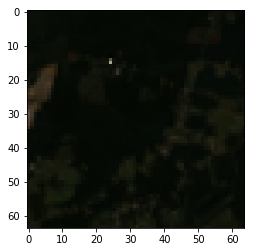

In [195]:
plt.imshow(cloud_ims[0][0])